# Topic: 

### Leveraging Machine Learning for Price Forecasting and Pairs Trading in Highly Cointegrated Indices

## Summary

After selecting five years of historical data for the 20 most important indices worldwide, it was found that the Hang Seng Index (HSI) from Hong Kong and the Straits Times Index (STI) from Singapore are the most highly cointegrated index pairs over the last five years, with a p-value of 0.00026, which is significantly lower than the threshold of 0.05. Therefore, HSI and STI are the two indices used for research purposes.

A Long Short-Term Memory (LSTM) model is used in the machine learning stage to predict the prices of HSI and STI. Therefore, the target variable is the 'Adj Close' of HSI and STI. HSI undergoes the data engineering process first, with 27 features being created. Combined with the provided 'Open', 'High', 'Low', 'Close', and 'Volume', there are 32 feature variables. However, after undergoing Principal Component Analysis and a Random Forest Regressor, only the top 10 variables are used for machine learning in order to capture at least 95% of the variance. After the data engineering step, Optuna is used to optimize the parameters (step, horizon, lstm_units, dense units, epochs, batch size, learning rate, and l1 regularization) of the model. STI follows the exact steps of HSI to maintain consistency in the machine learning stage. The historical data used span the past twenty years because it can help increase the precision of LSTM in predicting the prices, and can enhance the results of root mean squared error (RMSE) and mean absolute error (MAE).

After predicting the next two-day prices of HSI and STI individually - as suggested by the LSTM model, the prices are added into the 'Adj Close' price for pairs trading purposes. Their 'Adj Close' prices each date are converted into USD value by using the USD/HKD 'Adj Close' for HSI and USD/SGD 'Adj Close' for STI of the corresponding date. Also, the predicted prices of HSI and STI are compared to the actual prices of HSI and STI to check the difference.

After all the preparation, Simple Moving Average (SMA), Exponential Moving Average (EMA), Bollinger Bands (BBands), Moving Average Convergence Divergence (MACD), Absolute Price Oscillator (APO), and Relative Strength Index (RSI) are used for backtesting. A simple backtesting method for all of them is used first to find out the one with the best performance. More in-depth analysis and detailed backtesting are then implemented for the best strategy - trading z-score of Bollinger Bands. At the end, the predicted and actual z-scores are compared to check the difference.


#### Result:

The training root mean square error is: 

The test root mean square error is:

The training mean absolute error is: 

The test mean absolute error error is:

The best performance strategy is:  with xxx profit
After detailed backtesting, the profit is:





## Table of Content

#### 1.Finding out the highest cointegrated pairs 

#### 2.Importing HSI and STI data for Data Checking 

    2.1 HSI data processing
    2.2 STI data processing
    2.3 Plotting the graph of HSI against STI
    
#### 3.Data Engineering, Machine Learning and Price Prediction for HSI

    3.1 Candlestick Charts of HSI 
    3.2 Data Feature Engineering: Creating Features
    3.3 Implementing PCA and Random Forest Regressor to Check Feature Importance
    3.4 Extra Two Methods to Check the Importance of Features
    3.5 Machine Learning Steps for HSI
    3.6 Predicting the price of the next two days
    
    
#### 4.Data Engineering, Machine Learning and Price Prediction for STI

    4.1 Candlestick Charts of STI
    4.2 Data Feature Engineering: Creating Features
    4.3 Machine Learning Steps for STI
    4.4 Predicting the Price of the Next Two Days
    
#### 5.Amending Price into USD and Comparing Predicted and Real Price

    5.1 Amending the price of HSI into USD
    5.2 Amending the price of STI into USD
    5.3 Comparison of Predicted Price against Real Price for both HSI and STI
    
#### 6.Pairs Trading Strategy and Backtesting

    6.1 Pairs Trading Using Z-score of HSI/STI Adj Close USD Price Ratio
    
    6.2 Pairs Trading Using 3 Simple Moving Average (SMA) Methods
        6.2.1 Z-score
        6.2.2 Short-term SMA Z-score vs. Long-term SMA Z-score
        6.2.3 Short-term SMA vs. Long-term SMA
        
    6.3 Pairs Trading Using 3 Exponential Moving Average (EMA) Methods
        6.3.1 Z-score
        6.3.2 Short-term SMA vs. Long-term SMA
        6.3.3 Short-term SMA Z-score vs. Long-term SMA Z-scor
        
    6.4 Pairs Trading Using 2 Moving Average Convergence Divergence (MACD) Methods
        6.4.1 MACD vs. Signal Line
        6.4.2 Z-score
        
    6.5 Pairs Trading Using 2 Bollinger Bands (BBands) Methods
        6.5.1 Using Lower Band, Upper Band etc as Signals
        6.5.2 Z-score
        
    6.6 Pairs Trading using 2 Relative Strength (RSI) Methods
        6.6.1 Using 0.3 & 0.7 Threshold
        6.6.2 Z-score
        
    6.7 Pairs Trading Using 2 Absolute Price Oscillator (APO) Methods
        6.7.1 Using 0 line as Signal
        6.7.2 Z-score
        
#### 7.Further Detailed Backtesting of the most Profitable Method 6.5.2

    7.1 Without Transaction Cost and Short Selling Fee Profit
    7.2 With Transaction Cost and Short Selling Fee Profit
    
#### 8.Comparing the Predicted and Actual Z Score

    8.1 Actual Z score 
    8.2 Predicted Z Score

In [1]:
#importing necessary libraries
from datetime import timedelta
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM
from pandas_datareader import data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import coint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import hashlib
import math as math
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import math
import numpy as np
import plotly.graph_objects as go
import optuna
import pandas as pd
import seaborn
import statistics as stats
import tensorflow as tf
import yfinance as yf

### 1. Finding out the highest cointegrated pairs 

Past 5 years data of 20 indices are used to check the cointegration

HSI and STI are most highly cointegrated, with p value 0.00026

File data found...reading symbols data


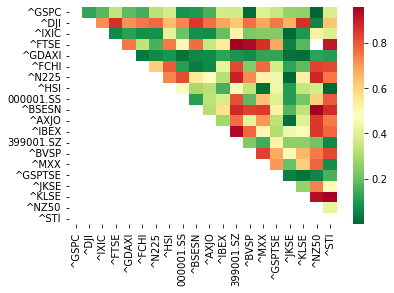

In [2]:
# The 20 index ticker symbols that we are interested in.
symbolsIds = ['^GSPC', '^DJI', '^IXIC', '^FTSE', '^GDAXI', '^FCHI', 
              '^N225', '^HSI', '000001.SS', '^BSESN', '^AXJO', '^IBEX', '399001.SZ', '^BVSP', '^MXX', 
              '^GSPTSE', '^JKSE', '^KLSE', '^NZ50', '^STI']

def get_filename_for_symbols(symbols, start_date, end_date):
    # Concatenate all symbols and the date range into one string.
    combined_symbols_dates = '_'.join(symbols) + f"_{start_date}_to_{end_date}"
    # Compute the MD5 hash of the concatenated string.
    hashed_string = hashlib.md5(combined_symbols_dates.encode()).hexdigest()
    # Use the hash to form a unique filename.
    #the purpose is once we changed the symbolsIds list or date, the file and its corresponding name will amend 
    filename = f"data_{hashed_string}.pkl"
    return filename

def load_financial_data(symbols, start_date, end_date):
    # Get the unique filename for the list of symbols.
    output_file = get_filename_for_symbols(symbols, start_date, end_date)
    try:
        # Attempt to load previously saved data from a pickle file.
        df = pd.read_pickle(output_file)
        print('File data found...reading symbols data')
    except FileNotFoundError:
        # If the file doesn't exist, download the data from Yahoo Finance.
        print('File not found...downloading the symbols data')
        try:
            df = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
            # Save the downloaded data to a pickle file for future use.
            df.to_pickle(output_file)
        except Exception as e:
            # In case of any error during download, print the error and return None.
            print(f"Error occurred while fetching data: {e}")
            return None
    return df

def find_cointegrated_pairs(data):
    # Get the number of stocks (which are represented as columns in the DataFrame).
    n = data.shape[1]
    # Initialize a matrix of ones to store p-values for cointegration tests.
    pvalue_matrix = np.ones((n, n))
    # Retrieve the stock symbols, which are the column names of the DataFrame.
    keys = data.keys()
    pairs = []
    # Loop through each pair of stocks to test for cointegration.
    for i in range(n):
        for j in range(i+1, n):
            # Check if the pair of stocks are cointegrated.
            result = coint(data[keys[i]], data[keys[j]])
            # Store the p-value of the cointegration test.
            pvalue_matrix[i, j] = result[1]
            # If p-value is less than 0.02, it suggests potential cointegration.
            if result[1] < 0.02:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

def visualize_cointegration(pvalues, pairs, symbols):
    # Use heatmap to visualize the p-values of cointegration tests.
    # Green represents strong cointegration, while red indicates weak/no cointegration.
    seaborn.heatmap(pvalues, xticklabels=symbols, yticklabels=symbols, cmap='RdYlGn_r', mask=(pvalues > 0.98))
    plt.show()

# Load financial data either from the local file or download from Yahoo Finance.
data = load_financial_data(symbolsIds, start_date='2018-09-20', end_date='2023-09-20')

if data is not None:
    # Handle missing data by forward-filling.
    data.fillna(method='ffill', inplace=True)
    # Drop any remaining rows with NaN values (e.g., if the first row has NaN values).
    data.dropna(inplace=True)

    # Continue with the rest of analysis.
    pvalues, pairs = find_cointegrated_pairs(data)
    visualize_cointegration(pvalues, pairs, symbolsIds)
else:
    print("Data retrieval failed. Please check the error message above.")

Explanation of the graph:

The greener the color among two indices, the lower the p value so the higher the cointegration

In [3]:
#Function below is used to find out the paris with lowest p value
def get_lowest_pvalue_pairs(pvalues, symbols, n=2):
    # Flatten the p-value matrix and make a copy.
    flat_pvalues = pvalues.flatten()
    # Find the n smallest values.
    lowest_values = np.partition(flat_pvalues, n)[:n]
    pairs_with_pvalues = []
    for value in lowest_values:
        # Find the location of each value in the matrix.
        location = np.argwhere(pvalues == value)
        for loc in location:
            # Check to ensure we aren't using diagonal elements (p-value with self) or duplicates.
            if loc[0] != loc[1] and (symbols[loc[1]], symbols[loc[0]], value) not in pairs_with_pvalues:
                pairs_with_pvalues.append((symbols[loc[0]], symbols[loc[1]], value))
    return pairs_with_pvalues

# get the two pairs with lowest p value
lowest_pairs_with_pvalues = get_lowest_pvalue_pairs(pvalues, symbolsIds)
for pair in lowest_pairs_with_pvalues:
    print(f"Pair: {pair[0]} and {pair[1]}, P-value: {pair[2]}")

Pair: ^HSI and ^STI, P-value: 0.000262649480013669
Pair: ^GSPC and ^NZ50, P-value: 0.00030812606917568334


HSI & STI are the pairs with the lowest p value, while GSPC & NZ50 are the second highly cointegrated pair

### 2. Importing HSI and STI data for Data Checking

To have better predicted prices from LTSM model, past 20 years data would be used

#### 2.1 HSI data processing 

In [4]:
#Fetch HSI data using yfinance 
start_date = '2003-09-20'
end_date = '2023-09-20'
symbols = ['^HSI']
HSI_data = yf.download(symbols, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [5]:
#in order to show all the columns in one row
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

#check the HSI data structure
print(HSI_data.head())

#check if any nan value to make sure the smoothness of aplying LTSM to predict the indice price
print(np.isnan(HSI_data).any())

                    Open          High           Low         Close     Adj Close     Volume
Date                                                                                       
2003-09-22  10920.030273  11010.139648  10822.559570  10873.269531  10873.269531  275224000
2003-09-23  10877.950195  10998.190430  10841.709961  10944.360352  10944.360352  247074000
2003-09-24  11008.429688  11298.959961  11008.429688  11295.889648  11295.889648  465228000
2003-09-25  11273.120117  11444.719727  11230.240234  11286.519531  11286.519531  627774600
2003-09-26  11302.150391  11345.000000  11215.709961  11290.150391  11290.150391  381128800
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


HSI has 6 columns which are 'Open', 'High', 'Low', 'Close', 'Adj Close' and 'Volume'

HSI data has no missing value

Outlier will not be taken out as it is a time-series data

#### 2.2 STI data processing

In [6]:
#Fetch STI data using yfinance 
start_date = '2003-09-20'
end_date = '2023-09-20'
symbols = ['^STI']
STI_data = yf.download(symbols, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [7]:
#check the STI data structure
print(STI_data.head())

#check if any nan value to make sure the smoothness of aplying LTSM to predict the indice price
print(np.isnan(STI_data).any())

                   Open         High          Low        Close    Adj Close     Volume
Date                                                                                  
2003-09-22  1590.069946  1597.989990  1574.479980  1586.630005  1586.630005  138267200
2003-09-23  1585.989990  1594.829956  1582.619995  1588.359985  1588.359985  134698000
2003-09-24  1593.939941  1634.030029  1593.349976  1634.030029  1634.030029  180208800
2003-09-25  1618.400024  1647.359985  1614.010010  1629.819946  1629.819946  194266200
2003-09-26  1630.939941  1632.959961  1622.020020  1627.540039  1627.540039  126160200
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


STI has 6 columns which are 'Open', 'High', 'Low', 'Close', 'Adj Close' and 'Volume'

STI data has no missing value

Outlier will not be taken out as it is a time-series data

#### 2.3 Plotting the graph of HSI against STI

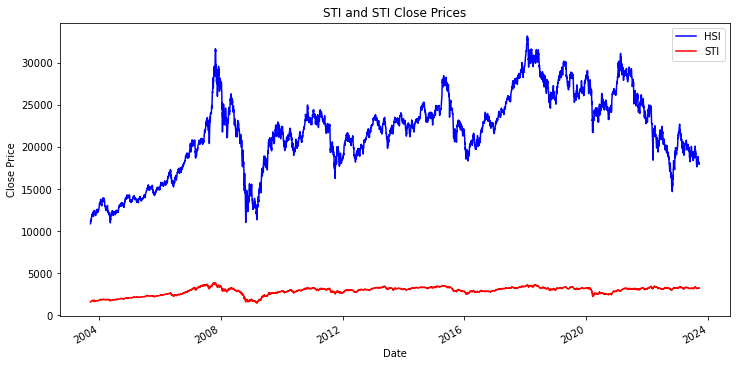

In [8]:
# Plotting HSI and STI 'Adj Close' prices under the same graph
plt.figure(figsize=(12, 6))
HSI_data['Adj Close'].plot(label='HSI', color='blue')
STI_data['Adj Close'].plot(label='STI', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('STI and STI Close Prices')
plt.legend()
plt.show()

### 3. Data Engineering, Machine Learning and Price Prediction for HSI

HSI goes through these three processes first and then STI will follow the step of HSI to maintain consistency

#### 3.1 Candlestick charts of HSI 

In [9]:
#Candlestick charts of HSI
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=HSI_data.index,
                                      open=HSI_data['Open'],
                                      high=HSI_data['High'],
                                      low=HSI_data['Low'],
                                      close=HSI_data['Close'])])

fig.update_layout(title='HSI Price History',
                  xaxis_title='Date',
                  yaxis_title='Price USD',
                  xaxis_rangeslider_visible=True)  # You might want to set this to True if you want a rangeslider

fig.show()

#### 3.2 Data Feature Engineering: Creating features 

In [10]:
#Calculate Volume Difference, Adj Close Dif, Simple Moving Average and Exponential Moving Average
HSI_data['Vol Dif'] = HSI_data['Volume'].diff()
HSI_data['Adj Dif'] = HSI_data['Adj Close'].diff()
HSI_data['SMA'] = HSI_data['Adj Close'].rolling(window=20).mean()
HSI_data['EMA'] = HSI_data['Adj Close'].ewm(span=20, adjust=False).mean()

# Calculate APO (Absolute Price Oscillator) 
short_ema = HSI_data['Adj Close'].ewm(span=12, adjust=False).mean()
long_ema = HSI_data['Adj Close'].ewm(span=26, adjust=False).mean()
HSI_data['APO'] = short_ema - long_ema

# Calculate Bollinger Bands
HSI_data['20_day_SMA'] = HSI_data['Adj Close'].rolling(window=20).mean()
HSI_data['2_std_dev'] = HSI_data['Adj Close'].rolling(window=20).std()
HSI_data['Bollinger_upper'] = HSI_data['20_day_SMA'] + (HSI_data['2_std_dev']*2)
HSI_data['Bollinger_lower'] = HSI_data['20_day_SMA'] - (HSI_data['2_std_dev']*2)

#Calculate Rolling Mean
window_size = 3  
HSI_data['Rolling_Mean'] = HSI_data['Adj Close'].rolling(window=window_size).mean()

#Calculate Rate of change 
HSI_data['ROC'] = HSI_data['Adj Close'].pct_change(periods=1) * 100  

#Calculate mean of the day
HSI_data['day_mean'] = (HSI_data['High'] - HSI_data['Low']) / 2

#Calculate return against the previous day
HSI_data['returns'] = np.log(HSI_data.Close.pct_change() + 1)

#Creating Lag_1 to Lag_5 which holds the return value 1 day, 2 day, 3 day, 4 day and 5 days ago each
def lagit(HSI_data, lags):
    names = []
    for i in range(1, lags + 1):
        HSI_data['Lag_'+str(i)] = HSI_data['returns'].shift(i)
        names.append('Lag_'+str(i))
    return names
lagnames = lagit(HSI_data, 5)

# Create Momentum, moving average of 7 days and moving average of 21 days
HSI_data['momentum'] = HSI_data['Adj Close']-1
HSI_data['ma7'] = HSI_data['Adj Close'].rolling(window=7).mean()
HSI_data['ma21'] = HSI_data['Adj Close'].rolling(window=21).mean()

#Creating Adj Close_lag_1, Adj Close_lag_2, Adj Close_lag_3 holding the past one day, past 2 day and past 3 days value as 
look_back = 3  # for example, create new features with values from 3 days ago
for col in ['Adj Close']:  # and other relevant columns
    for i in range(1, look_back + 1):
        HSI_data[f'{col}_lag_{i}'] = HSI_data[col].shift(i)
        
# Calculate Relative Strength Index
def compute_rsi(data, window=14):
    delta = data.diff()
    delta = delta[1:]
    
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

HSI_data['RSI'] = compute_rsi(HSI_data['Adj Close'])

#Calculate Moving average Convergence Divergence
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

HSI_data['MACD'], HSI_data['Signal_Line'] = compute_macd(HSI_data['Adj Close'])

C:\Users\terra\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\terra\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\terra\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\terra\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



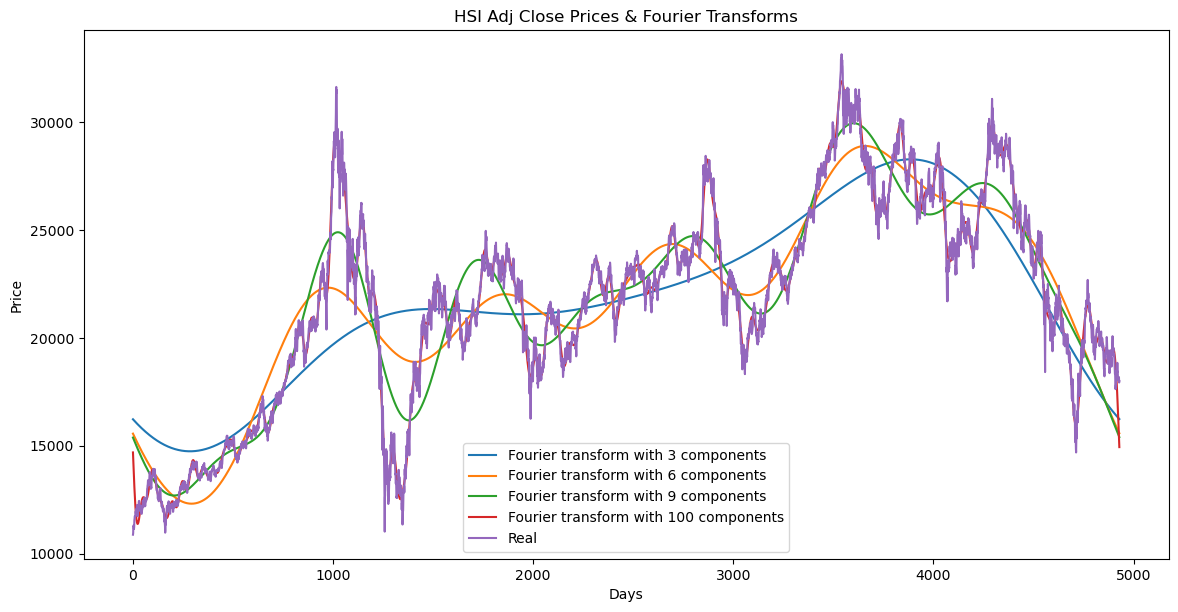

In [11]:
#Fourier Transforms
data_FT = HSI_data[['Adj Close']].copy()
data_FT.reset_index(inplace=True)  # Resetting the index to get the Date column

close_fft = np.fft.fft(np.asarray(data_FT['Adj Close'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10 = np.copy(fft_list)
    fft_list_m10[num_:-num_] = 0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))

plt.plot(data_FT['Adj Close'], label='Real')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('HSI Adj Close Prices & Fourier Transforms')
plt.legend()
plt.show()

# Keep the 100 componets one as features as it moves the best with the real data
num_components = 100
fft_list_m10 = np.copy(fft_list)
fft_list_m10[num_components:-num_components] = 0
denoised_data = np.fft.ifft(fft_list_m10)
HSI_data['Fourier_Denoised'] = denoised_data.real 

In [12]:
#check that features are created successfully and check if any missing value
HSI_data.head(30)

Open          High           Low         Close     Adj Close     Volume  \
Date                                                                                          
2003-09-22  10920.030273  11010.139648  10822.559570  10873.269531  10873.269531  275224000   
2003-09-23  10877.950195  10998.190430  10841.709961  10944.360352  10944.360352  247074000   
2003-09-24  11008.429688  11298.959961  11008.429688  11295.889648  11295.889648  465228000   
2003-09-25  11273.120117  11444.719727  11230.240234  11286.519531  11286.519531  627774600   
2003-09-26  11302.150391  11345.000000  11215.709961  11290.150391  11290.150391  381128800   
2003-09-29  11256.059570  11256.059570  11104.339844  11141.280273  11141.280273  398325800   
2003-09-30  11227.040039  11325.959961  11196.980469  11229.870117  11229.870117  364087200   
2003-10-02  11372.530273  11548.440430  11372.530273  11546.120117  11546.120117  510367400   
2003-10-03  11581.509766  11652.400391  11541.679688  11608.719727  11608.719727  469542000   
2003-10-06  11715.910156  11838.240234  11715.599609  11734.480469  11734.480469  455872800   
2003-10-07  11709.240234  11737.030273  11624.370117  11723.919922  11723.919922  468226200   
2003-10-08  11754.709961  11885.240234  11648.610352  11720.799805  11720.799805  464075600   
2003-10-09  11762.259766  11821.179688  11710.080078  11800.370117  11800.370117  322958000   
2003-10-10  11943.509766  11958.389648  11831.959961  11935.830078  11935.830078  326066600   
2003-10-13  11957.379883  11992.910156  11831.580078  11961.969727  11961.969727  261776800   
2003-10-14  12065.349609  12065.349609  11834.209961  11856.019531  11856.019531  318455000   
2003-10-15  11900.000000  12056.750000  11884.709961  12056.179688  12056.179688  279679600   
2003-10-16  12041.830078  12104.889648  11952.019531  12027.570312  12027.570312  349415200   
2003-10-17  12070.719727  12088.620117  11915.410156  12044.490234  12044.490234  348664000   
2003-10-20  11985.400391  12156.750000  11958.469727  12147.889648  12147.889648  405878200   
2003-10-21  12190.080078  12297.459961  12161.250000  12250.690430  12250.690430  373099600   
2003-10-22  12240.540039  12283.879883  12199.230469  12238.629883  12238.629883  411499800   
2003-10-23  12027.910156  12051.139648  11712.139648  11737.179688  11737.179688  496926000   
2003-10-24  11792.870117  11819.200195  11558.110352  11736.370117  11736.370117  380986200   
2003-10-27  11749.870117  11803.179688  11678.200195  11749.719727  11749.719727  215722000   
2003-10-28  11844.019531  12123.730469  11844.019531  12091.879883  12091.879883  352302800   
2003-10-29  12294.910156  12304.570312  12117.000000  12130.509766  12130.509766  321287800   
2003-10-30  12202.459961  12202.459961  11989.009766  12143.349609  12143.349609  395277400   
2003-10-31  12139.969727  12205.839844  12065.639648  12190.099609  12190.099609  335969000   
2003-11-03  12222.440430  12412.179688  12222.440430  12386.809570  12386.809570  309036400   

                Vol Dif     Adj Dif           SMA           EMA         APO    20_day_SMA  \
Date                                                                                        
2003-09-22          NaN         NaN           NaN  10873.269531    0.000000           NaN   
2003-09-23  -28150000.0   71.090820           NaN  10880.040086    5.671063           NaN   
2003-09-24  218154000.0  351.529297           NaN  10919.644806   38.091798           NaN   
2003-09-25  162546600.0   -9.370117           NaN  10954.585256   62.311092           NaN   
2003-09-26 -246645800.0    3.630859           NaN  10986.543840   80.865864           NaN   
2003-09-29   17197000.0 -148.870117           NaN  11001.280643   82.605853           NaN   
2003-09-30  -34238600.0   88.589844           NaN  11023.051069   90.094710           NaN   
2003-10-02  146280200.0  316.250000           NaN  11072.867169  120.163248           NaN   
2003-10-03  -40825400.0   62.599609           NaN

As we are using span = 20, the first 19 rows of SMA,20_day_SMA, 2_std_dev, Bollinger_upper and Bollinger_lower are missing


Missing data cannot be used to do machine learning so We will only keep the data from row 20 and name the data HSI_data1

In [13]:
#Keep only the data from row 20
HSI_data1 = HSI_data.iloc[20:]

#### 3.3 Implementing PCA and Random Forest Regressor to Check Feature Importance

In [14]:
#import PCA to check variance explained
# Assume HSI_data1 is your DataFrame and 'Adj Close' is your target variable
X = HSI_data1.drop('Adj Close', axis=1)  # Drop the target variable

# Standardize the features (important for PCA)
from sklearn.preprocessing import StandardScaler
X_standardized = StandardScaler().fit_transform(X)

# Initialize PCA and fit the standardized features
pca = PCA(n_components=2)  # You can change the number of components
principalComponents = pca.fit_transform(X_standardized)

# Convert the principal components to a DataFrame
pca_df = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])

# If you want to include the target variable in the resulting DataFrame:
pca_df = pd.concat([pca_df, HSI_data1[['Adj Close']].reset_index(drop=True)], axis=1)

print(pca_df.head())

# To find the explained variance by each principal component
print('Explained variance by each component: ', pca.explained_variance_ratio_)

# To find the total explained variance
print('Total explained variance: ', sum(pca.explained_variance_ratio_))

   Principal Component 1  Principal Component 2     Adj Close
0              -8.689400              -2.678708  12250.690430
1              -8.663085              -2.525070  12238.629883
2              -8.614373              -0.121321  11737.179688
3              -8.764789              -1.039132  11736.370117
4              -8.884746              -1.161172  11749.719727
Explained variance by each component:  [0.52325372 0.12143306]
Total explained variance:  0.6446867833524198


Two components only explain 64.5% of the variance, a graph will be plot below to check how many components can explain 95% variance

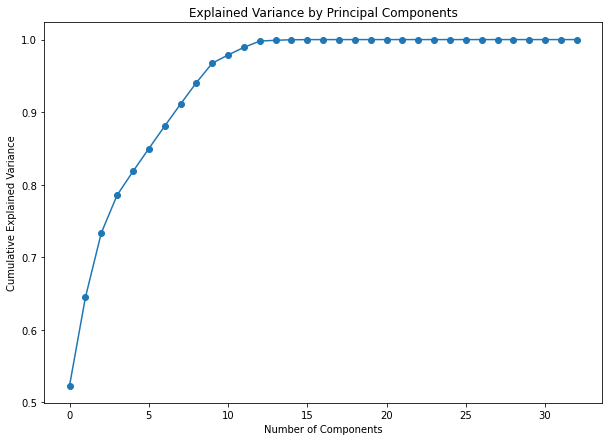

In [15]:
pca_all = PCA().fit(X_standardized)
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_all.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()

In [16]:
# Define pca and X_pca
n_components = 10
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized)

# Create DataFrame with the principal components
columns = [f'Principal Component {i}' for i in range(1, pca.n_components_ + 1)]
pca_df = pd.DataFrame(data=X_pca, columns=columns)

# If you want to include the target variable in the resulting DataFrame:
pca_df = pd.concat([pca_df, HSI_data1[['Adj Close']].reset_index(drop=True)], axis=1)

# Print the DataFrame, explained variance by each component and total explained variance
print(pca_df.head())
print('Explained variance by each component: ', pca.explained_variance_ratio_)
print('Total explained variance: ', sum(pca.explained_variance_ratio_))

   Principal Component 1  Principal Component 2  Principal Component 3  Principal Component 4  \
0              -8.689400              -2.678708               0.161935               0.551923   
1              -8.663085              -2.525070              -0.844350               0.510650   
2              -8.614373              -0.121321              -4.622578               0.891877   
3              -8.764789              -1.039132              -0.533040               0.451022   
4              -8.884746              -1.161172              -0.407567              -0.261637   

   Principal Component 5  Principal Component 6  Principal Component 7  Principal Component 8  \
0               0.635864               0.708423              -0.648922              -0.501370   
1               0.563639              -0.512778               0.180590              -0.453716   
2               0.151433               0.433326              -0.136336               0.442604   
3              -2.356855     

we need at least 10 components to explained 95% of the variance, so we are going to find out the top 10 most imporant features by using random forest regressor

In [17]:
# Separate features and target variable from dataset
X = HSI_data1.drop('Adj Close', axis=1)  # features
y = HSI_data1['Adj Close']  # target variable

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X, y)

# Get Feature Importances
feature_importances = model.feature_importances_

# Create a DataFrame for Feature Importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Format Importance to 3 decimal places
features_df['Importance'] = features_df['Importance'].apply(lambda x: '{:.8f}'.format(x))

# Sort the DataFrame by Importance
features_df = features_df.sort_values(by='Importance', ascending=False)

print(features_df)

             Feature  Importance
3              Close  0.54237450
23          momentum  0.45606245
0               Open  0.00134220
2                Low  0.00013224
1               High  0.00002036
32  Fourier_Denoised  0.00001770
14      Rolling_Mean  0.00001747
26   Adj Close_lag_1  0.00001102
27   Adj Close_lag_2  0.00000627
24               ma7  0.00000263
28   Adj Close_lag_3  0.00000248
12   Bollinger_upper  0.00000178
8                EMA  0.00000105
30              MACD  0.00000104
9                APO  0.00000064
25              ma21  0.00000062
4             Volume  0.00000055
29               RSI  0.00000054
5            Vol Dif  0.00000046
19             Lag_2  0.00000045
31       Signal_Line  0.00000039
13   Bollinger_lower  0.00000039
6            Adj Dif  0.00000036
15               ROC  0.00000032
22             Lag_5  0.00000027
21             Lag_4  0.00000026
7                SMA  0.00000026
18             Lag_1  0.00000025
20             Lag_3  0.00000023
17        

In [18]:
#dropping out the non-top10 features
HSI_data1 = HSI_data1.drop(['Adj Close_lag_3', 'Bollinger_upper', 'MACD', 'EMA', 'APO', 'Vol Dif', 'Lag_2', 'Volume', 'RSI', 
    'Bollinger_lower', 'Signal_Line', 'Lag_4', 'ROC', 'Adj Dif', 'Lag_1', '2_std_dev', 'ma21', 'returns', 'Lag_3', 'day_mean', 
    'Lag_5', '20_day_SMA', 'SMA'], axis=1)

In [19]:
#to chcek we drop them successfully
HSI_data1.head()

Open          High           Low         Close     Adj Close  Rolling_Mean  \
Date                                                                                             
2003-10-21  12190.080078  12297.459961  12161.250000  12250.690430  12250.690430  12147.690104   
2003-10-22  12240.540039  12283.879883  12199.230469  12238.629883  12238.629883  12212.403320   
2003-10-23  12027.910156  12051.139648  11712.139648  11737.179688  11737.179688  12075.500000   
2003-10-24  11792.870117  11819.200195  11558.110352  11736.370117  11736.370117  11904.059896   
2003-10-27  11749.870117  11803.179688  11678.200195  11749.719727  11749.719727  11741.089844   

                momentum           ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  
Date                                                                                        
2003-10-21  12249.690430  12049.258510     12147.889648     12044.490234      11438.646290  
2003-10-22  12237.629883  12088.781390     12250.690430     12147.889648      11404.521892  
2003-10-23  11736.179688  12071.804269     12238.629883     12250.690430      11382.951318  
2003-10-24  11735.370117  12026.117188     11737.179688     12238.629883      11373.396245  
2003-10-27  11748.719727  11986.424247     11736.370117     11737.179688      11375.229442

#### 3.4 Extra Two Methods to check the Importance of Features

Due to corresponding reason, they are not implemented to check the machine learning in this script

1.It has to run 2^33-1 *81 epoch to check features importance

2.It is used to check highly correlated features, but it is suggested that only 'Open' should be kept under this model for above 50% threshold

In [ ]:
# #the codes below is to check one by one which is the most important, but it has 2^33-1 *81 epoch to check, so will not use this step
# # 80-20 split for train and test data
# train_data_size = int(len(HSI_data1) * 0.8)
# train_data = HSI_data1.iloc[:train_data_size]
# test_data = HSI_data1.iloc[train_data_size:]


# train_features = train_data.drop('Adj Close', axis=1)
# train_target = train_data[['Adj Close']]
# test_features = test_data.drop('Adj Close', axis=1)
# test_target = test_data[['Adj Close']]

# # Create Sequences
# def create_sequences(features, target, step):
#     x, y = [], []
#     for i in range(len(features) - step):
#         x.append(features[i: (i + step)])
#         y.append(target[i + step])
#     return np.array(x), np.array(y)

# step = 10
# x_train, y_train = create_sequences(train_features_scaled, train_target_scaled, step)
# x_test, y_test = create_sequences(test_features_scaled, test_target_scaled, step)

# from sklearn.metrics import mean_squared_error
# import itertools

# # Now, before going ahead with scaling and creating sequences, try out different feature combinations
# results = []
# original_features = list(train_features.columns)  # Make sure you have correct feature names here

# # Loop over every possible combination of features, one by one
# for L in range(1, len(original_features) + 1):
#     for subset in itertools.combinations(original_features, L):
#         subset = list(subset)  # Convert to list as itertools.combinations returns a tuple
        
#         subset_train_features = train_features[subset]
#         subset_test_features = test_features[subset]

#         # Scale Features and Target
#         feature_scaler = MinMaxScaler(feature_range=(0, 1))
#         target_scaler = MinMaxScaler(feature_range=(0, 1))
        
#         train_features_scaled = feature_scaler.fit_transform(subset_train_features)
#         train_target_scaled = target_scaler.fit_transform(train_target)
#         test_features_scaled = feature_scaler.transform(subset_test_features)
#         test_target_scaled = target_scaler.transform(test_target)

#         # Create sequences and then build, compile, train, and evaluate the model for each feature subset
#         step = 10
#         x_train, y_train = create_sequences(train_features_scaled, train_target_scaled, step)
#         x_test, y_test = create_sequences(test_features_scaled, test_target_scaled, step)
        
#         # Define Model
#         model = Sequential()
#         model.add(LSTM(51, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#         model.add(LSTM(51, return_sequences=False))
#         model.add(Dense(25))
#         model.add(Dense(1))

#         # Compile Model
#         optimizer = Adam(learning_rate=0.0026)
#         model.compile(optimizer=optimizer, loss='mean_squared_error')

#         # Train Model
#         model.fit(x_train, y_train, epochs=83, batch_size=32, verbose=1, shuffle=False)

#         # Predict and Evaluate
#         y_pred_train_scaled = model.predict(x_train)
#         y_pred_test_scaled = model.predict(x_test)
        
#         y_pred_train = target_scaler.inverse_transform(y_pred_train_scaled).flatten()
#         y_pred_test = target_scaler.inverse_transform(y_pred_test_scaled).flatten()
        
#         y_train_original = target_scaler.inverse_transform(y_train).flatten()
#         y_test_original = target_scaler.inverse_transform(y_test).flatten()

#         rmse_train = np.sqrt(mean_squared_error(y_train_original, y_pred_train))
#         rmse_test = np.sqrt(mean_squared_error(y_test_original, y_pred_test))
        
#         results.append({'features': subset, 'rmse_train': rmse_train, 'rmse_test': rmse_test})


# # Analyze the results and choose the best feature set based on RMSE
# results_df = pd.DataFrame(results)
# print(results_df.sort_values(by='rmse_test').head())

In [ ]:
# # 1. Selecting Features that are highly correlated with 'Adj Close'
# corr_threshold = 0.0  # You can adjust this threshold
# highly_correlated_features = correlations[correlations.abs() > corr_threshold].index.tolist()

# # 2. From this subset, remove features that are highly correlated with each other
# final_features = []
# already_added = set()

# for feature in highly_correlated_features:
#     is_correlated_with_already_added = any(
#         HSI_data1[feature].corr(HSI_data1[added_feature]) > corr_threshold 
#         for added_feature in already_added
#     )
#     if not is_correlated_with_already_added:
#         final_features.append(feature)
#         already_added.add(feature)

# print(final_features)

#### 3.5 Machine Learning Steps for HSI

In [20]:
# 80-20 split for train and test data
train_data_size_hsi = int(len(HSI_data1) * 0.8)
train_data_hsi = HSI_data1.iloc[:train_data_size_hsi]
test_data_hsi = HSI_data1.iloc[train_data_size_hsi:]

# Separate features and target
train_features_hsi = train_data_hsi.drop('Adj Close', axis=1)
train_target_hsi = train_data_hsi[['Adj Close']]
test_features_hsi = test_data_hsi.drop('Adj Close', axis=1)
test_target_hsi = test_data_hsi[['Adj Close']]

# Initialize a scaler for the features and a separate scaler for the target
feature_scaler_hsi = MinMaxScaler(feature_range=(0, 1))
target_scaler_hsi = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the training data
train_features_scaled_hsi = feature_scaler_hsi.fit_transform(train_features_hsi)
train_target_scaled_hsi = target_scaler_hsi.fit_transform(train_target_hsi)

# Transform the test data
test_features_scaled_hsi = feature_scaler_hsi.transform(test_features_hsi)
test_target_scaled_hsi = target_scaler_hsi.transform(test_target_hsi)

#### The codes below is using Optuna to find out the best parameters to optimize the model
### The codes below take around 10 hours to run

In [ ]:
# from keras import regularizers
# # Define the create_sequences function before running the Optuna optimization
# def create_sequences_hsi(features, target, step, horizon):
#     x, y = [], []
#     for i in range(len(features) - (step + horizon) + 1):
#         x.append(features[i:(i + step)])
#         y.append(target[i + step:i + step + horizon])
#     return np.array(x), np.array(y)

# # Define the Optuna objective function for HSI
# def objective_hsi(trial):
#     # Define search space
#     step = trial.suggest_int("step", 10, 60)
#     horizon = trial.suggest_int("horizon", 1, 5)
#     lstm_units = trial.suggest_int("lstm_units", 32, 64)
#     dense_units = trial.suggest_int("dense_units", 16, 64)
#     epochs = trial.suggest_int("epochs", 10, 100)
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
#     learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
#     l1_regularizer = trial.suggest_float("l1_regularizer", 1e-4, 1e-2, log=True)  # Suggesting a regularization factor
    
#     x_train_hsi, y_train_hsi = create_sequences_hsi(train_features_scaled_hsi, train_target_scaled_hsi, step, horizon)
#     x_test_hsi, y_test_hsi = create_sequences_hsi(test_features_scaled_hsi, test_target_scaled_hsi, step, horizon)
    
#     model_hsi = Sequential()
#     model_hsi.add(LSTM(lstm_units, return_sequences=True, input_shape=(x_train_hsi.shape[1], x_train_hsi.shape[2]), 
#                        kernel_regularizer=regularizers.l1(l1_regularizer)))  # Applying L1 regularization to LSTM layer
#     model_hsi.add(LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l1(l1_regularizer)))  # Applying L1 regularization to LSTM layer
#     model_hsi.add(Dense(dense_units, kernel_regularizer=regularizers.l1(l1_regularizer)))  # Applying L1 regularization to Dense layer
#     model_hsi.add(Dense(horizon, kernel_regularizer=regularizers.l1(l1_regularizer)))  # Applying L1 regularization to Dense layer
#     optimizer_hsi = Adam(learning_rate=learning_rate)
#     model_hsi.compile(optimizer=optimizer_hsi, loss='mean_squared_error')
    
#     history_hsi = model_hsi.fit(x_train_hsi, y_train_hsi, validation_data=(x_test_hsi, y_test_hsi), epochs=epochs, batch_size=batch_size, verbose=0)
#     val_loss_hsi = history_hsi.history['val_loss'][-1]
#     return val_loss_hsi

# # Running the optimization for HSI
# study_hsi = optuna.create_study(direction="minimize")
# study_hsi.optimize(objective_hsi, n_trials=100)

# best_params_hsi = study_hsi.best_params
# best_rmse_hsi = np.sqrt(study_hsi.best_value)

# print(f"Best RMSE for HSI: {best_rmse_hsi} with params={best_params_hsi}")

In [ ]:
# # Get all completed trials in the study.
# all_trials = study_hsi.get_trials(deepcopy=False)

# # Filter the completed trials which have an RMSE value and sort them based on RMSE.
# completed_trials = [trial for trial in all_trials if trial.state == optuna.trial.TrialState.COMPLETE]
# sorted_trials = sorted(completed_trials, key=lambda trial: trial.value)

# # Print the 2nd to 5th best trials.
# for i in range(0, min(100, len(sorted_trials))):  
#     trial = sorted_trials[i]
#     print(f"{i + 1}th Best RMSE: {np.sqrt(trial.value)} with params={trial.params}")

#### The results from Optuna is printed below for reference

In [ ]:
# 1th Best RMSE: 0.033870928806835544 with params={'step': 24, 'horizon': 2, 'lstm_units': 45, 'dense_units': 60, 'epochs': 97, 'batch_size': 16, 'learning_rate': 0.001051763974129867, 'l1_regularizer': 0.00012148933726159216}
# 2th Best RMSE: 0.035207237912829266 with params={'step': 19, 'horizon': 2, 'lstm_units': 63, 'dense_units': 59, 'epochs': 75, 'batch_size': 16, 'learning_rate': 0.001280602882055283, 'l1_regularizer': 0.00010098432929436251}
# 3th Best RMSE: 0.03554898022611326 with params={'step': 55, 'horizon': 1, 'lstm_units': 58, 'dense_units': 26, 'epochs': 96, 'batch_size': 16, 'learning_rate': 0.0008491858257346095, 'l1_regularizer': 0.00012467771038102653}
# 4th Best RMSE: 0.035695346771728066 with params={'step': 22, 'horizon': 2, 'lstm_units': 62, 'dense_units': 60, 'epochs': 91, 'batch_size': 16, 'learning_rate': 0.00125495397930158, 'l1_regularizer': 0.00011675987195026046}
# 5th Best RMSE: 0.035804809498729946 with params={'step': 25, 'horizon': 2, 'lstm_units': 47, 'dense_units': 60, 'epochs': 80, 'batch_size': 16, 'learning_rate': 0.0019236024609569457, 'l1_regularizer': 0.00011560924249401121}
# 6th Best RMSE: 0.03581072491023423 with params={'step': 14, 'horizon': 3, 'lstm_units': 35, 'dense_units': 59, 'epochs': 80, 'batch_size': 16, 'learning_rate': 0.0018955695568840826, 'l1_regularizer': 0.00012864881120309282}
# 7th Best RMSE: 0.035869101618582776 with params={'step': 53, 'horizon': 2, 'lstm_units': 63, 'dense_units': 20, 'epochs': 92, 'batch_size': 16, 'learning_rate': 0.0011434643870694525, 'l1_regularizer': 0.00011084619392565787}
# 8th Best RMSE: 0.03618149602915176 with params={'step': 22, 'horizon': 3, 'lstm_units': 37, 'dense_units': 64, 'epochs': 67, 'batch_size': 16, 'learning_rate': 0.00176047469584489, 'l1_regularizer': 0.00011307408493424415}
# 9th Best RMSE: 0.036375789815748044 with params={'step': 25, 'horizon': 2, 'lstm_units': 46, 'dense_units': 59, 'epochs': 95, 'batch_size': 16, 'learning_rate': 0.002950912425675471, 'l1_regularizer': 0.00011345951593293983}
# 10th Best RMSE: 0.036453403554000084 with params={'step': 50, 'horizon': 2, 'lstm_units': 59, 'dense_units': 64, 'epochs': 83, 'batch_size': 16, 'learning_rate': 0.001217258782043542, 'l1_regularizer': 0.00011242553653511462}
# 11th Best RMSE: 0.036507288210769685 with params={'step': 17, 'horizon': 2, 'lstm_units': 63, 'dense_units': 58, 'epochs': 75, 'batch_size': 16, 'learning_rate': 0.0014424828056012462, 'l1_regularizer': 0.00010426944456150359}
# 12th Best RMSE: 0.03652302007385634 with params={'step': 24, 'horizon': 2, 'lstm_units': 37, 'dense_units': 59, 'epochs': 90, 'batch_size': 16, 'learning_rate': 0.0020482085936453552, 'l1_regularizer': 0.00011227524746765309}
# 13th Best RMSE: 0.03661359392299409 with params={'step': 13, 'horizon': 3, 'lstm_units': 32, 'dense_units': 62, 'epochs': 80, 'batch_size': 16, 'learning_rate': 0.001856092493942682, 'l1_regularizer': 0.00013220655012219788}
# 14th Best RMSE: 0.036647612189166984 with params={'step': 30, 'horizon': 3, 'lstm_units': 64, 'dense_units': 64, 'epochs': 75, 'batch_size': 16, 'learning_rate': 0.0014166005651900437, 'l1_regularizer': 0.00010263208301037666}
# 15th Best RMSE: 0.03682446119745203 with params={'step': 21, 'horizon': 3, 'lstm_units': 41, 'dense_units': 52, 'epochs': 80, 'batch_size': 16, 'learning_rate': 0.0013123617339272703, 'l1_regularizer': 0.00013282349982805602}
# 16th Best RMSE: 0.03683973371446631 with params={'step': 20, 'horizon': 3, 'lstm_units': 63, 'dense_units': 56, 'epochs': 75, 'batch_size': 16, 'learning_rate': 0.0013936303853954756, 'l1_regularizer': 0.00010039055116111849}
# 17th Best RMSE: 0.03694317013205275 with params={'step': 17, 'horizon': 2, 'lstm_units': 63, 'dense_units': 58, 'epochs': 75, 'batch_size': 16, 'learning_rate': 0.0014036017603151236, 'l1_regularizer': 0.0001005525585946352}
# 18th Best RMSE: 0.03699414501579867 with params={'step': 10, 'horizon': 3, 'lstm_units': 32, 'dense_units': 62, 'epochs': 77, 'batch_size': 16, 'learning_rate': 0.001890902197096911, 'l1_regularizer': 0.0001147932277105387}
# 19th Best RMSE: 0.03715303168232955 with params={'step': 27, 'horizon': 3, 'lstm_units': 64, 'dense_units': 62, 'epochs': 75, 'batch_size': 16, 'learning_rate': 0.0014520715295260479, 'l1_regularizer': 0.0001009574121365309}
# 20th Best RMSE: 0.037852553407790306 with params={'step': 22, 'horizon': 3, 'lstm_units': 34, 'dense_units': 64, 'epochs': 68, 'batch_size': 16, 'learning_rate': 0.0017824113490721837, 'l1_regularizer': 0.00011420916448117298}
# 21th Best RMSE: 0.037942696460948055 with params={'step': 19, 'horizon': 2, 'lstm_units': 60, 'dense_units': 56, 'epochs': 91, 'batch_size': 16, 'learning_rate': 0.0012140423184930046, 'l1_regularizer': 0.00014408301377868504}
# 22th Best RMSE: 0.037974924826080655 with params={'step': 54, 'horizon': 2, 'lstm_units': 62, 'dense_units': 20, 'epochs': 93, 'batch_size': 16, 'learning_rate': 0.001193531218984114, 'l1_regularizer': 0.00012325702910136576}
# 23th Best RMSE: 0.0381065872038995 with params={'step': 13, 'horizon': 3, 'lstm_units': 63, 'dense_units': 60, 'epochs': 76, 'batch_size': 16, 'learning_rate': 0.0014756001833263553, 'l1_regularizer': 0.00010395858670328429}
# 24th Best RMSE: 0.038137361460119645 with params={'step': 56, 'horizon': 1, 'lstm_units': 53, 'dense_units': 19, 'epochs': 84, 'batch_size': 16, 'learning_rate': 0.0007855793669049206, 'l1_regularizer': 0.000230670570232719}
# 25th Best RMSE: 0.03822883215186413 with params={'step': 54, 'horizon': 2, 'lstm_units': 61, 'dense_units': 18, 'epochs': 82, 'batch_size': 16, 'learning_rate': 0.0011080656059603924, 'l1_regularizer': 0.00011949171604110976}
# 26th Best RMSE: 0.03827134114837517 with params={'step': 54, 'horizon': 2, 'lstm_units': 62, 'dense_units': 20, 'epochs': 82, 'batch_size': 16, 'learning_rate': 0.0012898044165637315, 'l1_regularizer': 0.00012206368902300498}
# 27th Best RMSE: 0.038691275178532276 with params={'step': 58, 'horizon': 1, 'lstm_units': 61, 'dense_units': 18, 'epochs': 88, 'batch_size': 16, 'learning_rate': 0.0010607159125475395, 'l1_regularizer': 0.00012180695260047893}
# 28th Best RMSE: 0.03876047046536629 with params={'step': 58, 'horizon': 1, 'lstm_units': 61, 'dense_units': 17, 'epochs': 87, 'batch_size': 16, 'learning_rate': 0.000986325379983658, 'l1_regularizer': 0.00017059028171138418}
# 29th Best RMSE: 0.03887387869856804 with params={'step': 54, 'horizon': 2, 'lstm_units': 62, 'dense_units': 21, 'epochs': 81, 'batch_size': 16, 'learning_rate': 0.001342296619040012, 'l1_regularizer': 0.00013394671880848964}
# 30th Best RMSE: 0.03890800172192494 with params={'step': 13, 'horizon': 3, 'lstm_units': 33, 'dense_units': 60, 'epochs': 73, 'batch_size': 16, 'learning_rate': 0.002126151701280823, 'l1_regularizer': 0.0001310077297315105}
# 31th Best RMSE: 0.038908875395483496 with params={'step': 58, 'horizon': 1, 'lstm_units': 58, 'dense_units': 18, 'epochs': 87, 'batch_size': 16, 'learning_rate': 0.0007577471751058322, 'l1_regularizer': 0.0001641987106169747}
# 32th Best RMSE: 0.03902804673241101 with params={'step': 58, 'horizon': 1, 'lstm_units': 61, 'dense_units': 17, 'epochs': 87, 'batch_size': 16, 'learning_rate': 0.0009839016962902454, 'l1_regularizer': 0.00017040150756934003}
# 33th Best RMSE: 0.039047855373857965 with params={'step': 58, 'horizon': 1, 'lstm_units': 60, 'dense_units': 26, 'epochs': 88, 'batch_size': 16, 'learning_rate': 0.0007056267700749861, 'l1_regularizer': 0.0001699910126759348}
# 34th Best RMSE: 0.03922924127731388 with params={'step': 29, 'horizon': 3, 'lstm_units': 38, 'dense_units': 61, 'epochs': 60, 'batch_size': 16, 'learning_rate': 0.0008942139806799822, 'l1_regularizer': 0.00013450226375008687}
# 35th Best RMSE: 0.03927271723708085 with params={'step': 13, 'horizon': 3, 'lstm_units': 35, 'dense_units': 62, 'epochs': 73, 'batch_size': 16, 'learning_rate': 0.0016184672023570607, 'l1_regularizer': 0.00015463816500056903}
# 36th Best RMSE: 0.03945119559178106 with params={'step': 25, 'horizon': 3, 'lstm_units': 64, 'dense_units': 63, 'epochs': 70, 'batch_size': 16, 'learning_rate': 0.0016741812685440792, 'l1_regularizer': 0.00011241776774207595}
# 37th Best RMSE: 0.03958025175781717 with params={'step': 56, 'horizon': 1, 'lstm_units': 58, 'dense_units': 25, 'epochs': 99, 'batch_size': 16, 'learning_rate': 0.0007836191031151101, 'l1_regularizer': 0.0002424930604401318}
# 38th Best RMSE: 0.039689156042957946 with params={'step': 55, 'horizon': 1, 'lstm_units': 61, 'dense_units': 17, 'epochs': 79, 'batch_size': 16, 'learning_rate': 0.0009422745295737643, 'l1_regularizer': 0.00015702345161585165}
# 39th Best RMSE: 0.03992619102246472 with params={'step': 50, 'horizon': 2, 'lstm_units': 59, 'dense_units': 63, 'epochs': 82, 'batch_size': 16, 'learning_rate': 0.0021759778863252727, 'l1_regularizer': 0.00011872050910090208}
# 40th Best RMSE: 0.040021638160843115 with params={'step': 60, 'horizon': 1, 'lstm_units': 57, 'dense_units': 25, 'epochs': 96, 'batch_size': 16, 'learning_rate': 0.0003264238924122147, 'l1_regularizer': 0.00023527578428062418}
# 41th Best RMSE: 0.040359208623363736 with params={'step': 19, 'horizon': 2, 'lstm_units': 60, 'dense_units': 61, 'epochs': 92, 'batch_size': 16, 'learning_rate': 0.001820590043687867, 'l1_regularizer': 0.00014222563457651173}
# 42th Best RMSE: 0.04060804134602966 with params={'step': 46, 'horizon': 4, 'lstm_units': 55, 'dense_units': 27, 'epochs': 69, 'batch_size': 32, 'learning_rate': 0.0007316292002507094, 'l1_regularizer': 0.00012860367930546382}
# 43th Best RMSE: 0.04069748747914769 with params={'step': 31, 'horizon': 3, 'lstm_units': 41, 'dense_units': 53, 'epochs': 78, 'batch_size': 16, 'learning_rate': 0.0008767355828543497, 'l1_regularizer': 0.00020280068691695474}
# 44th Best RMSE: 0.040808161496721035 with params={'step': 56, 'horizon': 1, 'lstm_units': 57, 'dense_units': 19, 'epochs': 99, 'batch_size': 16, 'learning_rate': 0.00044147517722217675, 'l1_regularizer': 0.00023553265400609333}
# 45th Best RMSE: 0.0408944756133732 with params={'step': 58, 'horizon': 2, 'lstm_units': 62, 'dense_units': 17, 'epochs': 86, 'batch_size': 16, 'learning_rate': 0.0012340921089893616, 'l1_regularizer': 0.00017191808848000508}
# 46th Best RMSE: 0.041014156144952366 with params={'step': 15, 'horizon': 2, 'lstm_units': 35, 'dense_units': 59, 'epochs': 85, 'batch_size': 16, 'learning_rate': 0.002533014186015634, 'l1_regularizer': 0.0001924681647631823}
# 47th Best RMSE: 0.04170926981314502 with params={'step': 56, 'horizon': 3, 'lstm_units': 58, 'dense_units': 25, 'epochs': 96, 'batch_size': 32, 'learning_rate': 0.0008078043320729349, 'l1_regularizer': 0.00012633373885852413}
# 48th Best RMSE: 0.04180326073209162 with params={'step': 57, 'horizon': 2, 'lstm_units': 64, 'dense_units': 49, 'epochs': 49, 'batch_size': 32, 'learning_rate': 0.0016560814129380566, 'l1_regularizer': 0.00010087373895409013}
# 49th Best RMSE: 0.04250858324738928 with params={'step': 27, 'horizon': 2, 'lstm_units': 47, 'dense_units': 57, 'epochs': 94, 'batch_size': 16, 'learning_rate': 0.0031849050875681923, 'l1_regularizer': 0.00016196511691338603}
# 50th Best RMSE: 0.042652344214827796 with params={'step': 57, 'horizon': 1, 'lstm_units': 50, 'dense_units': 22, 'epochs': 85, 'batch_size': 16, 'learning_rate': 0.00020787311138771382, 'l1_regularizer': 0.00018169414358843526}
# 51th Best RMSE: 0.04379526456584741 with params={'step': 47, 'horizon': 4, 'lstm_units': 59, 'dense_units': 21, 'epochs': 71, 'batch_size': 32, 'learning_rate': 0.0006165194297767593, 'l1_regularizer': 0.00012858790473429754}
# 52th Best RMSE: 0.04385681513347721 with params={'step': 51, 'horizon': 1, 'lstm_units': 53, 'dense_units': 19, 'epochs': 83, 'batch_size': 16, 'learning_rate': 0.000292112255995134, 'l1_regularizer': 0.0002238980405244561}
# 53th Best RMSE: 0.04398437194671756 with params={'step': 50, 'horizon': 2, 'lstm_units': 63, 'dense_units': 23, 'epochs': 75, 'batch_size': 16, 'learning_rate': 0.0014728490638115058, 'l1_regularizer': 0.00011745235999491697}
# 54th Best RMSE: 0.04399722265271727 with params={'step': 41, 'horizon': 4, 'lstm_units': 64, 'dense_units': 36, 'epochs': 44, 'batch_size': 32, 'learning_rate': 0.0011205496259428561, 'l1_regularizer': 0.00010040137978288811}
# 55th Best RMSE: 0.0452158833048476 with params={'step': 59, 'horizon': 1, 'lstm_units': 55, 'dense_units': 25, 'epochs': 96, 'batch_size': 16, 'learning_rate': 0.0002927230238641203, 'l1_regularizer': 0.00039317269036626736}
# 56th Best RMSE: 0.045222231959566594 with params={'step': 56, 'horizon': 1, 'lstm_units': 58, 'dense_units': 24, 'epochs': 100, 'batch_size': 16, 'learning_rate': 0.00036791710664993546, 'l1_regularizer': 0.00029848521805418276}
# 57th Best RMSE: 0.0452635973916372 with params={'step': 53, 'horizon': 2, 'lstm_units': 63, 'dense_units': 20, 'epochs': 93, 'batch_size': 64, 'learning_rate': 0.001112616938258982, 'l1_regularizer': 0.00010678605389073971}
# 58th Best RMSE: 0.04529845435220594 with params={'step': 18, 'horizon': 3, 'lstm_units': 63, 'dense_units': 57, 'epochs': 71, 'batch_size': 16, 'learning_rate': 0.0023223762303916603, 'l1_regularizer': 0.00015003967613832437}
# 59th Best RMSE: 0.04562724428829821 with params={'step': 56, 'horizon': 2, 'lstm_units': 56, 'dense_units': 27, 'epochs': 78, 'batch_size': 16, 'learning_rate': 0.0008277913308550281, 'l1_regularizer': 0.0003107111838371323}
# 60th Best RMSE: 0.04599520192425718 with params={'step': 53, 'horizon': 1, 'lstm_units': 56, 'dense_units': 32, 'epochs': 95, 'batch_size': 16, 'learning_rate': 0.0007112671465791839, 'l1_regularizer': 0.0004469976747053502}
# 61th Best RMSE: 0.04621123700758289 with params={'step': 43, 'horizon': 4, 'lstm_units': 45, 'dense_units': 39, 'epochs': 38, 'batch_size': 32, 'learning_rate': 0.0009728861485730834, 'l1_regularizer': 0.00010756843105972283}
# 62th Best RMSE: 0.04630796121143571 with params={'step': 48, 'horizon': 4, 'lstm_units': 55, 'dense_units': 27, 'epochs': 63, 'batch_size': 32, 'learning_rate': 0.0008273705859577088, 'l1_regularizer': 0.00013764274368919483}
# 63th Best RMSE: 0.04666063097300734 with params={'step': 22, 'horizon': 2, 'lstm_units': 38, 'dense_units': 64, 'epochs': 97, 'batch_size': 64, 'learning_rate': 0.0012275434439811186, 'l1_regularizer': 0.00015031216862158595}
# 64th Best RMSE: 0.046822053590970004 with params={'step': 60, 'horizon': 1, 'lstm_units': 56, 'dense_units': 19, 'epochs': 89, 'batch_size': 16, 'learning_rate': 0.00017001574139571547, 'l1_regularizer': 0.0002343220215872867}
# 65th Best RMSE: 0.04685857107427491 with params={'step': 60, 'horizon': 1, 'lstm_units': 49, 'dense_units': 19, 'epochs': 79, 'batch_size': 16, 'learning_rate': 0.0003947010298738695, 'l1_regularizer': 0.00034137545016260954}
# 66th Best RMSE: 0.046895199138996355 with params={'step': 51, 'horizon': 3, 'lstm_units': 61, 'dense_units': 16, 'epochs': 72, 'batch_size': 32, 'learning_rate': 0.0005210249916994616, 'l1_regularizer': 0.00018610665516338623}
# 67th Best RMSE: 0.04793106257837506 with params={'step': 11, 'horizon': 2, 'lstm_units': 59, 'dense_units': 55, 'epochs': 67, 'batch_size': 16, 'learning_rate': 0.0015656408255028122, 'l1_regularizer': 0.00020324172340700645}
# 68th Best RMSE: 0.04794230420976426 with params={'step': 22, 'horizon': 3, 'lstm_units': 63, 'dense_units': 53, 'epochs': 65, 'batch_size': 16, 'learning_rate': 0.002023922089189973, 'l1_regularizer': 0.0001398987260785614}
# 69th Best RMSE: 0.048204470863750716 with params={'step': 43, 'horizon': 4, 'lstm_units': 62, 'dense_units': 41, 'epochs': 41, 'batch_size': 32, 'learning_rate': 0.0010313310125729975, 'l1_regularizer': 0.00011287387942571753}
# 70th Best RMSE: 0.04827571960289591 with params={'step': 53, 'horizon': 1, 'lstm_units': 51, 'dense_units': 28, 'epochs': 90, 'batch_size': 16, 'learning_rate': 0.0004731416738954642, 'l1_regularizer': 0.0005180921065023695}
# 71th Best RMSE: 0.04876799457269418 with params={'step': 49, 'horizon': 1, 'lstm_units': 54, 'dense_units': 30, 'epochs': 100, 'batch_size': 16, 'learning_rate': 0.0004687068258017384, 'l1_regularizer': 0.0006288880326109605}
# 72th Best RMSE: 0.04943890512539701 with params={'step': 39, 'horizon': 4, 'lstm_units': 49, 'dense_units': 43, 'epochs': 62, 'batch_size': 32, 'learning_rate': 0.0006003448625924047, 'l1_regularizer': 0.0002598785302502921}
# 73th Best RMSE: 0.04964274838294517 with params={'step': 43, 'horizon': 2, 'lstm_units': 60, 'dense_units': 37, 'epochs': 32, 'batch_size': 32, 'learning_rate': 0.0010979969170442268, 'l1_regularizer': 0.00014847004058447146}
# 74th Best RMSE: 0.05061496965654478 with params={'step': 43, 'horizon': 4, 'lstm_units': 63, 'dense_units': 34, 'epochs': 35, 'batch_size': 32, 'learning_rate': 0.0012308791982035279, 'l1_regularizer': 0.00010582346487500205}
# 75th Best RMSE: 0.051153496725248986 with params={'step': 54, 'horizon': 3, 'lstm_units': 57, 'dense_units': 50, 'epochs': 49, 'batch_size': 16, 'learning_rate': 0.0018174844076062815, 'l1_regularizer': 0.00027380291829119793}
# 76th Best RMSE: 0.05165833459177047 with params={'step': 52, 'horizon': 1, 'lstm_units': 53, 'dense_units': 23, 'epochs': 92, 'batch_size': 64, 'learning_rate': 0.0005450019162953032, 'l1_regularizer': 0.00026640906677555726}
# 77th Best RMSE: 0.05304706331523004 with params={'step': 31, 'horizon': 4, 'lstm_units': 32, 'dense_units': 24, 'epochs': 47, 'batch_size': 32, 'learning_rate': 0.0019999958857013305, 'l1_regularizer': 0.00016057932802287915}
# 78th Best RMSE: 0.05326321788604296 with params={'step': 47, 'horizon': 4, 'lstm_units': 64, 'dense_units': 21, 'epochs': 73, 'batch_size': 32, 'learning_rate': 0.0006639992506323904, 'l1_regularizer': 0.00029371091222821905}
# 79th Best RMSE: 0.05443181569836668 with params={'step': 35, 'horizon': 3, 'lstm_units': 44, 'dense_units': 45, 'epochs': 19, 'batch_size': 16, 'learning_rate': 0.0015255370912644524, 'l1_regularizer': 0.0001435794398377426}
# 80th Best RMSE: 0.05474137309336802 with params={'step': 59, 'horizon': 2, 'lstm_units': 52, 'dense_units': 49, 'epochs': 25, 'batch_size': 32, 'learning_rate': 0.0017319500746637536, 'l1_regularizer': 0.00018096705405449133}
# 81th Best RMSE: 0.054935679817045634 with params={'step': 38, 'horizon': 2, 'lstm_units': 62, 'dense_units': 36, 'epochs': 23, 'batch_size': 32, 'learning_rate': 0.0013939674072787661, 'l1_regularizer': 0.00015247626536731376}
# 82th Best RMSE: 0.054981721724873395 with params={'step': 15, 'horizon': 2, 'lstm_units': 64, 'dense_units': 59, 'epochs': 60, 'batch_size': 64, 'learning_rate': 0.0016566467089196755, 'l1_regularizer': 0.00010585273806520809}
# 83th Best RMSE: 0.056066812805475014 with params={'step': 24, 'horizon': 5, 'lstm_units': 64, 'dense_units': 29, 'epochs': 48, 'batch_size': 32, 'learning_rate': 0.0028436290111020046, 'l1_regularizer': 0.00022265069704539402}
# 84th Best RMSE: 0.05799614615600833 with params={'step': 39, 'horizon': 5, 'lstm_units': 60, 'dense_units': 33, 'epochs': 36, 'batch_size': 32, 'learning_rate': 0.0012491391142566183, 'l1_regularizer': 0.00010125477428110514}
# 85th Best RMSE: 0.05889807389191756 with params={'step': 51, 'horizon': 3, 'lstm_units': 59, 'dense_units': 47, 'epochs': 43, 'batch_size': 32, 'learning_rate': 0.0005191253600978058, 'l1_regularizer': 0.00010461543634955672}
# 86th Best RMSE: 0.059819242713836276 with params={'step': 57, 'horizon': 5, 'lstm_units': 52, 'dense_units': 50, 'epochs': 42, 'batch_size': 64, 'learning_rate': 0.0009530134808612591, 'l1_regularizer': 0.00020857927191140368}
# 87th Best RMSE: 0.0602342046309757 with params={'step': 50, 'horizon': 3, 'lstm_units': 47, 'dense_units': 43, 'epochs': 56, 'batch_size': 32, 'learning_rate': 0.00043836549010926846, 'l1_regularizer': 0.00022988864373528476}
# 88th Best RMSE: 0.061757810672275 with params={'step': 54, 'horizon': 2, 'lstm_units': 42, 'dense_units': 16, 'epochs': 56, 'batch_size': 32, 'learning_rate': 0.0006386197875718417, 'l1_regularizer': 0.0007082330514698112}
# 89th Best RMSE: 0.06473351308882774 with params={'step': 60, 'horizon': 1, 'lstm_units': 51, 'dense_units': 58, 'epochs': 78, 'batch_size': 16, 'learning_rate': 0.002632277867916646, 'l1_regularizer': 0.00033531599722866475}
# 90th Best RMSE: 0.06614806670200653 with params={'step': 34, 'horizon': 4, 'lstm_units': 54, 'dense_units': 40, 'epochs': 51, 'batch_size': 32, 'learning_rate': 0.00035712523564588705, 'l1_regularizer': 0.0004131452111183589}
# 91th Best RMSE: 0.06663906783736492 with params={'step': 28, 'horizon': 4, 'lstm_units': 46, 'dense_units': 46, 'epochs': 36, 'batch_size': 32, 'learning_rate': 0.0008639480801936168, 'l1_regularizer': 0.0001866609358801886}
# 92th Best RMSE: 0.07893832163975861 with params={'step': 45, 'horizon': 5, 'lstm_units': 44, 'dense_units': 38, 'epochs': 26, 'batch_size': 32, 'learning_rate': 0.008941906967089085, 'l1_regularizer': 0.0003522540753182305}
# 93th Best RMSE: 0.0809722475401062 with params={'step': 38, 'horizon': 1, 'lstm_units': 57, 'dense_units': 54, 'epochs': 11, 'batch_size': 16, 'learning_rate': 0.0007291933992489336, 'l1_regularizer': 0.0005136352248550385}
# 94th Best RMSE: 0.08429347311585221 with params={'step': 33, 'horizon': 4, 'lstm_units': 54, 'dense_units': 42, 'epochs': 71, 'batch_size': 64, 'learning_rate': 0.00023144225940631465, 'l1_regularizer': 0.0005297856281053657}
# 95th Best RMSE: 0.08793724995616863 with params={'step': 16, 'horizon': 1, 'lstm_units': 39, 'dense_units': 55, 'epochs': 64, 'batch_size': 16, 'learning_rate': 0.00012961703843863298, 'l1_regularizer': 0.002035518398521451}
# 96th Best RMSE: 0.09920444178852648 with params={'step': 48, 'horizon': 3, 'lstm_units': 36, 'dense_units': 64, 'epochs': 84, 'batch_size': 32, 'learning_rate': 0.002918791291664955, 'l1_regularizer': 0.001684328220191336}
# 97th Best RMSE: 0.13911597905898335 with params={'step': 24, 'horizon': 1, 'lstm_units': 39, 'dense_units': 54, 'epochs': 92, 'batch_size': 64, 'learning_rate': 0.005789089027772646, 'l1_regularizer': 0.0024102236989971167}
# 98th Best RMSE: 0.14881620284259683 with params={'step': 11, 'horizon': 3, 'lstm_units': 40, 'dense_units': 21, 'epochs': 84, 'batch_size': 64, 'learning_rate': 0.00040558927237025914, 'l1_regularizer': 0.007588699452849894}
# 99th Best RMSE: 0.28791198651217437 with params={'step': 16, 'horizon': 2, 'lstm_units': 49, 'dense_units': 58, 'epochs': 11, 'batch_size': 64, 'learning_rate': 0.005630740244936132, 'l1_regularizer': 0.007598711497201882}
# 100th Best RMSE: 0.5376294202021961 with params={'step': 54, 'horizon': 5, 'lstm_units': 57, 'dense_units': 31, 'epochs': 11, 'batch_size': 64, 'learning_rate': 0.00023659021850018229, 'l1_regularizer': 0.002998932869452178}

In [21]:
#Building the model in accordance to the first best RMSE parameters
# using the result above to calculate the best model
step_hsi = 24
horizon_hsi = 2
# Define l1_regularizer value based on the result from Optuna
l1_regularizer = 0.00012

# Function to create sequences for HSI
def create_sequences_hsi(features, target, step, horizon):
    x, y = [], []
    for i in range(len(features) - (step + horizon) + 1):
        x.append(features[i:(i + step)])
        y.append(target[i + step:i + step + horizon])
    return np.array(x), np.array(y)

# Create sequences for training data for HSI
x_train_hsi, y_train_hsi = create_sequences_hsi(train_features_scaled_hsi, train_target_scaled_hsi, step_hsi, horizon_hsi)

# Create sequences for test data for HSI
x_test_hsi, y_test_hsi = create_sequences_hsi(test_features_scaled_hsi, test_target_scaled_hsi, step_hsi, horizon_hsi)

# Define Model for HSI
model_hsi = Sequential()
model_hsi.add(LSTM(45, return_sequences=True, input_shape=(x_train_hsi.shape[1], x_train_hsi.shape[2]), kernel_regularizer=regularizers.l1(l1_regularizer)))
model_hsi.add(LSTM(45, return_sequences=False, kernel_regularizer=regularizers.l1(l1_regularizer)))
model_hsi.add(Dense(60, kernel_regularizer=regularizers.l1(l1_regularizer)))
model_hsi.add(Dense(2, kernel_regularizer=regularizers.l1(l1_regularizer)))

# Compile Model for HSI
optimizer_hsi = Adam(learning_rate=0.0011)
model_hsi.compile(optimizer=optimizer_hsi, loss='mean_squared_error')

# Train Model for HSI
model_hsi.fit(x_train_hsi, y_train_hsi, epochs=97, batch_size=16, verbose=1, shuffle=False)

# Predict for HSI
y_pred_train_scaled_hsi = model_hsi.predict(x_train_hsi)
y_pred_test_scaled_hsi = model_hsi.predict(x_test_hsi)

Epoch 1/97
244/244 [==============================] - 9s 13ms/step - loss: 0.0624
Epoch 2/97
244/244 [==============================] - 3s 14ms/step - loss: 0.0297
Epoch 3/97
244/244 [==============================] - 3s 14ms/step - loss: 0.0218
Epoch 4/97
244/244 [==============================] - 3s 14ms/step - loss: 0.0166
Epoch 5/97
244/244 [==============================] - 3s 14ms/step - loss: 0.0140
Epoch 6/97
244/244 [==============================] - 3s 14ms/step - loss: 0.0122
Epoch 7/97
244/244 [==============================] - 3s 14ms/step - loss: 0.0110
Epoch 8/97
244/244 [==============================] - 3s 13ms/step - loss: 0.0099
Epoch 9/97
244/244 [==============================] - 3s 13ms/step - loss: 0.0091
Epoch 10/97
244/244 [==============================] - 3s 14ms/step - loss: 0.0085
Epoch 11/97
244/244 [==============================] - 3s 14ms/step - loss: 0.0080
Epoch 12/97
244/244 [==============================] - 3s 13ms/step - loss: 0.0076
Epoch 13/97
2

In [22]:
# Inverse Transform to get the original scale for HSI
y_train_original_hsi = target_scaler_hsi.inverse_transform(y_train_hsi.reshape(-1, 1)).flatten()
y_test_original_hsi = target_scaler_hsi.inverse_transform(y_test_hsi.reshape(-1, 1)).flatten()

# Inverse Transform to get the original scale for HSI predictions
y_pred_train_original_hsi = target_scaler_hsi.inverse_transform(y_pred_train_scaled_hsi.reshape(-1, 1)).flatten()
y_pred_test_original_hsi = target_scaler_hsi.inverse_transform(y_pred_test_scaled_hsi.reshape(-1, 1)).flatten()

# Compute RMSE for HSI
rmse_train_hsi = np.sqrt(mean_squared_error(y_train_original_hsi, y_pred_train_original_hsi))
rmse_test_hsi = np.sqrt(mean_squared_error(y_test_original_hsi, y_pred_test_original_hsi))

print(f"Training RMSE for HSI: {rmse_train_hsi}")
print(f"Test RMSE for HSI: {rmse_test_hsi}")

# Create DataFrames to compare the original values with predictions for HSI
valid_train_hsi = pd.DataFrame({'Adj Close': y_train_original_hsi, 'Predictions': y_pred_train_original_hsi})
valid_test_hsi = pd.DataFrame({'Adj Close': y_test_original_hsi, 'Predictions': y_pred_test_original_hsi})

print(valid_train_hsi.head())
print(valid_test_hsi.head())

Training RMSE for HSI: 1013.2581342788128
Test RMSE for HSI: 951.9239060210116
      Adj Close   Predictions
0  11848.559570  13525.692383
1  12008.070313  13561.658203
2  12008.070313  13528.551758
3  12086.669922  13564.507812
4  12086.669922  13536.308594
      Adj Close   Predictions
0  26667.710938  27302.785156
1  26906.720703  27299.931641
2  26906.720703  27292.130859
3  27100.759766  27289.308594
4  27100.759766  27283.234375


In [23]:
# The predictions should be inversely transformed to the original scale before calculating MAE.
mae_train_hsi = mean_absolute_error(y_train_original_hsi, y_pred_train_original_hsi)  # Corrected here
mae_test_hsi = mean_absolute_error(y_test_original_hsi, y_pred_test_original_hsi)  # Corrected here

print(mae_train_hsi)
print(mae_test_hsi)

894.25297009612
783.6896286409352


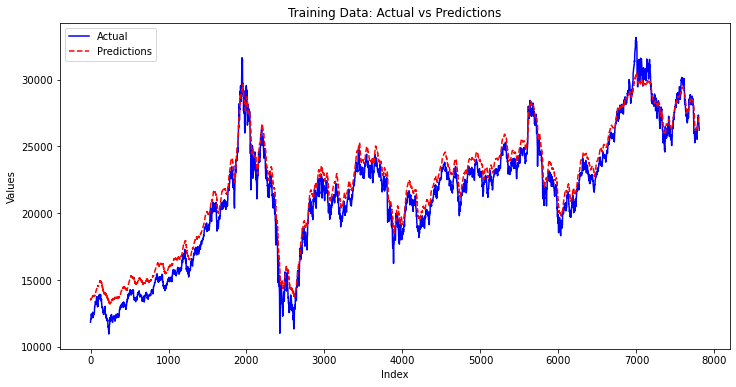

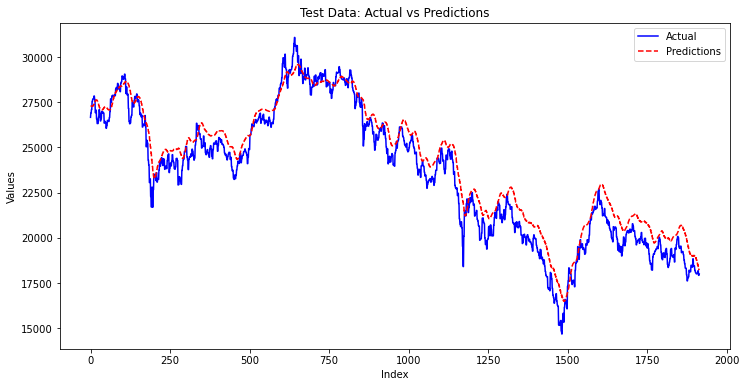

In [24]:
# Plotting for Training Data
plt.figure(figsize=(12,6))
plt.plot(valid_train_hsi.index.to_numpy(), valid_train_hsi['Adj Close'].to_numpy(), label='Actual', color='blue')
plt.plot(valid_train_hsi.index.to_numpy(), valid_train_hsi['Predictions'].to_numpy(), label='Predictions', color='red', linestyle='dashed')
plt.title('Training Data: Actual vs Predictions')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting for Test Data
plt.figure(figsize=(12,6))
plt.plot(valid_test_hsi.index.to_numpy(), valid_test_hsi['Adj Close'].to_numpy(), label='Actual', color='blue')
plt.plot(valid_test_hsi.index.to_numpy(), valid_test_hsi['Predictions'].to_numpy(), label='Predictions', color='red', linestyle='dashed')
plt.title('Test Data: Actual vs Predictions')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

#### 3.6 predicing the price of the next two days

In [25]:
# Extract the last 60 days of data (or whichever window size you used for the LSTM input) from your DataFrame
last_60_days_hsi = HSI_data1[-60:].copy()

# If you have other features, prepare them like you did during training.
# For simplicity, I am assuming that you only have 'Adj Close' as a feature.

# Scale 'Adj Close' with the scaler used during training
last_60_days_scaled_hsi = target_scaler_hsi.transform(last_60_days_hsi[['Adj Close']])
# Extract only the columns that were used in training the scaler
selected_features_hsi = train_features_hsi.columns.tolist()  

# Selecting only the relevant features and in the correct order from last_60_days
last_steps_hsi = last_60_days_hsi[selected_features_hsi].iloc[-step_hsi:]

# Scale the features
last_steps_scaled_hsi = feature_scaler_hsi.transform(last_steps_hsi)

# Reshape to the input shape (1, step, num_features)
X_test_hsi = np.array(last_steps_scaled_hsi).reshape(1, step_hsi, -1)   # -1 here will automatically consider the number of features.

# Predict the scaled value for the next day
predicted_scaled_value_hsi = model_hsi.predict(X_test_hsi)

# Inverse transform the predicted scaled value to get the actual predicted price
predicted_price_hsi = target_scaler_hsi.inverse_transform(predicted_scaled_value_hsi)

# Print the predicted price
print(predicted_price_hsi)

1/1 [==============================] - 0s 29ms/step
[[18009.664 18032.996]]


In [26]:
#this data is for purpose of pairs trading 
# Get the last date in the DataFrame and compute the next date
last_date_hsi = HSI_data1.index[-1]  # Assuming the index of your DataFrame is the date

# Initialize an empty DataFrame to store the predicted prices and their corresponding dates
predicted_data_hsi = pd.DataFrame(columns=['Adj Close'])

# Loop through the predicted prices and generate the corresponding dates
for i, price in enumerate(predicted_price_hsi[0]):
    # Compute the next date
    next_date_hsi = last_date_hsi + pd.Timedelta(days=(i + 1))  # i+1 to start from the next day
    
    # Append the predicted price and its corresponding date to the predicted_data_hsi DataFrame
    predicted_data_hsi.loc[next_date_hsi] = price

# Concatenate the new DataFrame with the original one
HSI_data1_new = pd.concat([HSI_data1, predicted_data_hsi], axis=0)

# Display the newly created DataFrame
print(HSI_data1_new.tail(len(predicted_price_hsi[0]) + 2))  # Display the last few rows including the new ones

                    Open          High           Low         Close     Adj Close  Rolling_Mean  \
2023-09-18  18069.039062  18114.820312  17894.810547  17930.550781  17930.550781  18053.787109   
2023-09-19  17942.070312  18004.740234  17832.300781  17997.169922  17997.169922  18036.870443   
2023-09-20           NaN           NaN           NaN           NaN  18009.664062           NaN   
2023-09-21           NaN           NaN           NaN           NaN  18032.996094           NaN   

                momentum           ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  
2023-09-18  17929.550781  18070.713170     18182.890625     18047.919922      15182.370891  
2023-09-19  17996.169922  18041.441685     17930.550781     18182.890625      14934.709353  
2023-09-20           NaN           NaN              NaN              NaN               NaN  
2023-09-21           NaN           NaN              NaN              NaN               NaN  


### 4.Data Engineering, Machine Learning and Price Prediction for STI

STI follows the exact step of HSI to main consistency

#### 4.1 Candlestick charts of STI

In [27]:
##Candlestick charts of STI
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=STI_data.index,
                                      open=STI_data['Open'],
                                      high=STI_data['High'],
                                      low=STI_data['Low'],
                                      close=STI_data['Close'])])

fig.update_layout(title='STI Price History',
                  xaxis_title='Date',
                  yaxis_title='Price USD',
                  xaxis_rangeslider_visible=True)  # You might want to set this to True if you want a rangeslider

fig.show()

#### 4.2 Data Feature Engineering: Creating features

In [28]:
#Calculate Volume Difference, Adj Close Dif, Simple Moving Average and Exponential Moving Average
STI_data['Vol Dif'] = STI_data['Volume'].diff()
STI_data['Adj Dif'] = STI_data['Adj Close'].diff()
STI_data['SMA'] = STI_data['Adj Close'].rolling(window=20).mean()
STI_data['EMA'] = STI_data['Adj Close'].ewm(span=20, adjust=False).mean()

# Calculate APO (Absolute Price Oscillator) 
short_ema = STI_data['Adj Close'].ewm(span=12, adjust=False).mean()
long_ema = STI_data['Adj Close'].ewm(span=26, adjust=False).mean()
STI_data['APO'] = short_ema - long_ema

# Calculate Bollinger Bands
STI_data['20_day_SMA'] = STI_data['Adj Close'].rolling(window=20).mean()
STI_data['2_std_dev'] = STI_data['Adj Close'].rolling(window=20).std()
STI_data['Bollinger_upper'] = STI_data['20_day_SMA'] + (STI_data['2_std_dev']*2)
STI_data['Bollinger_lower'] = STI_data['20_day_SMA'] - (STI_data['2_std_dev']*2)

#Calculate Rolling Mean
window_size = 3  
STI_data['Rolling_Mean'] = STI_data['Adj Close'].rolling(window=window_size).mean()

#Calculate Rate of change 
STI_data['ROC'] = STI_data['Adj Close'].pct_change(periods=1) * 100  

#Calculate mean of the day
STI_data['day_mean'] = (STI_data['High'] - STI_data['Low']) / 2

#Calculate return against the previous day

STI_data['returns'] = np.log(STI_data.Close.pct_change() + 1)

#Creating Lag_1 to Lag_5 which holds the return value 1 day, 2 day, 3 day, 4 day and 5 days ago each
def lagit(STI_data, lags):
    names = []
    for i in range(1, lags + 1):
        STI_data['Lag_'+str(i)] = STI_data['returns'].shift(i)
        names.append('Lag_'+str(i))
    return names
lagnames = lagit(STI_data, 5)

# Create Momentum, moving average of 7 days and moving average of 21 days
STI_data['momentum'] = STI_data['Adj Close']-1
STI_data['ma7'] = STI_data['Adj Close'].rolling(window=7).mean()
STI_data['ma21'] = STI_data['Adj Close'].rolling(window=21).mean()

#Creating Adj Close_lag_1, Adj Close_lag_2, Adj Close_lag_3 holding the past one day, past 2 day and past 3 days value as 
look_back = 3  # for example, create new features with values from 3 days ago
for col in ['Adj Close']:  # and other relevant columns
    for i in range(1, look_back + 1):
        STI_data[f'{col}_lag_{i}'] = STI_data[col].shift(i)
        
# Calculate Relative Strength Index
def compute_rsi(data, window=14):
    delta = data.diff()
    delta = delta[1:]
    
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

STI_data['RSI'] = compute_rsi(STI_data['Adj Close'])

#Calculate Moving average Convergence Divergence
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

STI_data['MACD'], STI_data['Signal_Line'] = compute_macd(STI_data['Adj Close'])

C:\Users\terra\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\terra\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\terra\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\terra\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



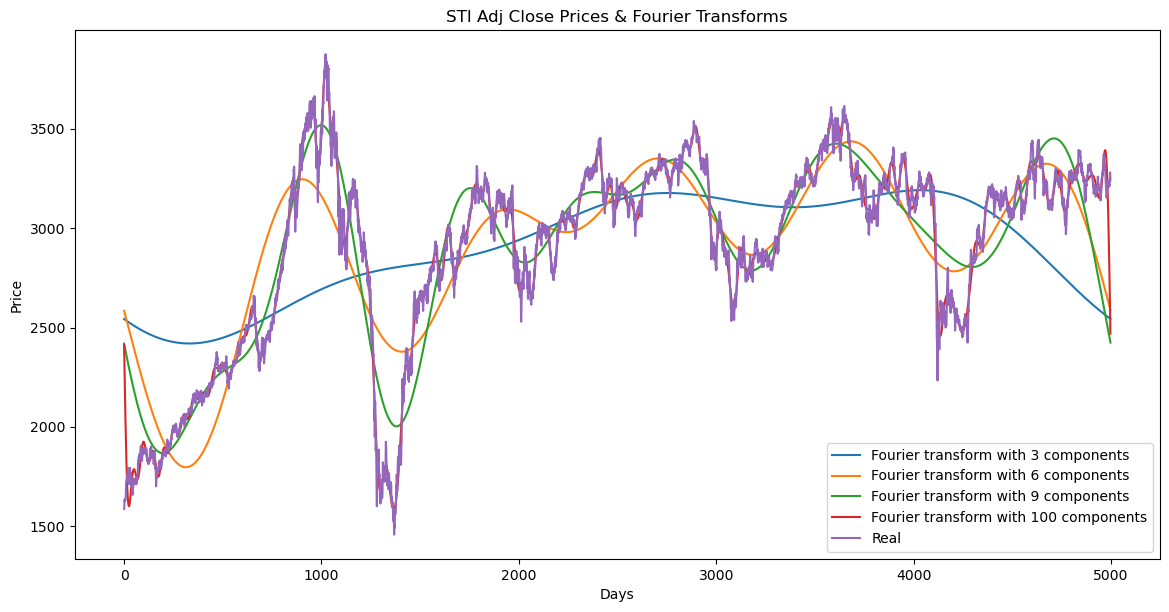

In [29]:
#Fourier Transforms
data_FT = STI_data[['Adj Close']].copy()
data_FT.reset_index(inplace=True)  # Resetting the index to get the Date column

close_fft = np.fft.fft(np.asarray(data_FT['Adj Close'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10 = np.copy(fft_list)
    fft_list_m10[num_:-num_] = 0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))

plt.plot(data_FT['Adj Close'], label='Real')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('STI Adj Close Prices & Fourier Transforms')
plt.legend()
plt.show()

# Keep the 100 componets one as features as it moves the best with the real data
num_components = 100
fft_list_m10 = np.copy(fft_list)
fft_list_m10[num_components:-num_components] = 0
denoised_data = np.fft.ifft(fft_list_m10)
STI_data['Fourier_Denoised'] = denoised_data.real 

In [30]:
#check the feartures are created 
STI_data.head(30)

Open         High          Low        Close    Adj Close     Volume  \
Date                                                                                     
2003-09-22  1590.069946  1597.989990  1574.479980  1586.630005  1586.630005  138267200   
2003-09-23  1585.989990  1594.829956  1582.619995  1588.359985  1588.359985  134698000   
2003-09-24  1593.939941  1634.030029  1593.349976  1634.030029  1634.030029  180208800   
2003-09-25  1618.400024  1647.359985  1614.010010  1629.819946  1629.819946  194266200   
2003-09-26  1630.939941  1632.959961  1622.020020  1627.540039  1627.540039  126160200   
2003-09-29  1627.859985  1634.579956  1621.829956  1628.709961  1628.709961  112266400   
2003-09-30  1635.969971  1641.890015  1627.420044  1630.800049  1630.800049  150861200   
2003-10-01  1621.060059  1632.150024  1621.020020  1630.719971  1630.719971  105033400   
2003-10-02  1647.739990  1656.250000  1643.560059  1644.010010  1644.010010  185054000   
2003-10-03  1655.209961  1681.849976  1655.209961  1670.300049  1670.300049  279712800   
2003-10-06  1688.859985  1726.130005  1688.150024  1717.890015  1717.890015  392854800   
2003-10-07  1726.910034  1745.420044  1705.900024  1722.099976  1722.099976  235316200   
2003-10-08  1730.880005  1742.229980  1721.500000  1733.910034  1733.910034  258162800   
2003-10-09  1734.030029  1742.699951  1727.739990  1738.119995  1738.119995  206822800   
2003-10-10  1747.520020  1760.770020  1744.839966  1746.040039  1746.040039  192486400   
2003-10-13  1746.319946  1751.729980  1732.349976  1750.780029  1750.780029  186929000   
2003-10-14  1757.709961  1764.130005  1728.060059  1730.729980  1730.729980  251716600   
2003-10-15  1736.030029  1751.459961  1729.979980  1748.959961  1748.959961  156127200   
2003-10-16  1745.219971  1754.520020  1737.040039  1754.189941  1754.189941  118325200   
2003-10-17  1760.819946  1776.839966  1755.969971  1772.180054  1772.180054  167476200   
2003-10-20  1766.420044  1787.869995  1764.959961  1780.239990  1780.239990  144714800   
2003-10-21  1794.339966  1804.949951  1787.880005  1792.859985  1792.859985  191704600   
2003-10-22  1795.719971  1801.709961  1771.260010  1771.260010  1771.260010  196796600   
2003-10-23  1759.859985  1761.709961  1720.069946  1732.959961  1732.959961  230810400   
2003-10-27  1732.569946  1732.569946  1709.150024  1712.619995  1712.619995  149529400   
2003-10-28  1718.410034  1740.010010  1718.410034  1736.099976  1736.099976  150304000   
2003-10-29  1760.229980  1762.890015  1722.290039  1722.290039  1722.290039  223432400   
2003-10-30  1735.569946  1735.709961  1702.180054  1715.300049  1715.300049  226945200   
2003-10-31  1721.920044  1727.459961  1707.680054  1723.709961  1723.709961  142664200   
2003-11-03  1731.770020  1765.390015  1729.329956  1760.810059  1760.810059  149942000   

                Vol Dif    Adj Dif          SMA          EMA        APO   20_day_SMA  2_std_dev  \
Date                                                                                              
2003-09-22          NaN        NaN          NaN  1586.630005   0.000000          NaN        NaN   
2003-09-23   -3569200.0   1.729980          NaN  1586.794765   0.138004          NaN        NaN   
2003-09-24   45510800.0  45.670044          NaN  1591.293362   3.887749          NaN        NaN   
2003-09-25   14057400.0  -4.210083          NaN  1594.962560   6.445431          NaN        NaN   
2003-09-26  -68106000.0  -2.279907          NaN  1598.065177   8.193988          NaN        NaN   
2003-09-29  -13893800.0   1.169922          NaN  1600.983728   9.563888          NaN        NaN   
2003-09-30   38594800.0   2.090088          NaN  1603.823378  10.694912          NaN        NaN   
2003-10-01  -45827800.0  -0.080078          NaN  1606.384958  11.452775          NaN        NaN   
2003-10-02   80020600.0  13.290039          NaN  1609.968296  12.976200          NaN        NaN   
2003-10-03   94658800.0  26.290039          NaN  

In [32]:
STI_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4998 entries, 2003-09-22 to 2023-09-19
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              4998 non-null   float64
 1   High              4998 non-null   float64
 2   Low               4998 non-null   float64
 3   Close             4998 non-null   float64
 4   Adj Close         4998 non-null   float64
 5   Volume            4998 non-null   int64  
 6   Vol Dif           4997 non-null   float64
 7   Adj Dif           4997 non-null   float64
 8   SMA               4979 non-null   float64
 9   EMA               4998 non-null   float64
 10  APO               4998 non-null   float64
 11  20_day_SMA        4979 non-null   float64
 12  2_std_dev         4979 non-null   float64
 13  Bollinger_upper   4979 non-null   float64
 14  Bollinger_lower   4979 non-null   float64
 15  Rolling_Mean      4996 non-null   float64
 16  ROC               4997 n

As we are using span = 20, the first 19 rows of SMA,20_day_SMA, 2_std_dev, Bollinger_upper and Bollinger_lower are missing

Missing data cannot be used to do machine learning 

We will only keep the data from row 20 and name the data STI_data1

In [40]:
STI_data1 = STI_data.iloc[20:]

In [41]:
#drop the features as HSI does
STI_data1 = STI_data1.drop(['Adj Close_lag_3', 'Bollinger_upper', 'MACD', 'EMA', 'APO', 'Vol Dif', 'Lag_2', 'Volume', 'RSI', 
    'Bollinger_lower', 'Signal_Line', 'Lag_4', 'ROC', 'Adj Dif', 'Lag_1', '2_std_dev', 'ma21', 'returns', 'Lag_3', 'day_mean', 
    'Lag_5', '20_day_SMA', 'SMA'], axis=1)

In [42]:
#to chck we drop successfully
STI_data1.head()

Open         High          Low        Close    Adj Close  Rolling_Mean  \
Date                                                                                        
2003-10-20  1766.420044  1787.869995  1764.959961  1780.239990  1780.239990   1768.869995   
2003-10-21  1794.339966  1804.949951  1787.880005  1792.859985  1792.859985   1781.760010   
2003-10-22  1795.719971  1801.709961  1771.260010  1771.260010  1771.260010   1781.453328   
2003-10-23  1759.859985  1761.709961  1720.069946  1732.959961  1732.959961   1765.693319   
2003-10-27  1732.569946  1732.569946  1709.150024  1712.619995  1712.619995   1738.946655   

               momentum          ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  
Date                                                                                      
2003-10-20  1779.239990  1754.731428      1772.180054      1754.189941       1625.781897  
2003-10-21  1791.859985  1761.419992      1780.239990      1772.180054       1615.502875  
2003-10-22  1770.260010  1764.345703      1792.859985      1780.239990       1607.976024  
2003-10-23  1731.959961  1764.664272      1771.260010      1792.859985       1603.067672  
2003-10-27  1711.619995  1759.472848      1732.959961      1771.260010       1600.625996

#### 4.3 Machine Learning Steps for STI

In [43]:
# 80-20 split for train and test data
train_data_size_sti = int(len(STI_data1) * 0.8)
train_data_sti = STI_data1.iloc[:train_data_size_sti]
test_data_sti = STI_data1.iloc[train_data_size_sti:]

from sklearn.preprocessing import MinMaxScaler

# Separate features and target
train_features_sti = train_data_sti.drop('Adj Close', axis=1)
train_target_sti = train_data_sti[['Adj Close']]
test_features_sti = test_data_sti.drop('Adj Close', axis=1)  # Corrected here
test_target_sti = test_data_sti[['Adj Close']]

# Initialize a scaler for the features and a separate scaler for the target
feature_scaler_sti = MinMaxScaler(feature_range=(0, 1))
target_scaler_sti = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the training data
train_features_scaled_sti = feature_scaler_sti.fit_transform(train_features_sti)  # Corrected here
train_target_scaled_sti = target_scaler_sti.fit_transform(train_target_sti)  # Corrected here

# Transform the test data
test_features_scaled_sti = feature_scaler_sti.transform(test_features_sti)  # Corrected here
test_target_scaled_sti = target_scaler_sti.transform(test_target_sti)  # Corrected here

#### The codes below is using Optuna to find out the best parameters to optimize the model
### The codes below take around 10 hours to run

In [ ]:
# # Define the create_sequences function before running the Optuna optimization
# def create_sequences_sti(features, target, step, horizon):
#     x, y = [], []
#     for i in range(len(features) - (step + horizon) + 1):
#         x.append(features[i:(i + step)])
#         y.append(target[i + step:i + step + horizon])
#     return np.array(x), np.array(y)

# # Define the Optuna objective function for STI
# def objective_sti(trial):
#     # Define search space
#     step = trial.suggest_int("step", 10, 60)
#     horizon = trial.suggest_int("horizon", 1, 5)
#     lstm_units = trial.suggest_int("lstm_units", 32, 64)
#     dense_units = trial.suggest_int("dense_units", 16, 64)
#     epochs = trial.suggest_int("epochs", 10, 100)
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
#     learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
#     l1_regularizer = trial.suggest_float("l1_regularizer", 1e-4, 1e-2, log=True)  # Suggesting a regularization factor
    
#     x_train_sti, y_train_sti = create_sequences_sti(train_features_scaled_sti, train_target_scaled_sti, step, horizon)
#     x_test_sti, y_test_sti = create_sequences_sti(test_features_scaled_sti, test_target_scaled_sti, step, horizon)
    
#     model_sti = Sequential()
#     model_sti.add(LSTM(lstm_units, return_sequences=True, input_shape=(x_train_sti.shape[1], x_train_sti.shape[2]), 
#                        kernel_regularizer=regularizers.l1(l1_regularizer)))  # Applying L1 regularization to LSTM layer
#     model_sti.add(LSTM(lstm_units, return_sequences=False, kernel_regularizer=regularizers.l1(l1_regularizer)))  # Applying L1 regularization to LSTM layer
#     model_sti.add(Dense(dense_units, kernel_regularizer=regularizers.l1(l1_regularizer)))  # Applying L1 regularization to Dense layer
#     model_sti.add(Dense(horizon, kernel_regularizer=regularizers.l1(l1_regularizer)))  # Applying L1 regularization to Dense layer
#     optimizer_sti = Adam(learning_rate=learning_rate)
#     model_sti.compile(optimizer=optimizer_sti, loss='mean_squared_error')
    
#     history_sti = model_sti.fit(x_train_sti, y_train_sti, validation_data=(x_test_sti, y_test_sti), epochs=epochs, batch_size=batch_size, verbose=0)
#     val_loss_sti = history_sti.history['val_loss'][-1]
#     return val_loss_sti

# # Running the optimization for STI
# study_sti = optuna.create_study(direction="minimize")
# study_sti.optimize(objective_sti, n_trials=100)

# best_params_sti = study_sti.best_params
# best_rmse_sti = np.sqrt(study_sti.best_value)

# print(f"Best RMSE for STI: {best_rmse_sti} with params={best_params_sti}")

In [ ]:
# # Get all completed trials in the study.
# all_trials = study_sti.get_trials(deepcopy=False)

# # Filter the completed trials which have an RMSE value and sort them based on RMSE.
# completed_trials = [trial for trial in all_trials if trial.state == optuna.trial.TrialState.COMPLETE]
# sorted_trials = sorted(completed_trials, key=lambda trial: trial.value)

# # Print the 2nd to 5th best trials.
# for i in range(0, min(100, len(sorted_trials))):  
#     trial = sorted_trials[i]
#     print(f"{i + 1}th Best RMSE: {np.sqrt(trial.value)} with params={trial.params}")

#### The results from Optuna is printed below for reference

In [ ]:
# 1th Best RMSE: 0.03129198747945631 with params={'step': 11, 'horizon': 1, 'lstm_units': 40, 'dense_units': 31, 'epochs': 73, 'batch_size': 16, 'learning_rate': 0.003041262689876142, 'l1_regularizer': 0.00011319228831833978}
# 2th Best RMSE: 0.032023312730818335 with params={'step': 13, 'horizon': 1, 'lstm_units': 38, 'dense_units': 24, 'epochs': 65, 'batch_size': 16, 'learning_rate': 0.00212457870849776, 'l1_regularizer': 0.00011583521505583351}
# 3th Best RMSE: 0.03216555086891429 with params={'step': 10, 'horizon': 1, 'lstm_units': 38, 'dense_units': 26, 'epochs': 64, 'batch_size': 16, 'learning_rate': 0.0021968428923445876, 'l1_regularizer': 0.00012466767109227349}
# 4th Best RMSE: 0.03217635072155787 with params={'step': 13, 'horizon': 1, 'lstm_units': 40, 'dense_units': 23, 'epochs': 74, 'batch_size': 16, 'learning_rate': 0.0025928258581627574, 'l1_regularizer': 0.00011469394480009043}
# 5th Best RMSE: 0.03233099402561028 with params={'step': 10, 'horizon': 1, 'lstm_units': 39, 'dense_units': 23, 'epochs': 63, 'batch_size': 16, 'learning_rate': 0.0023400708106635186, 'l1_regularizer': 0.00011295878335132854}
# 6th Best RMSE: 0.03245435389169636 with params={'step': 10, 'horizon': 1, 'lstm_units': 39, 'dense_units': 23, 'epochs': 64, 'batch_size': 16, 'learning_rate': 0.0024627193417117704, 'l1_regularizer': 0.0001238102309775142}
# 7th Best RMSE: 0.03247163348191638 with params={'step': 10, 'horizon': 1, 'lstm_units': 38, 'dense_units': 27, 'epochs': 64, 'batch_size': 16, 'learning_rate': 0.0023638982338675665, 'l1_regularizer': 0.00012082137064227738}
# 8th Best RMSE: 0.03267113947633336 with params={'step': 10, 'horizon': 1, 'lstm_units': 39, 'dense_units': 24, 'epochs': 63, 'batch_size': 16, 'learning_rate': 0.002338959961849147, 'l1_regularizer': 0.00011840580827318666}
# 9th Best RMSE: 0.032758040164444786 with params={'step': 10, 'horizon': 1, 'lstm_units': 39, 'dense_units': 23, 'epochs': 62, 'batch_size': 16, 'learning_rate': 0.002299036068396151, 'l1_regularizer': 0.00011486435595548583}
# 10th Best RMSE: 0.03275927508453213 with params={'step': 11, 'horizon': 1, 'lstm_units': 39, 'dense_units': 24, 'epochs': 62, 'batch_size': 16, 'learning_rate': 0.002245776877979501, 'l1_regularizer': 0.00011633721322108148}
# 11th Best RMSE: 0.03329789437228799 with params={'step': 10, 'horizon': 1, 'lstm_units': 39, 'dense_units': 23, 'epochs': 63, 'batch_size': 16, 'learning_rate': 0.0023382929518719294, 'l1_regularizer': 0.00011627082156732956}
# 12th Best RMSE: 0.033326742814013655 with params={'step': 13, 'horizon': 1, 'lstm_units': 38, 'dense_units': 22, 'epochs': 64, 'batch_size': 16, 'learning_rate': 0.0036404543897404747, 'l1_regularizer': 0.00011296702118185838}
# 13th Best RMSE: 0.033346710665548764 with params={'step': 10, 'horizon': 1, 'lstm_units': 39, 'dense_units': 24, 'epochs': 62, 'batch_size': 16, 'learning_rate': 0.00231609141241135, 'l1_regularizer': 0.00011211764080902189}
# 14th Best RMSE: 0.03337917218400923 with params={'step': 13, 'horizon': 1, 'lstm_units': 40, 'dense_units': 31, 'epochs': 73, 'batch_size': 16, 'learning_rate': 0.0026037238297932923, 'l1_regularizer': 0.00013591519785829248}
# 15th Best RMSE: 0.033704903566503415 with params={'step': 11, 'horizon': 1, 'lstm_units': 36, 'dense_units': 16, 'epochs': 45, 'batch_size': 16, 'learning_rate': 0.0042283149837817205, 'l1_regularizer': 0.0001209165615655727}
# 16th Best RMSE: 0.03398022694868389 with params={'step': 17, 'horizon': 1, 'lstm_units': 33, 'dense_units': 19, 'epochs': 68, 'batch_size': 16, 'learning_rate': 0.0022448703124098154, 'l1_regularizer': 0.0001552927839715525}
# 17th Best RMSE: 0.034310114171879444 with params={'step': 11, 'horizon': 1, 'lstm_units': 37, 'dense_units': 28, 'epochs': 65, 'batch_size': 16, 'learning_rate': 0.003001449560913043, 'l1_regularizer': 0.00010715453838708915}
# 18th Best RMSE: 0.03438365397922042 with params={'step': 14, 'horizon': 1, 'lstm_units': 33, 'dense_units': 19, 'epochs': 68, 'batch_size': 16, 'learning_rate': 0.0025672695234076857, 'l1_regularizer': 0.00011709101991471851}
# 19th Best RMSE: 0.03448821195024481 with params={'step': 12, 'horizon': 1, 'lstm_units': 42, 'dense_units': 23, 'epochs': 59, 'batch_size': 16, 'learning_rate': 0.0017366185034758657, 'l1_regularizer': 0.00011245609853500864}
# 20th Best RMSE: 0.03466988444072436 with params={'step': 10, 'horizon': 1, 'lstm_units': 40, 'dense_units': 23, 'epochs': 60, 'batch_size': 16, 'learning_rate': 0.002589696132190712, 'l1_regularizer': 0.00011527614395101089}
# 21th Best RMSE: 0.0348992690902531 with params={'step': 13, 'horizon': 1, 'lstm_units': 37, 'dense_units': 21, 'epochs': 64, 'batch_size': 16, 'learning_rate': 0.003207327412974857, 'l1_regularizer': 0.00013545749694771666}
# 22th Best RMSE: 0.0350144959024733 with params={'step': 12, 'horizon': 1, 'lstm_units': 36, 'dense_units': 24, 'epochs': 62, 'batch_size': 16, 'learning_rate': 0.0020104548993934933, 'l1_regularizer': 0.00012814657714967843}
# 23th Best RMSE: 0.03558696383138346 with params={'step': 10, 'horizon': 1, 'lstm_units': 41, 'dense_units': 25, 'epochs': 70, 'batch_size': 16, 'learning_rate': 0.0018894791766263543, 'l1_regularizer': 0.00013839061302332257}
# 24th Best RMSE: 0.036039786829554825 with params={'step': 16, 'horizon': 1, 'lstm_units': 34, 'dense_units': 18, 'epochs': 58, 'batch_size': 16, 'learning_rate': 0.0038387737587162085, 'l1_regularizer': 0.00015316147405634902}
# 25th Best RMSE: 0.036141067605765596 with params={'step': 38, 'horizon': 2, 'lstm_units': 46, 'dense_units': 26, 'epochs': 84, 'batch_size': 16, 'learning_rate': 0.0010554945520356764, 'l1_regularizer': 0.00012244378990846434}
# 26th Best RMSE: 0.03616425235393132 with params={'step': 16, 'horizon': 1, 'lstm_units': 35, 'dense_units': 19, 'epochs': 68, 'batch_size': 16, 'learning_rate': 0.002807337752497331, 'l1_regularizer': 0.00015669241947239253}
# 27th Best RMSE: 0.03617472891486432 with params={'step': 16, 'horizon': 2, 'lstm_units': 52, 'dense_units': 26, 'epochs': 97, 'batch_size': 16, 'learning_rate': 0.0015054719727386767, 'l1_regularizer': 0.00014765054495558238}
# 28th Best RMSE: 0.036361446211685064 with params={'step': 12, 'horizon': 1, 'lstm_units': 37, 'dense_units': 27, 'epochs': 66, 'batch_size': 16, 'learning_rate': 0.0021977015567338286, 'l1_regularizer': 0.00010030874133001639}
# 29th Best RMSE: 0.03659017688320197 with params={'step': 27, 'horizon': 3, 'lstm_units': 53, 'dense_units': 47, 'epochs': 88, 'batch_size': 16, 'learning_rate': 0.0007600833979839925, 'l1_regularizer': 0.00010095059467400926}
# 30th Best RMSE: 0.03674316089414665 with params={'step': 10, 'horizon': 1, 'lstm_units': 40, 'dense_units': 24, 'epochs': 61, 'batch_size': 16, 'learning_rate': 0.0023530871061785163, 'l1_regularizer': 0.00011175466798440793}
# 31th Best RMSE: 0.037000553037160704 with params={'step': 41, 'horizon': 2, 'lstm_units': 50, 'dense_units': 40, 'epochs': 73, 'batch_size': 16, 'learning_rate': 0.0006960630669220524, 'l1_regularizer': 0.000146707863464339}
# 32th Best RMSE: 0.03709134962842624 with params={'step': 12, 'horizon': 1, 'lstm_units': 38, 'dense_units': 27, 'epochs': 61, 'batch_size': 16, 'learning_rate': 0.0024026066274590962, 'l1_regularizer': 0.00013616811008614955}
# 33th Best RMSE: 0.03745389988101222 with params={'step': 14, 'horizon': 1, 'lstm_units': 33, 'dense_units': 21, 'epochs': 46, 'batch_size': 16, 'learning_rate': 0.0028554852631196034, 'l1_regularizer': 0.00014965131791313543}
# 34th Best RMSE: 0.037889232437853575 with params={'step': 26, 'horizon': 3, 'lstm_units': 53, 'dense_units': 57, 'epochs': 94, 'batch_size': 32, 'learning_rate': 0.0013650977547672095, 'l1_regularizer': 0.00010239331301050602}
# 35th Best RMSE: 0.03793921544210443 with params={'step': 13, 'horizon': 1, 'lstm_units': 32, 'dense_units': 19, 'epochs': 68, 'batch_size': 16, 'learning_rate': 0.0027608462738535214, 'l1_regularizer': 0.00018037605498704004}
# 36th Best RMSE: 0.037967053123318585 with params={'step': 32, 'horizon': 2, 'lstm_units': 54, 'dense_units': 43, 'epochs': 79, 'batch_size': 16, 'learning_rate': 0.0021507590227841595, 'l1_regularizer': 0.0001079612959121066}
# 37th Best RMSE: 0.03805703509221508 with params={'step': 15, 'horizon': 1, 'lstm_units': 43, 'dense_units': 25, 'epochs': 48, 'batch_size': 16, 'learning_rate': 0.0017404463158729093, 'l1_regularizer': 0.00014554840208601876}
# 38th Best RMSE: 0.03805887042985225 with params={'step': 17, 'horizon': 1, 'lstm_units': 34, 'dense_units': 18, 'epochs': 57, 'batch_size': 16, 'learning_rate': 0.003101898645805821, 'l1_regularizer': 0.000166282375059306}
# 39th Best RMSE: 0.038070281185299315 with params={'step': 33, 'horizon': 2, 'lstm_units': 49, 'dense_units': 38, 'epochs': 76, 'batch_size': 16, 'learning_rate': 0.0007297933203770062, 'l1_regularizer': 0.00010304576853465513}
# 40th Best RMSE: 0.038165843110924254 with params={'step': 30, 'horizon': 2, 'lstm_units': 51, 'dense_units': 44, 'epochs': 79, 'batch_size': 16, 'learning_rate': 0.0009281041395997117, 'l1_regularizer': 0.0001841440964971448}
# 41th Best RMSE: 0.038262105005621175 with params={'step': 10, 'horizon': 1, 'lstm_units': 39, 'dense_units': 20, 'epochs': 56, 'batch_size': 16, 'learning_rate': 0.0034223069091550355, 'l1_regularizer': 0.00017314189498612905}
# 42th Best RMSE: 0.03836818944626337 with params={'step': 29, 'horizon': 2, 'lstm_units': 51, 'dense_units': 42, 'epochs': 63, 'batch_size': 16, 'learning_rate': 0.0003397382115894392, 'l1_regularizer': 0.00010117253786075096}
# 43th Best RMSE: 0.03849137137414794 with params={'step': 18, 'horizon': 2, 'lstm_units': 54, 'dense_units': 22, 'epochs': 90, 'batch_size': 16, 'learning_rate': 0.0008594021491738575, 'l1_regularizer': 0.0001511262978952648}
# 44th Best RMSE: 0.03901118842326252 with params={'step': 41, 'horizon': 2, 'lstm_units': 44, 'dense_units': 41, 'epochs': 72, 'batch_size': 16, 'learning_rate': 0.0018196492686848888, 'l1_regularizer': 0.00014235500682525972}
# 45th Best RMSE: 0.039429562739569234 with params={'step': 10, 'horizon': 2, 'lstm_units': 43, 'dense_units': 37, 'epochs': 81, 'batch_size': 16, 'learning_rate': 0.0006419753384908069, 'l1_regularizer': 0.00020482639864211874}
# 46th Best RMSE: 0.04000196104485908 with params={'step': 18, 'horizon': 3, 'lstm_units': 53, 'dense_units': 58, 'epochs': 93, 'batch_size': 32, 'learning_rate': 0.0007249355392710126, 'l1_regularizer': 0.00010111381514120893}
# 47th Best RMSE: 0.040102611677772196 with params={'step': 12, 'horizon': 2, 'lstm_units': 45, 'dense_units': 25, 'epochs': 82, 'batch_size': 16, 'learning_rate': 0.001054075172013596, 'l1_regularizer': 0.00018888496318048107}
# 48th Best RMSE: 0.040121769383427625 with params={'step': 36, 'horizon': 3, 'lstm_units': 54, 'dense_units': 34, 'epochs': 75, 'batch_size': 16, 'learning_rate': 0.0010568737063100955, 'l1_regularizer': 0.00013405063078038054}
# 49th Best RMSE: 0.04038692905008952 with params={'step': 23, 'horizon': 3, 'lstm_units': 53, 'dense_units': 47, 'epochs': 94, 'batch_size': 32, 'learning_rate': 0.0005328488892493474, 'l1_regularizer': 0.00012263013664873593}
# 50th Best RMSE: 0.04039860004738333 with params={'step': 11, 'horizon': 1, 'lstm_units': 41, 'dense_units': 27, 'epochs': 53, 'batch_size': 16, 'learning_rate': 0.002992903700019858, 'l1_regularizer': 0.00021054317355946361}
# 51th Best RMSE: 0.04068899518727019 with params={'step': 32, 'horizon': 2, 'lstm_units': 49, 'dense_units': 42, 'epochs': 78, 'batch_size': 16, 'learning_rate': 0.0005702937233146623, 'l1_regularizer': 0.00013713746567950595}
# 52th Best RMSE: 0.04069131261302658 with params={'step': 31, 'horizon': 5, 'lstm_units': 39, 'dense_units': 32, 'epochs': 96, 'batch_size': 16, 'learning_rate': 0.0009103974956476689, 'l1_regularizer': 0.0001562830112293788}
# 53th Best RMSE: 0.04076089264581379 with params={'step': 59, 'horizon': 4, 'lstm_units': 56, 'dense_units': 45, 'epochs': 82, 'batch_size': 16, 'learning_rate': 0.0008203510750451804, 'l1_regularizer': 0.00010345095953091496}
# 54th Best RMSE: 0.041181926832590844 with params={'step': 10, 'horizon': 1, 'lstm_units': 39, 'dense_units': 23, 'epochs': 54, 'batch_size': 16, 'learning_rate': 0.0020638848012880288, 'l1_regularizer': 0.00012978624744338846}
# 55th Best RMSE: 0.04128380504011799 with params={'step': 24, 'horizon': 2, 'lstm_units': 51, 'dense_units': 49, 'epochs': 87, 'batch_size': 16, 'learning_rate': 0.0007374928041160028, 'l1_regularizer': 0.00020522519970679525}
# 56th Best RMSE: 0.04147323849772253 with params={'step': 60, 'horizon': 4, 'lstm_units': 64, 'dense_units': 46, 'epochs': 84, 'batch_size': 16, 'learning_rate': 0.0008189279962040775, 'l1_regularizer': 0.00010613852872754843}
# 57th Best RMSE: 0.04169012954468766 with params={'step': 14, 'horizon': 1, 'lstm_units': 38, 'dense_units': 25, 'epochs': 55, 'batch_size': 16, 'learning_rate': 0.0020351556015264292, 'l1_regularizer': 0.00017433820523691317}
# 58th Best RMSE: 0.04178560948516126 with params={'step': 36, 'horizon': 3, 'lstm_units': 57, 'dense_units': 61, 'epochs': 80, 'batch_size': 16, 'learning_rate': 0.0021300304898694412, 'l1_regularizer': 0.00012191749045999494}
# 59th Best RMSE: 0.04208221183806448 with params={'step': 16, 'horizon': 1, 'lstm_units': 34, 'dense_units': 21, 'epochs': 52, 'batch_size': 16, 'learning_rate': 0.004056462518009508, 'l1_regularizer': 0.00022764398429351608}
# 60th Best RMSE: 0.042746474257038154 with params={'step': 38, 'horizon': 2, 'lstm_units': 52, 'dense_units': 19, 'epochs': 84, 'batch_size': 16, 'learning_rate': 0.0014991834745446706, 'l1_regularizer': 0.00022986244405475656}
# 61th Best RMSE: 0.04278755727892131 with params={'step': 27, 'horizon': 3, 'lstm_units': 50, 'dense_units': 51, 'epochs': 88, 'batch_size': 32, 'learning_rate': 0.0014271099676557816, 'l1_regularizer': 0.00012499436946301304}
# 62th Best RMSE: 0.04295815396790802 with params={'step': 41, 'horizon': 3, 'lstm_units': 48, 'dense_units': 50, 'epochs': 59, 'batch_size': 16, 'learning_rate': 0.0006839138743321439, 'l1_regularizer': 0.00013739264232052805}
# 63th Best RMSE: 0.043175841737309824 with params={'step': 34, 'horizon': 4, 'lstm_units': 55, 'dense_units': 44, 'epochs': 84, 'batch_size': 16, 'learning_rate': 0.001405013457133829, 'l1_regularizer': 0.0001654167942352541}
# 64th Best RMSE: 0.04322227952545618 with params={'step': 33, 'horizon': 2, 'lstm_units': 49, 'dense_units': 36, 'epochs': 67, 'batch_size': 16, 'learning_rate': 0.002426415098028839, 'l1_regularizer': 0.00017531287687548027}
# 65th Best RMSE: 0.04328581615704393 with params={'step': 45, 'horizon': 3, 'lstm_units': 55, 'dense_units': 33, 'epochs': 67, 'batch_size': 16, 'learning_rate': 0.0017525439929040021, 'l1_regularizer': 0.0001737529522112474}
# 66th Best RMSE: 0.043345067363558205 with params={'step': 30, 'horizon': 1, 'lstm_units': 41, 'dense_units': 63, 'epochs': 76, 'batch_size': 16, 'learning_rate': 0.00249365885325751, 'l1_regularizer': 0.00024735377127943194}
# 67th Best RMSE: 0.043466723625637325 with params={'step': 39, 'horizon': 2, 'lstm_units': 54, 'dense_units': 29, 'epochs': 86, 'batch_size': 32, 'learning_rate': 0.0016214196288581281, 'l1_regularizer': 0.00020129015325411021}
# 68th Best RMSE: 0.04373316818899717 with params={'step': 32, 'horizon': 2, 'lstm_units': 60, 'dense_units': 43, 'epochs': 71, 'batch_size': 16, 'learning_rate': 0.0004008888618875498, 'l1_regularizer': 0.0001402656198063465}
# 69th Best RMSE: 0.04380165965943758 with params={'step': 45, 'horizon': 2, 'lstm_units': 51, 'dense_units': 45, 'epochs': 70, 'batch_size': 16, 'learning_rate': 0.0009374204420828757, 'l1_regularizer': 0.0001947477243789024}
# 70th Best RMSE: 0.04380166630389545 with params={'step': 48, 'horizon': 1, 'lstm_units': 50, 'dense_units': 22, 'epochs': 91, 'batch_size': 16, 'learning_rate': 0.0015925567023289998, 'l1_regularizer': 0.0002743253907602078}
# 71th Best RMSE: 0.04476896726653946 with params={'step': 25, 'horizon': 2, 'lstm_units': 49, 'dense_units': 30, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0011864518356818159, 'l1_regularizer': 0.0002591101230221378}
# 72th Best RMSE: 0.044833622675263224 with params={'step': 43, 'horizon': 3, 'lstm_units': 46, 'dense_units': 26, 'epochs': 27, 'batch_size': 16, 'learning_rate': 0.0012199877534498436, 'l1_regularizer': 0.00012494566444906977}
# 73th Best RMSE: 0.04532855403076447 with params={'step': 39, 'horizon': 4, 'lstm_units': 55, 'dense_units': 55, 'epochs': 87, 'batch_size': 32, 'learning_rate': 0.0019070797280135812, 'l1_regularizer': 0.0001627025276638524}
# 74th Best RMSE: 0.04546483654700933 with params={'step': 35, 'horizon': 3, 'lstm_units': 47, 'dense_units': 58, 'epochs': 97, 'batch_size': 64, 'learning_rate': 0.0012702297583252378, 'l1_regularizer': 0.00010025700259791056}
# 75th Best RMSE: 0.04556812987846747 with params={'step': 21, 'horizon': 1, 'lstm_units': 63, 'dense_units': 39, 'epochs': 75, 'batch_size': 32, 'learning_rate': 0.0034142797745909262, 'l1_regularizer': 0.00012335424860487293}
# 76th Best RMSE: 0.04586340196075552 with params={'step': 14, 'horizon': 1, 'lstm_units': 42, 'dense_units': 29, 'epochs': 71, 'batch_size': 64, 'learning_rate': 0.0032421548971987473, 'l1_regularizer': 0.00018964100347205538}
# 77th Best RMSE: 0.046150665987234496 with params={'step': 42, 'horizon': 2, 'lstm_units': 58, 'dense_units': 37, 'epochs': 63, 'batch_size': 32, 'learning_rate': 0.0011447080878295957, 'l1_regularizer': 0.00022092067150722278}
# 78th Best RMSE: 0.046972724256248176 with params={'step': 22, 'horizon': 3, 'lstm_units': 58, 'dense_units': 40, 'epochs': 36, 'batch_size': 32, 'learning_rate': 0.0009295794821088536, 'l1_regularizer': 0.0001100685145987155}
# 79th Best RMSE: 0.04763336208524483 with params={'step': 11, 'horizon': 1, 'lstm_units': 36, 'dense_units': 16, 'epochs': 43, 'batch_size': 16, 'learning_rate': 0.004313806043438604, 'l1_regularizer': 0.00027380473819178417}
# 80th Best RMSE: 0.047661449879577565 with params={'step': 28, 'horizon': 2, 'lstm_units': 47, 'dense_units': 59, 'epochs': 50, 'batch_size': 16, 'learning_rate': 0.0010398612893279464, 'l1_regularizer': 0.00016573961111491435}
# 81th Best RMSE: 0.05151016214355738 with params={'step': 50, 'horizon': 3, 'lstm_units': 53, 'dense_units': 39, 'epochs': 91, 'batch_size': 16, 'learning_rate': 0.00033486455036567874, 'l1_regularizer': 0.0003268560962385586}
# 82th Best RMSE: 0.052028707329021116 with params={'step': 28, 'horizon': 1, 'lstm_units': 46, 'dense_units': 53, 'epochs': 91, 'batch_size': 16, 'learning_rate': 0.0003559947523683115, 'l1_regularizer': 0.0006231070066970766}
# 83th Best RMSE: 0.053016749881634656 with params={'step': 38, 'horizon': 1, 'lstm_units': 37, 'dense_units': 55, 'epochs': 45, 'batch_size': 64, 'learning_rate': 0.003597803517322093, 'l1_regularizer': 0.00023694635171851068}
# 84th Best RMSE: 0.054184724828660144 with params={'step': 15, 'horizon': 1, 'lstm_units': 57, 'dense_units': 30, 'epochs': 94, 'batch_size': 32, 'learning_rate': 0.0002204321059561466, 'l1_regularizer': 0.0003071348314727384}
# 85th Best RMSE: 0.05546246378832743 with params={'step': 15, 'horizon': 4, 'lstm_units': 56, 'dense_units': 51, 'epochs': 96, 'batch_size': 16, 'learning_rate': 0.0014133808077371626, 'l1_regularizer': 0.00036561540438066433}
# 86th Best RMSE: 0.056388478722373146 with params={'step': 30, 'horizon': 4, 'lstm_units': 42, 'dense_units': 64, 'epochs': 77, 'batch_size': 16, 'learning_rate': 0.0005678176764061989, 'l1_regularizer': 0.0005473394592300679}
# 87th Best RMSE: 0.05954722637214483 with params={'step': 26, 'horizon': 3, 'lstm_units': 59, 'dense_units': 35, 'epochs': 88, 'batch_size': 64, 'learning_rate': 0.0004295948129432024, 'l1_regularizer': 0.00025468125831335674}
# 88th Best RMSE: 0.06001657861658599 with params={'step': 20, 'horizon': 3, 'lstm_units': 32, 'dense_units': 28, 'epochs': 24, 'batch_size': 16, 'learning_rate': 0.0013037571656095471, 'l1_regularizer': 0.00036607119225356993}
# 89th Best RMSE: 0.06131034231836869 with params={'step': 26, 'horizon': 2, 'lstm_units': 41, 'dense_units': 24, 'epochs': 11, 'batch_size': 32, 'learning_rate': 0.005204611818267837, 'l1_regularizer': 0.00015994890847895505}
# 90th Best RMSE: 0.061386588196914504 with params={'step': 20, 'horizon': 1, 'lstm_units': 52, 'dense_units': 16, 'epochs': 100, 'batch_size': 64, 'learning_rate': 0.0019518661578289463, 'l1_regularizer': 0.0004490930994951408}
# 91th Best RMSE: 0.06266699772499612 with params={'step': 12, 'horizon': 1, 'lstm_units': 41, 'dense_units': 28, 'epochs': 65, 'batch_size': 64, 'learning_rate': 0.0018093013016581914, 'l1_regularizer': 0.0001848263539516233}
# 92th Best RMSE: 0.06517512706100193 with params={'step': 13, 'horizon': 2, 'lstm_units': 35, 'dense_units': 17, 'epochs': 61, 'batch_size': 32, 'learning_rate': 0.00019789372157308314, 'l1_regularizer': 0.00011144549495241301}
# 93th Best RMSE: 0.07185236908867551 with params={'step': 52, 'horizon': 1, 'lstm_units': 45, 'dense_units': 53, 'epochs': 51, 'batch_size': 16, 'learning_rate': 0.0025332919391720925, 'l1_regularizer': 0.0008091764700764164}
# 94th Best RMSE: 0.10414342074494132 with params={'step': 37, 'horizon': 5, 'lstm_units': 35, 'dense_units': 63, 'epochs': 91, 'batch_size': 64, 'learning_rate': 0.005446341430579911, 'l1_regularizer': 0.0011293482430755166}
# 95th Best RMSE: 0.11668873584222617 with params={'step': 45, 'horizon': 1, 'lstm_units': 52, 'dense_units': 53, 'epochs': 56, 'batch_size': 64, 'learning_rate': 0.00790721163980517, 'l1_regularizer': 0.0008356528763251252}
# 96th Best RMSE: 0.11805035503314674 with params={'step': 11, 'horizon': 3, 'lstm_units': 53, 'dense_units': 38, 'epochs': 21, 'batch_size': 16, 'learning_rate': 0.00019855498622985785, 'l1_regularizer': 0.003134069238270948}
# 97th Best RMSE: 0.17444650085658112 with params={'step': 19, 'horizon': 5, 'lstm_units': 61, 'dense_units': 19, 'epochs': 17, 'batch_size': 64, 'learning_rate': 0.0004715470291966746, 'l1_regularizer': 0.0001198740889921615}
# 98th Best RMSE: 0.1983962658220447 with params={'step': 54, 'horizon': 1, 'lstm_units': 46, 'dense_units': 48, 'epochs': 100, 'batch_size': 16, 'learning_rate': 0.001625633685416908, 'l1_regularizer': 0.008586870153857862}
# 99th Best RMSE: 0.20479333267297453 with params={'step': 38, 'horizon': 5, 'lstm_units': 38, 'dense_units': 24, 'epochs': 17, 'batch_size': 64, 'learning_rate': 0.00047876609294922676, 'l1_regularizer': 0.00040484112283455787}
# 100th Best RMSE: 0.4414024859242597 with params={'step': 14, 'horizon': 2, 'lstm_units': 60, 'dense_units': 34, 'epochs': 14, 'batch_size': 64, 'learning_rate': 0.00010829544203149884, 'l1_regularizer': 0.00029041288854527553}

In [44]:
# Follow the parameters found in the best model
step_sti = 38
horizon_sti = 2
# Define l1_regularizer value based on the result from Optuna
l1_regularizer = 0.00012

# Function to create sequences for STI
def create_sequences_sti(features, target, step, horizon):
    x, y = [], []
    for i in range(len(features) - (step + horizon) + 1):
        x.append(features[i:(i + step)])
        y.append(target[i + step:i + step + horizon])
    return np.array(x), np.array(y)

# Create sequences for training data
x_train_sti, y_train_sti = create_sequences_sti(train_features_scaled_sti, train_target_scaled_sti, step_sti, horizon_sti)

# Create sequences for test data
x_test_sti, y_test_sti = create_sequences_sti(test_features_scaled_sti, test_target_scaled_sti, step_sti, horizon_sti)

# Define Model for STI
model_sti = Sequential()
model_sti.add(LSTM(46, return_sequences=True, input_shape=(x_train_sti.shape[1], x_train_sti.shape[2]), kernel_regularizer=regularizers.l1(l1_regularizer)))
model_sti.add(LSTM(46, return_sequences=False, kernel_regularizer=regularizers.l1(l1_regularizer)))
model_sti.add(Dense(26, kernel_regularizer=regularizers.l1(l1_regularizer)))
model_sti.add(Dense(2, kernel_regularizer=regularizers.l1(l1_regularizer)))
    
# Compile Model for STI
optimizer_sti = Adam(learning_rate=0.0011)
model_sti.compile(optimizer=optimizer_sti, loss='mean_squared_error')

# Train Model for STI
model_sti.fit(x_train_sti, y_train_sti, epochs=84, batch_size=16, verbose=1, shuffle=False)

# Predict for STI
y_pred_train_scaled_sti = model_sti.predict(x_train_sti)
y_pred_test_scaled_sti = model_sti.predict(x_test_sti)

Epoch 1/84
247/247 [==============================] - 10s 19ms/step - loss: 0.0593
Epoch 2/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0306
Epoch 3/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0239
Epoch 4/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0191
Epoch 5/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0172
Epoch 6/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0172
Epoch 7/84
247/247 [==============================] - 5s 21ms/step - loss: 0.0176
Epoch 8/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0169
Epoch 9/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0156
Epoch 10/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0144
Epoch 11/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0131
Epoch 12/84
247/247 [==============================] - 5s 20ms/step - loss: 0.0125
Epoch 13/84


In [45]:
# Inverse Transform to get the original scale for STI
y_train_original_sti = target_scaler_sti.inverse_transform(y_train_sti.reshape(-1, 1)).flatten()
y_test_original_sti = target_scaler_sti.inverse_transform(y_test_sti.reshape(-1, 1)).flatten()

# Inverse Transform to get the original scale for STI predictions
y_pred_train_original_sti = target_scaler_sti.inverse_transform(y_pred_train_scaled_sti.reshape(-1, 1)).flatten()
y_pred_test_original_sti = target_scaler_sti.inverse_transform(y_pred_test_scaled_sti.reshape(-1, 1)).flatten()

# Compute RMSE for STI
rmse_train_sti = np.sqrt(mean_squared_error(y_train_original_sti, y_pred_train_original_sti))
rmse_test_sti = np.sqrt(mean_squared_error(y_test_original_sti, y_pred_test_original_sti))

print(f"Training RMSE for STI: {rmse_train_sti}")
print(f"Test RMSE for STI: {rmse_test_sti}")

# Create DataFrames to compare the original values with predictions for STI
valid_train_sti = pd.DataFrame({'Adj Close': y_train_original_sti, 'Predictions': y_pred_train_original_sti})
valid_test_sti = pd.DataFrame({'Adj Close': y_test_original_sti, 'Predictions': y_pred_test_original_sti})

print(valid_train_sti.head())
print(valid_test_sti.head())

Training RMSE for STI: 127.28773997006702
Test RMSE for STI: 97.25238399101084
     Adj Close  Predictions
0  1743.170044  1960.962524
1  1729.040039  1963.547241
2  1729.040039  1961.697510
3  1723.569946  1964.281128
4  1723.569946  1961.053955
     Adj Close  Predictions
0  3225.649902  3254.907227
1  3220.629883  3254.566895
2  3220.629883  3251.369141
3  3207.850098  3251.036621
4  3207.850098  3247.665039


In [46]:
mae_train_sti = mean_absolute_error(y_train_original_sti, y_pred_train_original_sti)
mae_test_sti = mean_absolute_error(y_test_original_sti, y_pred_test_original_sti)
print(mae_train_sti)
print(mae_test_sti)

102.72587591253982
70.76739214953957


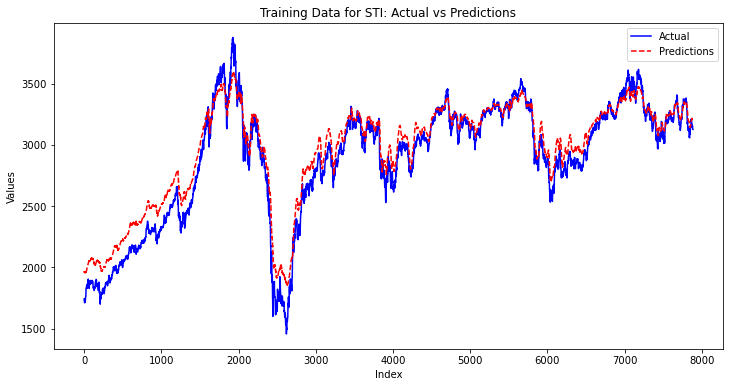

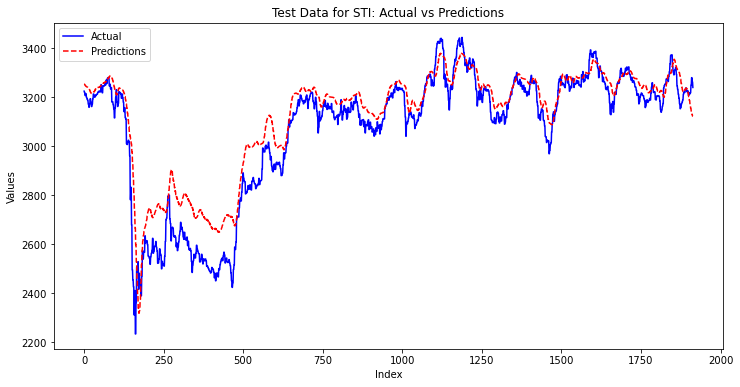

In [47]:
# Plotting for Training Data for STI
plt.figure(figsize=(12,6))
plt.plot(valid_train_sti.index.to_numpy(), valid_train_sti['Adj Close'].to_numpy(), label='Actual', color='blue')
plt.plot(valid_train_sti.index.to_numpy(), valid_train_sti['Predictions'].to_numpy(), label='Predictions', color='red', linestyle='dashed')
plt.title('Training Data for STI: Actual vs Predictions')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting for Test Data for STI
plt.figure(figsize=(12,6))
plt.plot(valid_test_sti.index.to_numpy(), valid_test_sti['Adj Close'].to_numpy(), label='Actual', color='blue')
plt.plot(valid_test_sti.index.to_numpy(), valid_test_sti['Predictions'].to_numpy(), label='Predictions', color='red', linestyle='dashed')
plt.title('Test Data for STI: Actual vs Predictions')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

#### 4.4 Predicing the Price of the Next Two Days

In [48]:
# Extract the last 60 days of data (or whichever window size you used for the LSTM input) from your DataFrame
last_60_days_sti = STI_data1[-53:].copy()

# If you have other features, prepare them like you did during training.
# For simplicity, I am assuming that you only have 'Adj Close' as a feature.

# Scale 'Adj Close' with the scaler used during training
last_60_days_scaled_sti = target_scaler_sti.transform(last_60_days_sti[['Adj Close']])
# Extract only the columns that were used in training the scaler
selected_features_sti = train_features_sti.columns.tolist()  

# Selecting only the relevant features and in the correct order from last_60_days
last_steps_sti = last_60_days_sti[selected_features_hsi].iloc[-step_sti:]

# Scale the features
last_steps_scaled_sti = feature_scaler_sti.transform(last_steps_sti)

# Reshape to the input shape (1, step, num_features)
X_test_sti = np.array(last_steps_scaled_sti).reshape(1, step_sti, -1)   # -1 here will automatically consider the number of features.

# Predict the scaled value for the next day
predicted_scaled_value_sti = model_sti.predict(X_test_sti)

# Inverse transform the predicted scaled value to get the actual predicted price
predicted_price_sti = target_scaler_sti.inverse_transform(predicted_scaled_value_sti)

# Print the predicted price
print(predicted_price_sti)

1/1 [==============================] - 0s 33ms/step
[[3115.9463 3115.9324]]


In [49]:
# Get the last date in the DataFrame and compute the next date
last_date_sti = STI_data1.index[-1]  # Assuming the index of your DataFrame is the date

# Initialize an empty DataFrame to store the predicted prices and their corresponding dates
predicted_data_sti = pd.DataFrame(columns=['Adj Close'])

# Loop through the predicted prices and generate the corresponding dates
for i, price in enumerate(predicted_price_sti[0]):
    # Compute the next date
    next_date_sti = last_date_sti + pd.Timedelta(days=(i + 1))  # i+1 to start from the next day
    
    # Append the predicted price and its corresponding date to the predicted_data_sti DataFrame
    predicted_data_sti.loc[next_date_sti] = price

# Concatenate the new DataFrame with the original one
STI_data1_new = pd.concat([STI_data1, predicted_data_sti], axis=0)

# Display the newly created DataFrame
print(STI_data1_new.tail(len(predicted_price_sti[0]) + 2))  # Display the last few rows including the new ones

                   Open         High          Low        Close    Adj Close  Rolling_Mean  \
2023-09-18  3285.149902  3285.149902  3259.030029  3263.389893  3263.389893   3264.529948   
2023-09-19  3264.870117  3266.469971  3235.959961  3240.750000  3240.750000   3261.609945   
2023-09-20          NaN          NaN          NaN          NaN  3115.946289           NaN   
2023-09-21          NaN          NaN          NaN          NaN  3115.932373           NaN   

               momentum          ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  
2023-09-18  3262.389893  3236.144252      3280.689941      3249.510010       2527.871237  
2023-09-19  3239.750000  3240.858538      3263.389893      3280.689941       2469.532822  
2023-09-20          NaN          NaN              NaN              NaN               NaN  
2023-09-21          NaN          NaN              NaN              NaN               NaN  


### 5. Amending Price into USD and Comparing Predicted and Real Price

##### 5.1 Amending the price of HSI into USD

In [50]:
#check the structure again 
HSI_data1_new.head()

Open          High           Low         Close     Adj Close  Rolling_Mean  \
2003-10-21  12190.080078  12297.459961  12161.250000  12250.690430  12250.690430  12147.690104   
2003-10-22  12240.540039  12283.879883  12199.230469  12238.629883  12238.629883  12212.403320   
2003-10-23  12027.910156  12051.139648  11712.139648  11737.179688  11737.179688  12075.500000   
2003-10-24  11792.870117  11819.200195  11558.110352  11736.370117  11736.370117  11904.059896   
2003-10-27  11749.870117  11803.179688  11678.200195  11749.719727  11749.719727  11741.089844   

                momentum           ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  
2003-10-21  12249.690430  12049.258510     12147.889648     12044.490234      11438.646290  
2003-10-22  12237.629883  12088.781390     12250.690430     12147.889648      11404.521892  
2003-10-23  11736.179688  12071.804269     12238.629883     12250.690430      11382.951318  
2003-10-24  11735.370117  12026.117188     11737.179688     12238.629883      11373.396245  
2003-10-27  11748.719727  11986.424247     11736.370117     11737.179688      11375.229442

As we used five years data to check cointegration so it is better idea to implement pairs trading strategies with five years data

In [51]:
# Fetch USD/HKD Data from 2018-09-20
start_date = '2018-09-20'
end_date = '2023-09-22'
currency_symbol = "USDHKD=X"
usdhkd_data = yf.download(currency_symbol, start=start_date, end=end_date)['Adj Close']
print(usdhkd_data.head())
print(usdhkd_data.tail())

[*********************100%***********************]  1 of 1 completed
Date
2018-09-20    7.84560
2018-09-21    7.84215
2018-09-24    7.80952
2018-09-25    7.81150
2018-09-26    7.80990
Name: Adj Close, dtype: float64
Date
2023-09-15    7.82920
2023-09-18    7.82545
2023-09-19    7.81820
2023-09-20    7.82090
2023-09-21    7.82380
Name: Adj Close, dtype: float64


In [52]:
# Print HSI_data1_new before truncating
print("Before truncating:")
print(HSI_data1_new.head())

# Truncate the DataFrame to start from '2003-12-01'
HSI_data1_new = HSI_data1_new[HSI_data1_new.index >= '2018-09-20']

# Print HSI_data1_new after truncating
print("After truncating:")
print(HSI_data1_new.head())

Before truncating:
                    Open          High           Low         Close     Adj Close  Rolling_Mean  \
2003-10-21  12190.080078  12297.459961  12161.250000  12250.690430  12250.690430  12147.690104   
2003-10-22  12240.540039  12283.879883  12199.230469  12238.629883  12238.629883  12212.403320   
2003-10-23  12027.910156  12051.139648  11712.139648  11737.179688  11737.179688  12075.500000   
2003-10-24  11792.870117  11819.200195  11558.110352  11736.370117  11736.370117  11904.059896   
2003-10-27  11749.870117  11803.179688  11678.200195  11749.719727  11749.719727  11741.089844   

                momentum           ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  
2003-10-21  12249.690430  12049.258510     12147.889648     12044.490234      11438.646290  
2003-10-22  12237.629883  12088.781390     12250.690430     12147.889648      11404.521892  
2003-10-23  11736.179688  12071.804269     12238.629883     12250.690430      11382.951318  
2003-10-24  11735.37

In [53]:
#Add in USD/HKD rate into HSI_data1_new and forwardfill the missing data

# Convert the USD/HKD series to a DataFrame
usdhkd_df = usdhkd_data.to_frame(name='USDHKD_Adj_Close')

# Join with the truncated DataFrame, HSI_data1_new, using the index
HSI_data1_new = HSI_data1_new.join(usdhkd_df, how='left')

# Forward Fill any Missing Values in USDHKD_Adj_Close
HSI_data1_new['USDHKD_Adj_Close'].fillna(method='ffill', inplace=True)

# Display the updated DataFrame
print(HSI_data1_new.tail())

                    Open          High           Low         Close     Adj Close  Rolling_Mean  \
2023-09-15  18154.009766  18372.650391  18030.789062  18182.890625  18182.890625  18080.010417   
2023-09-18  18069.039062  18114.820312  17894.810547  17930.550781  17930.550781  18053.787109   
2023-09-19  17942.070312  18004.740234  17832.300781  17997.169922  17997.169922  18036.870443   
2023-09-20           NaN           NaN           NaN           NaN  18009.664062           NaN   
2023-09-21           NaN           NaN           NaN           NaN  18032.996094           NaN   

                momentum           ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  \
2023-09-15  18181.890625  18144.917411     18047.919922     18009.220703      15430.025743   
2023-09-18  17929.550781  18070.713170     18182.890625     18047.919922      15182.370891   
2023-09-19  17996.169922  18041.441685     17930.550781     18182.890625      14934.709353   
2023-09-20           NaN           

In [54]:
#as a good habbit, we always fill in the missing data, eventhough we will only usd Adj Close 
#check the missing data with and without forward fill
print("Before ffill:")
print(HSI_data1_new.isnull().sum())  # Shows the count of NaN in each column before ffill

HSI_data1_new.ffill(inplace=True)

print("\nAfter ffill:")
print(HSI_data1_new.isnull().sum())  # Shows the count of NaN in each column after ffill

Before ffill:
Open                2
High                2
Low                 2
Close               2
Adj Close           0
Rolling_Mean        2
momentum            2
ma7                 2
Adj Close_lag_1     2
Adj Close_lag_2     2
Fourier_Denoised    2
USDHKD_Adj_Close    0
dtype: int64

After ffill:
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Rolling_Mean        0
momentum            0
ma7                 0
Adj Close_lag_1     0
Adj Close_lag_2     0
Fourier_Denoised    0
USDHKD_Adj_Close    0
dtype: int64


In [55]:
# Create a new column 'Adj Close USD'
HSI_data1_new['Adj Close USD'] = HSI_data1_new['Adj Close'] / HSI_data1_new['USDHKD_Adj_Close']

# Display the updated DataFrame
print(HSI_data1_new.head())

                    Open          High           Low         Close     Adj Close  Rolling_Mean  \
2018-09-20  27605.720703  27628.189453  27327.230469  27477.669922  27477.669922  27323.233073   
2018-09-21  27712.349609  27965.960938  27536.269531  27953.580078  27953.580078  27612.873047   
2018-09-24  27783.849609  27783.849609  27425.009766  27499.390625  27499.390625  27643.546875   
2018-09-26  27606.810547  28031.810547  27589.369141  27816.869141  27816.869141  27756.613281   
2018-09-27  27912.509766  27928.289062  27638.539062  27715.669922  27715.669922  27677.309896   

                momentum           ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  \
2018-09-20  27476.669922  27078.355469     27407.369141     27084.660156      26824.427711   
2018-09-21  27952.580078  27308.147042     27477.669922     27407.369141      26717.946108   
2018-09-24  27498.390625  27377.418527     27953.580078     27477.669922      26613.468031   
2018-09-26  27815.869141  27453.198

#### 5.2 Amending the price of STI into USD

same steps as HSI above

In [56]:
STI_data1_new.head()

Open         High          Low        Close    Adj Close  Rolling_Mean  \
2003-10-20  1766.420044  1787.869995  1764.959961  1780.239990  1780.239990   1768.869995   
2003-10-21  1794.339966  1804.949951  1787.880005  1792.859985  1792.859985   1781.760010   
2003-10-22  1795.719971  1801.709961  1771.260010  1771.260010  1771.260010   1781.453328   
2003-10-23  1759.859985  1761.709961  1720.069946  1732.959961  1732.959961   1765.693319   
2003-10-27  1732.569946  1732.569946  1709.150024  1712.619995  1712.619995   1738.946655   

               momentum          ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  
2003-10-20  1779.239990  1754.731428      1772.180054      1754.189941       1625.781897  
2003-10-21  1791.859985  1761.419992      1780.239990      1772.180054       1615.502875  
2003-10-22  1770.260010  1764.345703      1792.859985      1780.239990       1607.976024  
2003-10-23  1731.959961  1764.664272      1771.260010      1792.859985       1603.067672  
2003-10-27  1711.619995  1759.472848      1732.959961      1771.260010       1600.625996

As we used five years data to check cointegration so it is better idea to implement pairs trading strategies with five years data

In [57]:
#fetch USD/SGD data
start_date = '2018-09-20'
end_date = '2023-09-22'
# Fetch USD/HKD Data
currency_symbol = "USDSGD=X"
usdsgd_data = yf.download(currency_symbol, start=start_date, end=end_date)['Adj Close']
print(usdsgd_data.head())
print(usdsgd_data.tail())

[*********************100%***********************]  1 of 1 completed
Date
2018-09-20    1.36903
2018-09-21    1.36480
2018-09-24    1.36500
2018-09-25    1.36580
2018-09-26    1.36596
Name: Adj Close, dtype: float64
Date
2023-09-15    1.36431
2023-09-18    1.36275
2023-09-19    1.36342
2023-09-20    1.36434
2023-09-21    1.36624
Name: Adj Close, dtype: float64


In [58]:
# Print STI_data1_new before truncating
print("Before truncating:")
print(STI_data1_new.head())

# Truncate the DataFrame to start from '2003-12-01'
STI_data1_new = STI_data1_new[STI_data1_new.index >= '2018-09-20']

# Print STI_data1_new after truncating
print("After truncating:")
print(STI_data1_new.head())

Before truncating:
                   Open         High          Low        Close    Adj Close  Rolling_Mean  \
2003-10-20  1766.420044  1787.869995  1764.959961  1780.239990  1780.239990   1768.869995   
2003-10-21  1794.339966  1804.949951  1787.880005  1792.859985  1792.859985   1781.760010   
2003-10-22  1795.719971  1801.709961  1771.260010  1771.260010  1771.260010   1781.453328   
2003-10-23  1759.859985  1761.709961  1720.069946  1732.959961  1732.959961   1765.693319   
2003-10-27  1732.569946  1732.569946  1709.150024  1712.619995  1712.619995   1738.946655   

               momentum          ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  
2003-10-20  1779.239990  1754.731428      1772.180054      1754.189941       1625.781897  
2003-10-21  1791.859985  1761.419992      1780.239990      1772.180054       1615.502875  
2003-10-22  1770.260010  1764.345703      1792.859985      1780.239990       1607.976024  
2003-10-23  1731.959961  1764.664272      1771.260010     

The USDHKD rate started only on 2003-12-01 so we will amend the data of STI to start from the same date

In [59]:
# Convert the USD/HKD series to a DataFrame
usdsgd_df = usdsgd_data.to_frame(name='USDSGD_Adj_Close')

# Join with the truncated DataFrame, HSI_data1_new, using the index
STI_data1_new = STI_data1_new.join(usdsgd_df, how='left')

# Forward Fill any Missing Values in USDHKD_Adj_Close
STI_data1_new['USDSGD_Adj_Close'].fillna(method='ffill', inplace=True)

# If you want to backfill any remaining missing values
STI_data1_new['USDSGD_Adj_Close'].fillna(method='bfill', inplace=True)

# Display the updated DataFrame
print(STI_data1_new.tail())

                   Open         High          Low        Close    Adj Close  Rolling_Mean  \
2023-09-15  3263.219971  3289.070068  3259.350098  3280.689941  3280.689941   3249.709961   
2023-09-18  3285.149902  3285.149902  3259.030029  3263.389893  3263.389893   3264.529948   
2023-09-19  3264.870117  3266.469971  3235.959961  3240.750000  3240.750000   3261.609945   
2023-09-20          NaN          NaN          NaN          NaN  3115.946289           NaN   
2023-09-21          NaN          NaN          NaN          NaN  3115.932373           NaN   

               momentum          ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  \
2023-09-15  3279.689941  3230.887137      3249.510010      3218.929932       2586.022168   
2023-09-18  3262.389893  3236.144252      3280.689941      3249.510010       2527.871237   
2023-09-19  3239.750000  3240.858538      3263.389893      3280.689941       2469.532822   
2023-09-20          NaN          NaN              NaN              NaN   

In [60]:
#check the missing data with and without forward fill
print("Before ffill:")
print(STI_data1_new.isnull().sum())  # Shows the count of NaN in each column before ffill

STI_data1_new.ffill(inplace=True)

print("\nAfter ffill:")
print(STI_data1_new.isnull().sum())  # Shows the count of NaN in each column after ffill

Before ffill:
Open                2
High                2
Low                 2
Close               2
Adj Close           0
Rolling_Mean        2
momentum            2
ma7                 2
Adj Close_lag_1     2
Adj Close_lag_2     2
Fourier_Denoised    2
USDSGD_Adj_Close    0
dtype: int64

After ffill:
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Rolling_Mean        0
momentum            0
ma7                 0
Adj Close_lag_1     0
Adj Close_lag_2     0
Fourier_Denoised    0
USDSGD_Adj_Close    0
dtype: int64


In [61]:
# Create a new column 'Adj Close USD'
STI_data1_new['Adj Close USD'] = STI_data1_new['Adj Close'] / STI_data1_new['USDSGD_Adj_Close']

# Display the updated DataFrame
print(STI_data1_new.head())

                   Open         High          Low        Close    Adj Close  Rolling_Mean  \
2018-09-20  3180.429932  3189.310059  3172.639893  3180.429932  3180.429932   3165.446696   
2018-09-21  3206.939941  3225.399902  3199.889893  3217.679932  3217.679932   3191.559977   
2018-09-24  3215.689941  3232.610107  3213.280029  3219.159912  3219.159912   3205.756592   
2018-09-25  3229.899902  3243.239990  3226.489990  3236.080078  3236.080078   3224.306641   
2018-09-26  3248.810059  3265.010010  3237.909912  3239.100098  3239.100098   3231.446696   

               momentum          ma7  Adj Close_lag_1  Adj Close_lag_2  Fourier_Denoised  \
2018-09-20  3179.429932  3150.797119      3176.570068      3139.340088       3159.360720   
2018-09-21  3216.679932  3164.087123      3180.429932      3176.570068       3153.227962   
2018-09-24  3218.159912  3176.571394      3217.679932      3180.429932       3147.317461   
2018-09-25  3235.080078  3187.237130      3219.159912      3217.679932   

#### 5.3 Comparison of Predicted Price vs Real Price for Both HSI and STI

In [62]:
#Print out the predicted price and then the real price 
print(HSI_data1_new['Adj Close'][-3:])

#Fetch HSI data using yfinance 
start_date = '2023-09-19'
end_date = '2023-09-22'
symbols = ['^HSI']
HSI_data_real = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
print(HSI_data_real)

2023-09-19    17997.169922
2023-09-20    18009.664062
2023-09-21    18032.996094
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
Date
2023-09-19    17997.169922
2023-09-20    17885.599609
2023-09-21    17655.410156
Name: Adj Close, dtype: float64


In [63]:
# Fetch the last 3 dates and values from the predicted DataFrame
predicted_df = HSI_data1_new['Adj Close'][-3:].reset_index()
predicted_df.columns = ['Date', 'Predicted Price']

# Fetching real data using yfinance for the last 3 dates in predicted_df
start_date = predicted_df['Date'].min().strftime('%Y-%m-%d')
end_date = (predicted_df['Date'].max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d')  # Ensure end_date is inclusive
symbols = ['^HSI']
real_df = yf.download(symbols, start=start_date, end=end_date)[['Adj Close']].reset_index()
real_df.columns = ['Date', 'Real Price']

# Merging the two DataFrames on Date
result_df = pd.merge(predicted_df, real_df, on='Date', how='left')  # use 'left' to keep all rows in predicted_df
result_df['Date'] = pd.to_datetime(result_df['Date'])  # Ensure Date is in datetime format
result_df.set_index('Date', inplace=True)

# Calculating the changes and difference
result_df['Predicted Change'] = result_df['Predicted Price'].diff().apply(lambda x: '+' if x > 0 else '-' if x < 0 else 'N/A')
result_df['Real Change'] = result_df['Real Price'].diff().apply(lambda x: '+' if x > 0 else '-' if x < 0 else 'N/A')
result_df['Predicted - Real'] = result_df['Predicted Price'] - result_df['Real Price']

# Displaying the DataFrame
print(result_df)

[*********************100%***********************]  1 of 1 completed
            Predicted Price    Real Price Predicted Change Real Change  Predicted - Real
Date                                                                                    
2023-09-19     17997.169922  17997.169922              N/A         N/A          0.000000
2023-09-20     18009.664062  17885.599609                +           -        124.064453
2023-09-21     18032.996094  17655.410156                +           -        377.585938


In [64]:
print(STI_data1_new['Adj Close'][-3:])

#Fetch HSI data using yfinance 
start_date = '2023-09-19'
end_date = '2023-09-22'
symbols = ['^STI']
STI_data_real = yf.download(symbols, start=start_date, end=end_date)['Adj Close']
print(STI_data_real)

2023-09-19    3240.750000
2023-09-20    3115.946289
2023-09-21    3115.932373
Name: Adj Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
Date
2023-09-19    3240.750000
2023-09-20    3242.000000
2023-09-21    3202.810059
Name: Adj Close, dtype: float64


In [65]:


# Assuming STI_data1_new is your DataFrame with the predicted values

# Fetch the last 3 dates and values from the predicted DataFrame
predicted_df = STI_data1_new['Adj Close'][-3:].reset_index()
predicted_df.columns = ['Date', 'Predicted Price']

# Fetching real data using yfinance for the last 3 dates in predicted_df
start_date = predicted_df['Date'].min().strftime('%Y-%m-%d')
# Add one day to end_date to make it inclusive
end_date = (predicted_df['Date'].max() + timedelta(days=1)).strftime('%Y-%m-%d')
symbols = ['^STI']
real_df = yf.download(symbols, start=start_date, end=end_date)[['Adj Close']].reset_index()
real_df.columns = ['Date', 'Real Price']

# Merging the two DataFrames on Date
result_df = pd.merge(predicted_df, real_df, on='Date', how='left')  # use 'left' to keep all rows in predicted_df
result_df['Date'] = pd.to_datetime(result_df['Date'])  # Ensure Date is in datetime format
result_df.set_index('Date', inplace=True)

# Calculating the changes and difference
result_df['Predicted Change'] = result_df['Predicted Price'].diff().apply(lambda x: '+' if x > 0 else '-' if x < 0 else 'N/A')
result_df['Real Change'] = result_df['Real Price'].diff().apply(lambda x: '+' if x > 0 else '-' if x < 0 else 'N/A')
result_df['Predicted - Real'] = result_df['Predicted Price'] - result_df['Real Price']

# Displaying the DataFrame
print(result_df)

[*********************100%***********************]  1 of 1 completed
            Predicted Price   Real Price Predicted Change Real Change  Predicted - Real
Date                                                                                   
2023-09-19      3240.750000  3240.750000              N/A         N/A          0.000000
2023-09-20      3115.946289  3242.000000                -           +       -126.053711
2023-09-21      3115.932373  3202.810059                -           -        -86.877686


### 6. Pairs Trading using Z-score of HSI/STI Adj Close USD Price Ratio

#### 6.1 Pairs Trading using Z-score of HSI/STI Adj Close USD Price Ratio

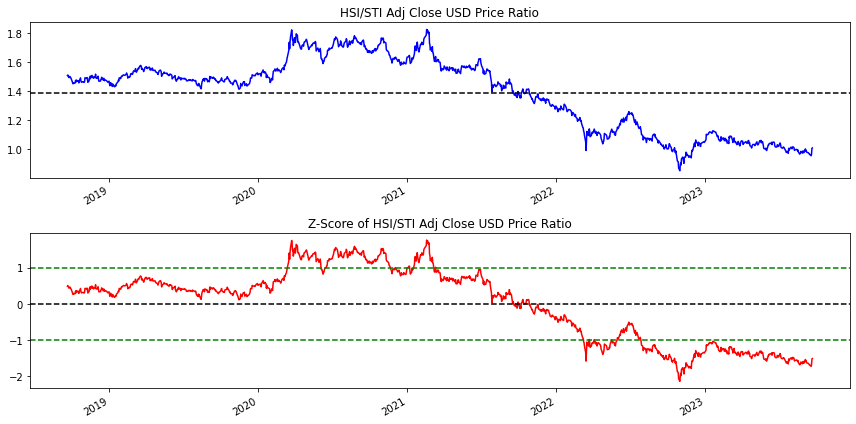

In [66]:
#Creating the price ratio graph and Z score graph
# Ensuring both DataFrames are aligned by date
aligned_data = pd.concat([HSI_data1_new['Adj Close USD'], STI_data1_new['Adj Close USD']], axis=1, join='inner')
aligned_data.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']

# Calculating the ratio of 'Adj Close USD' of HSI to 'Adj Close USD' of STI
aligned_data['ratio'] = aligned_data['HSI_Adj_Close_USD'] / aligned_data['STI_Adj_Close_USD']

# Calculating the mean and standard deviation of the ratio
mean_ratio = aligned_data['ratio'].mean()
std_ratio = aligned_data['ratio'].std()

# Calculating the Z-Score of the ratio
aligned_data['Z-Score'] = (aligned_data['ratio'] - mean_ratio) / std_ratio

# Plotting the Ratio and Z-Score
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
aligned_data['ratio'].plot(title='HSI/STI Adj Close USD Price Ratio', color='blue')
plt.axhline(mean_ratio, color='black', linestyle='--')  # changed to mean_ratio for better clarity

plt.subplot(2,1,2)
aligned_data['Z-Score'].plot(title='Z-Score of HSI/STI Adj Close USD Price Ratio', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')

plt.tight_layout()
plt.show()

In [67]:
fund = 100000  # Starting fund
trade_size = 5000  # Max amount for pairs trading
hsi_position = 0
sti_position = 0
cumulative_pnl = 0  # cumulative profit/loss

trade_logs = []  # To store trade details
transaction_cost_rate = 0.001  # 0.1%

# Iterate over the aligned data
for index, row in aligned_data.iterrows():
    z_score = row['Z-Score']
    hsi_price = row['HSI_Adj_Close_USD']
    sti_price = row['STI_Adj_Close_USD']
    ratio = row['ratio']

    available_fund = fund - (abs(hsi_position) * hsi_price + abs(sti_position) * sti_price)

    trade_quantity = min(trade_size // max(hsi_price, sti_price * ratio), available_fund // (hsi_price + sti_price * ratio))
    
    # Execute trades
    if -1 < z_score < 1:
        if hsi_position != 0 or sti_position != 0:  # Close Positions
            pnl = hsi_position * hsi_price + sti_position * sti_price - transaction_cost_rate * (abs(hsi_position) * hsi_price + abs(sti_position) * sti_price)
            cumulative_pnl += pnl  # Update Cumulative PnL
            trade_logs.append({'Date': index, 'Action': 'Exit', 'HSI Quantity': -hsi_position, 'STI Quantity': -sti_position, 'PnL': pnl, 'Total PnL': cumulative_pnl, 'Fund': available_fund + cumulative_pnl})
            hsi_position, sti_position = 0, 0  # Reset positions

    elif z_score < -1 and available_fund > trade_size:  # Buy HSI, Sell STI
        hsi_position += trade_quantity
        sti_position -= trade_quantity * ratio  # Selling STI so position is negative
        trade_logs.append({'Date': index, 'Action': 'Buy HSI, Sell STI', 'HSI Quantity': trade_quantity, 'STI Quantity': -trade_quantity * ratio, 'PnL': cumulative_pnl, 'Total PnL': cumulative_pnl, 'Fund': available_fund})

    elif z_score > 1 and available_fund > trade_size:  # Sell HSI, Buy STI
        hsi_position -= trade_quantity
        sti_position += trade_quantity * ratio
        trade_logs.append({'Date': index, 'Action': 'Sell HSI, Buy STI', 'HSI Quantity': -trade_quantity, 'STI Quantity': trade_quantity * ratio, 'PnL': cumulative_pnl, 'Total PnL': cumulative_pnl, 'Fund': available_fund})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD'] - transaction_cost_rate * (abs(hsi_position) * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD'])
    cumulative_pnl += pnl
    trade_logs.append({'Date': index, 'Action': 'Final Exit', 'HSI Quantity': -hsi_position, 'STI Quantity': -sti_position, 'PnL': pnl, 'Total PnL': cumulative_pnl, 'Fund': available_fund + cumulative_pnl})

trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", cumulative_pnl)

Total PnL:  10891.545009556368


#### 6.2 Pairs Trading using 3 Simple Moving Average (sma) methods

6.2.1 Z-score

6.2.2 short term sma z score vs. long term lsma z score

6.2.3 Short-term SMA vs. Long-term SMA

#### 6.2.1 Z-score

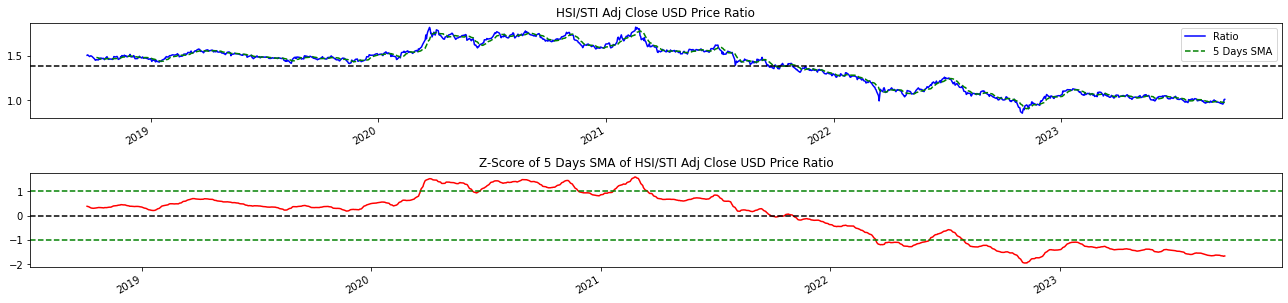

In [68]:
# Ensuring both DataFrames are aligned by date
aligned_data = pd.concat([HSI_data1_new['Adj Close USD'], STI_data1_new['Adj Close USD']], axis=1, join='inner')
aligned_data.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']

# Calculating the ratio of 'Adj Close USD' of HSI to 'Adj Close USD' of STI
aligned_data['ratio'] = aligned_data['HSI_Adj_Close_USD'] / aligned_data['STI_Adj_Close_USD']

# Calculating the 5-days SMA of the ratio
aligned_data['5_days_SMA'] = aligned_data['ratio'].rolling(window=10).mean()

# Calculating the Z-Score of the 5-day SMA of the ratio
mean_sma = aligned_data['5_days_SMA'].mean()
std_sma = aligned_data['5_days_SMA'].std()
aligned_data['SMA_Z-Score'] = (aligned_data['5_days_SMA'] - mean_sma) / std_sma

# Plotting the Ratio and 5-days SMA of Ratio, and Z-Score of the 5-days SMA
plt.figure(figsize=(18, 6))

# Plotting Ratio and its 5-days SMA
plt.subplot(3, 1, 1)
aligned_data['ratio'].plot(title='HSI/STI Adj Close USD Price Ratio', color='blue', label='Ratio')
aligned_data['5_days_SMA'].plot(color='green', linestyle='--', label='5 Days SMA')
plt.axhline(aligned_data['ratio'].mean(), color='black', linestyle='--')
plt.legend()

# Plotting Z-Score of the 5-days SMA
plt.subplot(3, 1, 2)
aligned_data['SMA_Z-Score'].plot(title='Z-Score of 5 Days SMA of HSI/STI Adj Close USD Price Ratio', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')

plt.tight_layout()
plt.show()

In [69]:
fund = 100000  # Starting fund
trade_size = 5000  # Max amount for pairs trading
hsi_position = 0  # Initial position
sti_position = 0  # Initial position
cumulative_pnl = 0  # Cumulative Profit/Loss
trade_logs = []  # To store trade details
transaction_cost_rate = 0.001  # 0.1% transaction cost

for index, row in aligned_data.iterrows():
    if np.isnan(row['SMA_Z-Score']):
        continue  # Skip rows where the SMA Z-Score is NaN
    
    sma_z_score = row['SMA_Z-Score']
    hsi_price = row['HSI_Adj_Close_USD']
    sti_price = row['STI_Adj_Close_USD']
    ratio = row['ratio']

    available_fund = fund - (abs(hsi_position) * hsi_price + abs(sti_position) * sti_price)
    trade_quantity = min(trade_size // max(hsi_price, sti_price * ratio), available_fund // (hsi_price + sti_price * ratio))

    if -1 < sma_z_score < 1:  # Close Positions if Z-Score of 5-day SMA is between -1 and 1
        if hsi_position != 0 or sti_position != 0:
            pnl = hsi_position * hsi_price + sti_position * sti_price - transaction_cost_rate * (abs(hsi_position) * hsi_price + abs(sti_position) * sti_price)
            cumulative_pnl += pnl
            fund += abs(hsi_position) * hsi_price + abs(sti_position) * sti_price  # release funds from sold positions
            hsi_position, sti_position = 0, 0  # reset positions
            trade_logs.append({'Date': index, 'Action': 'Exit', 'HSI Quantity': hsi_position, 'STI Quantity': sti_position, 'PnL': pnl, 'Total PnL': cumulative_pnl, 'Fund': fund})
    
    elif sma_z_score < -1 and fund > trade_size:  # Buy HSI, Sell STI if Z-Score of 5-day SMA is below -1
        hsi_position += trade_quantity
        sti_position -= trade_quantity * ratio
        fund -= trade_size  # Deduct the amount spent from fund
        trade_logs.append({'Date': index, 'Action': 'Buy HSI, Sell STI', 'HSI Quantity': trade_quantity, 'STI Quantity': -trade_quantity * ratio, 'PnL': 0, 'Total PnL': cumulative_pnl, 'Fund': fund})
    
    elif sma_z_score > 1 and fund > trade_size:  # Sell HSI, Buy STI if Z-Score of 5-day SMA is above 1
        hsi_position -= trade_quantity
        sti_position += trade_quantity * ratio
        fund -= trade_size  # Deduct the amount spent from fund
        trade_logs.append({'Date': index, 'Action': 'Sell HSI, Buy STI', 'HSI Quantity': -trade_quantity, 'STI Quantity': trade_quantity * ratio, 'PnL': 0, 'Total PnL': cumulative_pnl, 'Fund': fund})

if hsi_position != 0 or sti_position != 0:  # Finalizing any open positions at the end of the data series
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD'] - transaction_cost_rate * (abs(hsi_position) * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD'])
    cumulative_pnl += pnl
    fund += abs(hsi_position) * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']  # release funds from sold positions

trade_logs_df = pd.DataFrame(trade_logs)  # Recording trade logs and displaying results
print("Total PnL: ", cumulative_pnl)

Total PnL:  1453.7839029647407


#### 6.2.2 short term sma z score vs. long term lsma z score

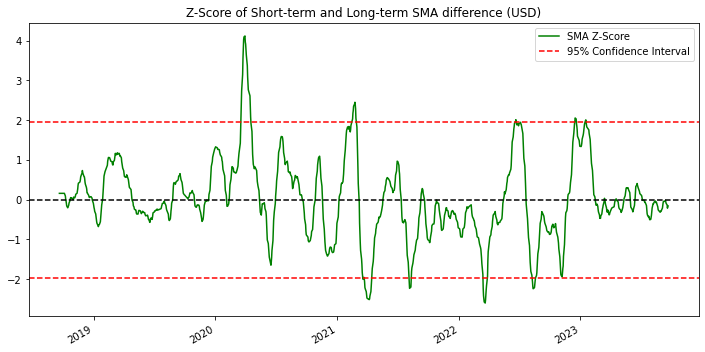

In [70]:
# Calculating Short-term and Long-term SMAs
short_window = 10
long_window = 40

aligned_data['short_sma'] = aligned_data['ratio'].rolling(window=short_window, min_periods=1, center=False).mean()
aligned_data['long_sma'] = aligned_data['ratio'].rolling(window=long_window, min_periods=1, center=False).mean()

# Calculating the Mean and Standard Deviation of the difference between Short-term and Long-term SMAs
aligned_data['sma_diff'] = aligned_data['short_sma'] - aligned_data['long_sma']
mean_sma_diff = aligned_data['sma_diff'].mean()
std_sma_diff = aligned_data['sma_diff'].std()

# Calculating the Z-Score of the difference between SMAs
aligned_data['sma_z_score'] = (aligned_data['sma_diff'] - mean_sma_diff) / std_sma_diff

# Plotting the Z-Score
plt.figure(figsize=(12,6))

# Use DataFrame’s plot function for better handling of dates in the index
aligned_data['sma_z_score'].plot(label='SMA Z-Score', color='green')

plt.axhline(0, color='black', linestyle='--')
plt.axhline(1.96, color='red', linestyle='--', label='95% Confidence Interval')
plt.axhline(-1.96, color='red', linestyle='--')
plt.title('Z-Score of Short-term and Long-term SMA difference (USD)')
plt.legend()
plt.show()

In [71]:
lower_threshold = -1.5  # Define lower threshold for Buy Signal
upper_threshold = 1.5  # Define upper threshold for Sell Signal
trade_size = 5000  # Amount to be utilized per trade

trade_logs = []  # Initialize list to store trade logs
hsi_position, sti_position = 0, 0  # Initial positions
total_pnl = 0  # Initial profit and loss
fund = 100000  # Initial fund

for index in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[index]
    sma_z_score = current_row['sma_z_score']
    hsi_price = current_row['HSI_Adj_Close_USD']
    sti_price = current_row['STI_Adj_Close_USD']
    available_fund = fund + total_pnl - (abs(hsi_position) * hsi_price + abs(sti_position) * sti_price)
    
    if available_fund < trade_size:  # Skip if not enough available funds
        continue
    
    # Buy Signal
    if sma_z_score < lower_threshold and hsi_position <= 0:
        hsi_trade_qty = trade_size // (2 * hsi_price)  # Allocate half of trade_size to HSI
        sti_trade_qty = hsi_trade_qty * current_row['ratio']
        hsi_position += hsi_trade_qty
        sti_position -= sti_trade_qty  # Selling STI so position is negative
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy HSI, Sell STI', 'HSI Quantity': hsi_trade_qty, 'STI Quantity': -sti_trade_qty, 'PnL': 0, 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund, 2)})
    
    # Sell Signal
    elif sma_z_score > upper_threshold and hsi_position > 0:
        pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell HSI, Buy STI', 'HSI Quantity': -hsi_trade_qty, 'STI Quantity': sti_trade_qty, 'PnL': round(pnl, 2), 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund + pnl, 2)})
    
    # Exit Signal for Buy Position: When sma_z_score is close to 0 after Buy trade
    elif -0.1 < sma_z_score < 0.1 and hsi_position > 0:
        pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': -hsi_trade_qty, 'STI Quantity': sti_trade_qty, 'PnL': round(pnl, 2), 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund + pnl, 2)})
    
    # Exit Signal for Sell Position: When sma_z_score is close to 0 after Sell trade
    elif -0.1 < sma_z_score < 0.1 and sti_position < 0:
        pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': hsi_trade_qty, 'STI Quantity': -sti_trade_qty, 'PnL': round(pnl, 2), 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund + pnl, 2)})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
    total_pnl += pnl
    trade_logs.append({'Date': current_row.name, 'Action': 'Final Exit', 'HSI Quantity': -hsi_position, 'STI Quantity': abs(sti_position), 'PnL': round(pnl, 2), 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund + pnl, 2)})

trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", round(total_pnl, 2))

Total PnL:  9675.45


#### 6.2.3 Short-term SMA vs. Long-term SMA

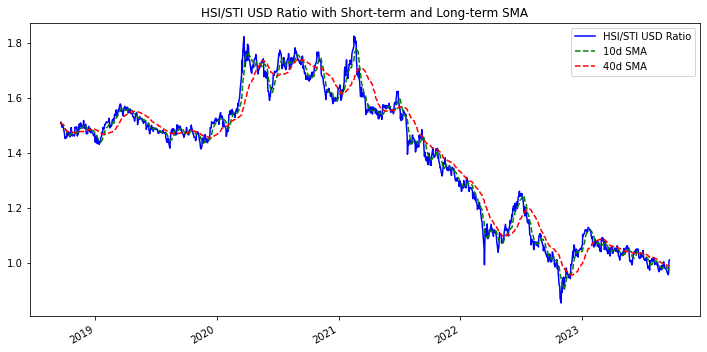

In [72]:
#sma method 2 ssma vs lsma
# Define short and long windows
short_window = 10
long_window = 40

# Correcting the references and labels
aligned_data['short_sma'] = aligned_data['ratio'].rolling(window=short_window, min_periods=1, center=False).mean()
aligned_data['long_sma'] = aligned_data['ratio'].rolling(window=long_window, min_periods=1, center=False).mean()

# Plotting the Ratio, Short-term SMA, and Long-term SMA
# Plotting the Ratio, Short-term SMA, and Long-term SMA
plt.figure(figsize=(12,6))

# Using DataFrame’s plot function for better handling of dates in the index
aligned_data['ratio'].plot(label='HSI/STI USD Ratio', color='blue')
aligned_data['short_sma'].plot(label=f'{short_window}d SMA', color='green', linestyle='--')
aligned_data['long_sma'].plot(label=f'{long_window}d SMA', color='red', linestyle='--')

plt.title('HSI/STI USD Ratio with Short-term and Long-term SMA')
plt.legend()
plt.show()

In [73]:
# Initialize position, pnl, and fund
hsi_position = 0
sti_position = 0
total_pnl = 0
fund = 100000  # Starting fund
trade_size = 5000  # Max amount for pairs trading
trade_logs = []  # Initialize list to store trade logs
transaction_cost_rate = 0.001  # 0.1%

# Iterate over the aligned data
for index in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[index]
    previous_row = aligned_data.iloc[index - 1]
    
    hsi_price = current_row['HSI_Adj_Close_USD']
    sti_price = current_row['STI_Adj_Close_USD']
    ratio = current_row['ratio']
    available_fund = fund + total_pnl - (abs(hsi_position) * hsi_price + abs(sti_position) * sti_price)
    trade_quantity = min(trade_size // max(hsi_price, sti_price * ratio), available_fund // (hsi_price + sti_price * ratio))
    
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    # Buy Signal: Short-term SMA crosses above Long-term SMA
    if previous_row['short_sma'] < previous_row['long_sma'] and current_row['short_sma'] > current_row['long_sma']:
        hsi_position += trade_quantity
        sti_position -= trade_quantity * ratio
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy HSI, Sell STI', 'HSI Quantity': trade_quantity, 'STI Quantity': -trade_quantity * ratio, 'PnL': 0, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Sell Signal: Short-term SMA crosses below Long-term SMA
    elif previous_row['short_sma'] > previous_row['long_sma'] and current_row['short_sma'] < current_row['long_sma']:
        hsi_position -= trade_quantity
        sti_position += trade_quantity * ratio
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell HSI, Buy STI', 'HSI Quantity': -trade_quantity, 'STI Quantity': trade_quantity * ratio, 'PnL': 0, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Signal for Buy Position: Exit when Short SMA crosses below Long SMA after Buy trade
    elif hsi_position > 0 and previous_row['short_sma'] >= current_row['long_sma'] and current_row['short_sma'] < current_row['long_sma']:
        pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund + pnl})
    
    # Exit Signal for Sell Position: Exit when Short SMA crosses above Long SMA after Sell trade
    elif sti_position < 0 and previous_row['short_sma'] <= current_row['long_sma'] and current_row['short_sma'] > current_row['long_sma']:
        pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund + pnl})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
    total_pnl += pnl
    trade_logs.append({'Date': current_row.name, 'Action': 'Final Exit', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund + pnl})

trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", total_pnl)

Total PnL:  7840.05736819776


#### 6.3 Pairs Trading using 3 Exponential Moving Average (EMA) methods

6.3.1 Z-score

6.3.2 Short-term SMA vs. Long-term SMA

6.3.3 short term sma z score vs. long term lsma z score

#### 6.3.1 Z-score

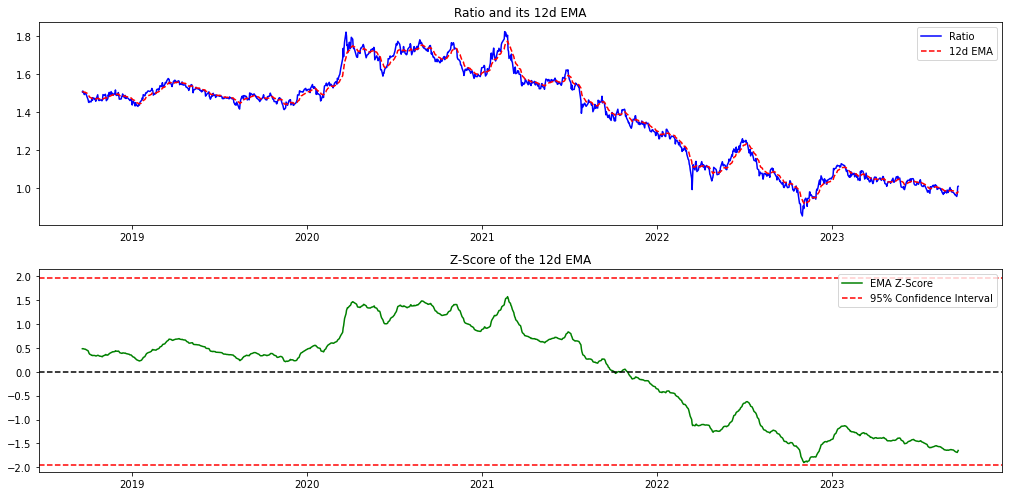

In [74]:
# Creating aligned_data DataFrame
aligned_data = pd.concat([HSI_data1_new['Adj Close USD'], STI_data1_new['Adj Close USD']], axis=1, join='inner')
aligned_data.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']
aligned_data['ratio'] = aligned_data['HSI_Adj_Close_USD'] / aligned_data['STI_Adj_Close_USD']
aligned_data['12d_ema'] = aligned_data['ratio'].ewm(span=12, adjust=False).mean()

mean_ema = aligned_data['12d_ema'].mean()
std_ema = aligned_data['12d_ema'].std()

aligned_data['ema_z_score'] = (aligned_data['12d_ema'] - mean_ema) / std_ema

plt.figure(figsize=(14,7))

# Plotting the ratio and its EMA
plt.subplot(2,1,1)
plt.plot(aligned_data.index.to_numpy(), aligned_data['ratio'].to_numpy(), label='Ratio', color='blue')
plt.plot(aligned_data.index.to_numpy(), aligned_data['12d_ema'].to_numpy(), label='12d EMA', color='red', linestyle='dashed')
plt.title('Ratio and its 12d EMA')
plt.legend()

# Plotting the Z-Score of the EMA
plt.subplot(2,1,2)
plt.plot(aligned_data.index.to_numpy(), aligned_data['ema_z_score'].to_numpy(), label='EMA Z-Score', color='green')
plt.axhline(0, color='black', linestyle='dashed')
plt.axhline(1.96, color='red', linestyle='dashed', label='95% Confidence Interval')
plt.axhline(-1.96, color='red', linestyle='dashed')
plt.title('Z-Score of the 12d EMA')
plt.legend()

plt.tight_layout()
plt.show()

In [75]:
fund = 100000  # Initial fund
trade_size = 5000  # Trade size per trade
hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

for i in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    previous_row = aligned_data.iloc[i - 1]
    
    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds

    # Buy Signal: EMA Z-Score crosses below a lower threshold
    if previous_row['ema_z_score'] >= -1.5 and current_row['ema_z_score'] < -1.5:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position += hsi_quantity
        sti_position -= sti_quantity
        fund -= trade_size  # Deduct the trade_size from the available fund
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_quantity, 'STI Quantity': sti_quantity, 'PnL': 0, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Sell Signal: EMA Z-Score crosses above a upper threshold
    elif previous_row['ema_z_score'] <= 1.5 and current_row['ema_z_score'] > 1.5:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Signal for Buy Position: EMA Z-Score crosses back above 0 after Buy trade
    elif hsi_position > 0 and previous_row['ema_z_score'] < 0 and current_row['ema_z_score'] >= 0:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Signal for Sell Position: EMA Z-Score crosses back below 0 after Sell trade
    elif sti_position < 0 and previous_row['ema_z_score'] > 0 and current_row['ema_z_score'] <= 0:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
    total_pnl += pnl
    available_fund = fund + total_pnl  # Update the available fund after the last transaction
    trade_logs.append({'Date': current_row.name, 'Action': 'Final Exit', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})

trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", total_pnl)

Total PnL:  20161.65014927232


#### 6.3.2 Short-term SMA vs. Long-term SMA

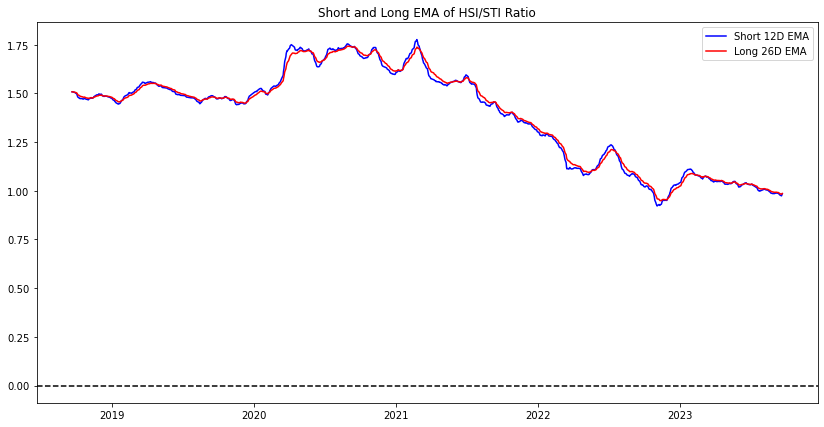

In [76]:
# Define short and long span for EMAs
short_span = 12
long_span = 26

# Calculate short and long EMAs of the ratio
aligned_data['short_ema'] = aligned_data['ratio'].ewm(span=short_span, adjust=False).mean()
aligned_data['long_ema'] = aligned_data['ratio'].ewm(span=long_span, adjust=False).mean()

plt.figure(figsize=(14,7))

# Convert series to numpy array before plotting
plt.plot(aligned_data.index.to_numpy(), aligned_data['short_ema'].to_numpy(), label=f'Short {short_span}D EMA', color='blue')
plt.plot(aligned_data.index.to_numpy(), aligned_data['long_ema'].to_numpy(), label=f'Long {long_span}D EMA', color='red')

plt.title('Short and Long EMA of HSI/STI Ratio')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

In [77]:
fund = 100000  # Initial fund
trade_size = 5000  # Trade size per trade
hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

# Iterate over the aligned data
for i in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    previous_row = aligned_data.iloc[i - 1]
    
    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    # Buy Signal: Short EMA crosses above Long EMA
    if previous_row['short_ema'] < previous_row['long_ema'] and current_row['short_ema'] > current_row['long_ema']:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position += hsi_quantity
        sti_position -= sti_quantity  # Selling STI so position is negative
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_quantity, 'STI Quantity': sti_quantity, 'PnL': 0, 'Total PnL': total_pnl, 'Fund': available_fund})
        
    # Sell Signal: Short EMA crosses below Long EMA
    elif previous_row['short_ema'] > previous_row['long_ema'] and current_row['short_ema'] < current_row['long_ema']:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Signal for Buy Position: Exit when Short EMA crosses below Long EMA after Buy trade
    elif hsi_position > 0 and previous_row['short_ema'] >= current_row['long_ema'] and current_row['short_ema'] < current_row['long_ema']:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Signal for Sell Position: Exit when Short EMA crosses above Long EMA after Sell trade
    elif sti_position < 0 and previous_row['short_ema'] <= current_row['long_ema'] and current_row['short_ema'] > current_row['long_ema']:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
    total_pnl += pnl
    available_fund = fund + total_pnl  # Update the available fund after the last transaction
    trade_logs.append({'Date': current_row.name, 'Action': 'Final Exit', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})

trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", total_pnl)

Total PnL:  90101.42544316387


#### 6.3.3 short term sma z score vs. long term sma z score

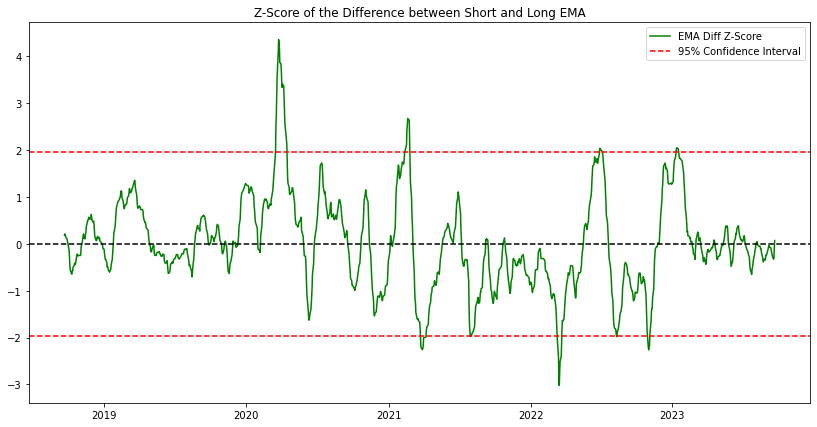

In [78]:
# Calculate Mean and Standard Deviation of the difference between short and long EMA
mean_diff_ema = (aligned_data['short_ema'] - aligned_data['long_ema']).mean()
std_diff_ema = (aligned_data['short_ema'] - aligned_data['long_ema']).std()

# Calculate the Z-Score of the difference between short and long EMA
aligned_data['ema_diff_z_score'] = (aligned_data['short_ema'] - aligned_data['long_ema'] - mean_diff_ema) / std_diff_ema

# Plotting
plt.figure(figsize=(14,7))
plt.plot(aligned_data.index.to_numpy(), aligned_data['ema_diff_z_score'].to_numpy(), label='EMA Diff Z-Score', color='green')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1.96, color='red', linestyle='--', label='95% Confidence Interval')
plt.axhline(-1.96, color='red', linestyle='--')
plt.title('Z-Score of the Difference between Short and Long EMA')
plt.legend()
plt.show()

In [79]:
fund = 100000  # Starting fund
trade_size = 5000  # Trade size per trade
hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

lower_threshold = -1.5  # Define lower threshold for Buy Signal
upper_threshold = 1.5  # Define upper threshold for Sell Signal

for i in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    ema_diff_z_score = current_row['ema_diff_z_score']
    
    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    # Buy Signal: When ema_diff_z_score is below the lower threshold
    if ema_diff_z_score < lower_threshold and hsi_position <= 0:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position += hsi_quantity
        sti_position -= sti_quantity  # Selling STI so position is negative
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_quantity, 'STI Quantity': -sti_quantity, 'PnL': 0, 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund, 2)})
        
    # Sell Signal: When ema_diff_z_score is above the upper threshold
    elif ema_diff_z_score > upper_threshold and hsi_position > 0:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': -hsi_quantity, 'STI Quantity': sti_quantity, 'PnL': round(pnl, 2), 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund, 2)})
    
    # Exit Signal for Buy Position: When ema_diff_z_score is close to 0 after Buy trade
    elif -0.1 < ema_diff_z_score < 0.1 and hsi_position > 0:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': -hsi_quantity, 'STI Quantity': sti_quantity, 'PnL': round(pnl, 2), 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund, 2)})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
    total_pnl += pnl
    available_fund = fund + total_pnl  # Update the available fund after the last transaction
    trade_logs.append({'Date': current_row.name, 'Action': 'Final Exit', 'HSI Quantity': -hsi_position, 'STI Quantity': abs(sti_position), 'PnL': round(pnl, 2), 'Total PnL': round(total_pnl, 2), 'Fund': round(available_fund, 2)})

trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", round(total_pnl, 2))

Total PnL:  29727.66


#### 6.4 Pairs Trading using 2 Moving Average Convergence Divergence (MACD)

6.4.1 MACD vs. Signal Line

6.4.2 Z-score


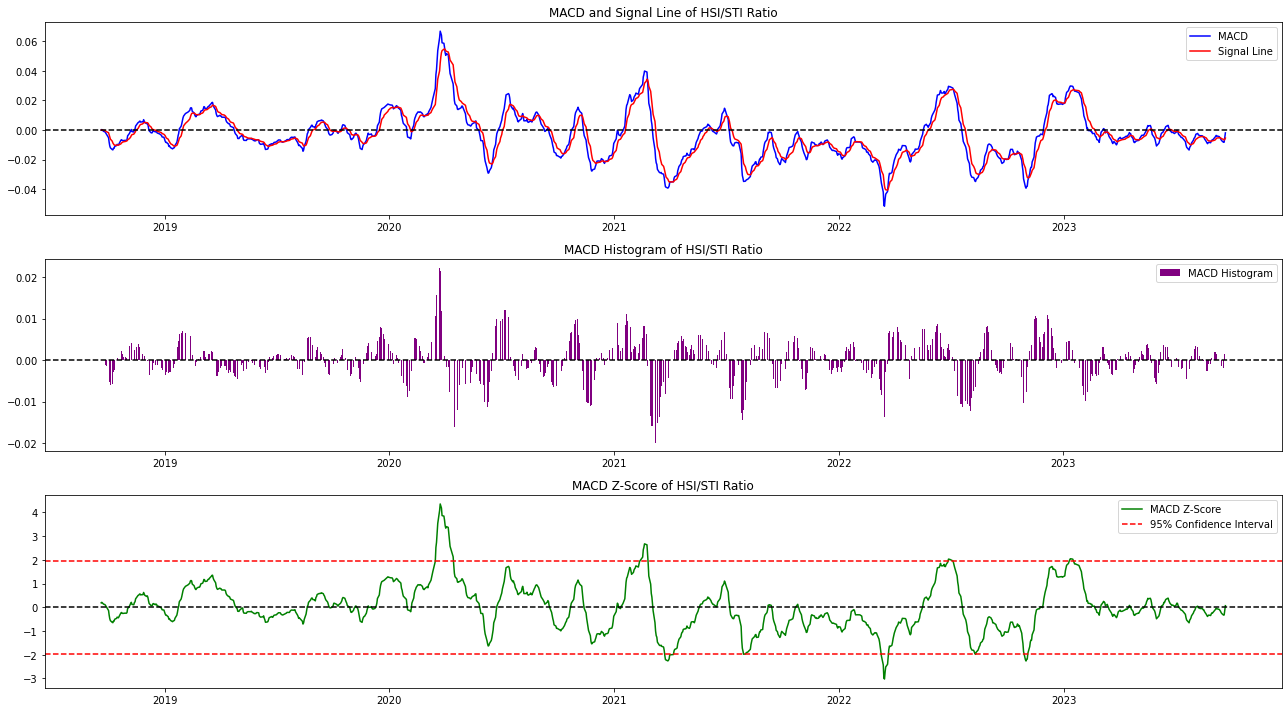

In [80]:
# Creating aligned_data DataFrame
aligned_data = pd.concat([HSI_data1_new['Adj Close USD'], STI_data1_new['Adj Close USD']], axis=1, join='inner')
aligned_data.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']
aligned_data['ratio'] = aligned_data['HSI_Adj_Close_USD'] / aligned_data['STI_Adj_Close_USD']

# # Define the short and long window
short_window = 12
long_window = 26
signal_window = 9

# Step 1: Compute the 12-day EMA of the ratio.
aligned_data['12d_ema'] = aligned_data['ratio'].ewm(span=short_window, adjust=False).mean()

# Step 2: Compute the 26-day EMA of the ratio.
aligned_data['26d_ema'] = aligned_data['ratio'].ewm(span=long_window, adjust=False).mean()

# Step 3: Subtract the 26-day EMA from the 12-day EMA to get the MACD line.
aligned_data['MACD'] = aligned_data['12d_ema'] - aligned_data['26d_ema']

# Step 4: Compute the 9-day EMA of the MACD line to get the Signal line.
# Step 4: Compute the 9-day EMA of the MACD line to get the Signal line.
aligned_data['Signal_Line'] = aligned_data['MACD'].ewm(span=signal_window, adjust=False).mean()  # Compute Signal Line


# Step 5: Subtract the Signal line from the MACD line to get the MACD Histogram.
aligned_data['MACD_Histogram'] = aligned_data['MACD'] - aligned_data['Signal_Line']

# Calculate Mean and Standard Deviation of MACD
mean_macd = aligned_data['MACD'].mean()
std_macd = aligned_data['MACD'].std()

# Calculate Z-Score of MACD
aligned_data['MACD_Z_Score'] = (aligned_data['MACD'] - mean_macd) / std_macd

# Plotting
plt.figure(figsize=(18, 10))

# Subplot 1 for MACD and Signal Line
plt.subplot(3, 1, 1)
plt.plot(aligned_data.index.array, aligned_data['MACD'].to_numpy(), label='MACD', color='blue')
plt.plot(aligned_data.index.array, aligned_data['Signal_Line'].to_numpy(), label='Signal Line', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('MACD and Signal Line of HSI/STI Ratio')
plt.legend()

# Subplot 2 for MACD Histogram
plt.subplot(3, 1, 2)
plt.bar(aligned_data.index, aligned_data['MACD_Histogram'], color='purple', label='MACD Histogram')
plt.axhline(0, color='black', linestyle='--')
plt.title('MACD Histogram of HSI/STI Ratio')
plt.legend()

# Subplot 3 for MACD Z-Score
plt.subplot(3, 1, 3)
plt.plot(aligned_data.index.array, aligned_data['MACD_Z_Score'].to_numpy(), color='green', label='MACD Z-Score')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1.96, color='red', linestyle='--', label='95% Confidence Interval')
plt.axhline(-1.96, color='red', linestyle='--')
plt.title('MACD Z-Score of HSI/STI Ratio')
plt.legend()

plt.tight_layout()
plt.show()

##### 6.4.1 MACD vs. Signal Line

In [82]:
fund = 100000  # Starting fund
trade_size = 5000  # Trade size per trade

hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

buy_signal_flag = False  # Flag to track Buy Signal
sell_signal_flag = False  # Flag to track Sell Signal

for i in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    previous_row = aligned_data.iloc[i - 1]

    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    # Buy Signal
    if (previous_row['MACD'] <= previous_row['Signal_Line'] and current_row['MACD'] > current_row['Signal_Line']) or current_row['MACD_Z_Score'] < -1.5:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position += hsi_quantity
        sti_position -= sti_quantity
        buy_signal_flag = True  # Set Buy Signal flag to True after executing Buy trade
        sell_signal_flag = False  # Reset Sell Signal flag
        fund -= trade_size  # Deduct the trade_size from the available fund
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_quantity, 'STI Quantity': sti_quantity, 'PnL': 0, 'Total PnL': total_pnl, 'Fund': available_fund})
        
    # Sell Signal
    elif (previous_row['MACD'] >= previous_row['Signal_Line'] and current_row['MACD'] < current_row['Signal_Line']) or current_row['MACD_Z_Score'] > 1.5:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        sell_signal_flag = True  # Set Sell Signal flag to True after executing Sell trade
        buy_signal_flag = False  # Reset Buy Signal flag
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Signal for Buy Position
    elif buy_signal_flag and previous_row['MACD'] >= previous_row['Signal_Line'] and current_row['MACD'] < current_row['Signal_Line']:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        buy_signal_flag = False  # Reset Buy Signal flag after exiting Buy position
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Signal for Sell Position
    elif sell_signal_flag and previous_row['MACD'] <= previous_row['Signal_Line'] and current_row['MACD'] > current_row['Signal_Line']:
        pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        sell_signal_flag = False  # Reset Sell Signal flag after exiting Sell position
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
    total_pnl += pnl
    available_fund = fund + total_pnl  # Update the available fund after the last transaction
    trade_logs.append({'Date': current_row.name, 'Action': 'Final Exit', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})

trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", total_pnl)

Total PnL:  220495.1820745573


#### 6.4.2 Z-score

In [83]:
fund = 100000  # Initial fund
trade_size = 5000  # Trade size per trade
lower_threshold = -1.96  # Lower threshold for Buy Signal
upper_threshold = 1.96  # Upper threshold for Sell Signal

hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

# Iterate over the data to find buy/sell signals
for i in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    previous_row = aligned_data.iloc[i - 1]
    
    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    # Buy Signal: MACD Z-Score crosses below the lower threshold
    if previous_row['MACD_Z_Score'] >= lower_threshold and current_row['MACD_Z_Score'] < lower_threshold:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position += hsi_quantity
        sti_position += sti_quantity  # assuming you are buying STI as well
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_quantity, 'STI Quantity': sti_quantity})
        
    # Sell Signal: MACD Z-Score crosses above the upper threshold
    elif previous_row['MACD_Z_Score'] <= upper_threshold and current_row['MACD_Z_Score'] > upper_threshold:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})
        
    # Exit Buy Position: MACD Z-Score crosses back above the lower threshold after a Buy trade
    elif hsi_position > 0 and previous_row['MACD_Z_Score'] <= lower_threshold and current_row['MACD_Z_Score'] > lower_threshold:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})
        
    # Exit Sell Position: MACD Z-Score crosses back below the upper threshold after a Sell trade
    elif hsi_position == 0 and previous_row['MACD_Z_Score'] >= upper_threshold and current_row['MACD_Z_Score'] < upper_threshold:
        # Assuming you want to close out positions when the MACD Z-Score is back below the upper threshold after a sell
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']

# Convert trade logs to a DataFrame
trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", total_pnl)

Total PnL:  25686.602769310353


### 6.5 Pairs Trading using 2 Bollinger Bands (BBands) Methods

6.5.1 Using Lower Band, Upper Band etc as Signals

6.5.2 Z-score

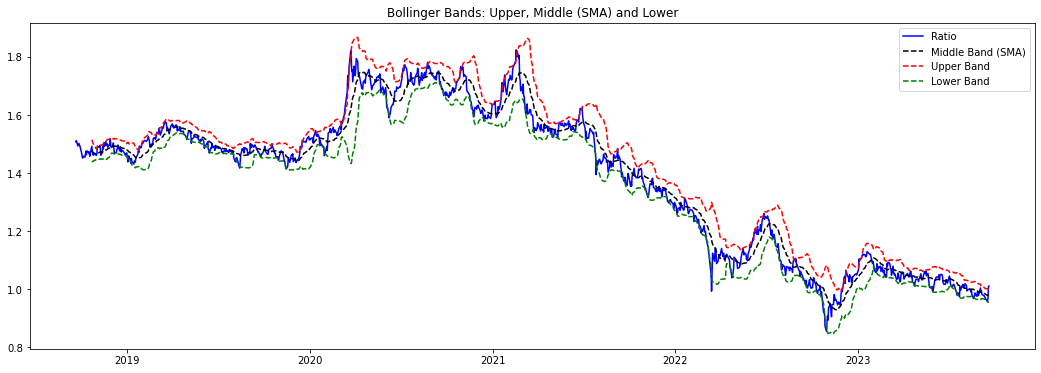

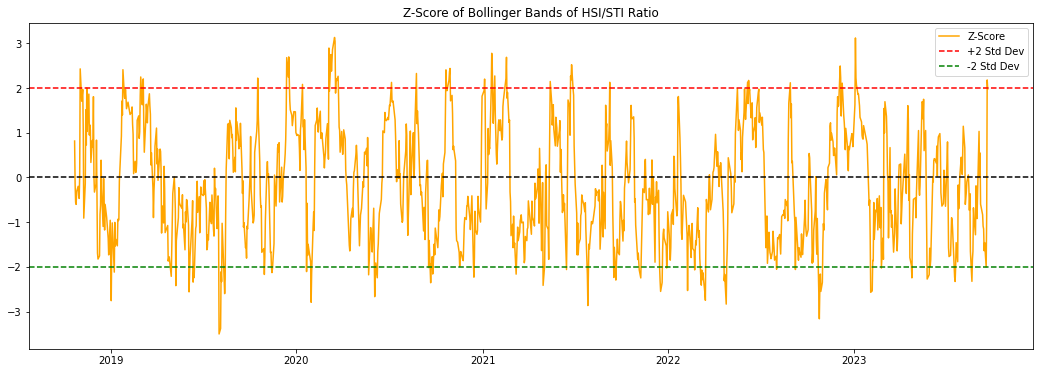

In [84]:
#bbands plotting
# Ensuring both DataFrames are aligned by date
aligned_data = pd.concat([HSI_data1_new['Adj Close USD'], STI_data1_new['Adj Close USD']], axis=1, join='inner')
aligned_data.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']

# Calculating the ratio of 'Adj Close' of HSI to 'Adj Close' of STI
aligned_data['ratio'] = aligned_data['HSI_Adj_Close_USD'] / aligned_data['STI_Adj_Close_USD']

# Calculating the 5-days SMA of the ratio
window = 20  # Bollinger Bands window length
num_std_dev = 2  # Number of standard deviations for the upper and lower bands

aligned_data['SMA'] = aligned_data['ratio'].rolling(window=window).mean()
aligned_data['rolling_std'] = aligned_data['ratio'].rolling(window=window).std()
aligned_data['upper_band'] = aligned_data['SMA'] + (aligned_data['rolling_std'] * num_std_dev)
aligned_data['lower_band'] = aligned_data['SMA'] - (aligned_data['rolling_std'] * num_std_dev)

aligned_data['BBands_Z_Score'] = (aligned_data['ratio'] - aligned_data['SMA']) / aligned_data['rolling_std']

# Plotting Bollinger Bands
plt.figure(figsize=(18,6))
plt.plot(aligned_data.index.to_numpy(), aligned_data['ratio'].to_numpy(), color='blue', label='Ratio')  # corrected line
plt.plot(aligned_data.index.to_numpy(), aligned_data['SMA'].to_numpy(), color='black', linestyle='--', label='Middle Band (SMA)')  # corrected line
plt.plot(aligned_data.index.to_numpy(), aligned_data['upper_band'].to_numpy(), color='red', linestyle='--', label='Upper Band')  # corrected line
plt.plot(aligned_data.index.to_numpy(), aligned_data['lower_band'].to_numpy(), color='green', linestyle='--', label='Lower Band')  # corrected line
plt.title('Bollinger Bands: Upper, Middle (SMA) and Lower')
plt.legend()
plt.show()

# Plotting Bollinger Bands Z-Score
plt.figure(figsize=(18,6))
plt.plot(aligned_data.index.to_numpy(), aligned_data['BBands_Z_Score'].to_numpy(), color='orange', label='Z-Score')  # already corrected
plt.axhline(0, color='black', linestyle='--')
plt.axhline(num_std_dev, color='red', linestyle='--', label=f'+{num_std_dev} Std Dev')
plt.axhline(-num_std_dev, color='green', linestyle='--', label=f'-{num_std_dev} Std Dev')
plt.title('Z-Score of Bollinger Bands of HSI/STI Ratio')
plt.legend()
plt.show()

#### 6.5.1 Using Lower Band, Upper Band etc as Signals

In [85]:
fund = 100000  # Starting fund
trade_size = 5000  # Trade size per trade

# Initialize variables to store trade info
hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
entry_ratio = 0  # Ratio at which we enter the trade
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

# Iterate over the data to find buy/sell signals
for i in range(window, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    previous_row = aligned_data.iloc[i - 1]
    available_fund = fund + total_pnl  # available fund before trading in each iteration
    
    # Buy Signal: Ratio crosses above Lower Band
    if previous_row['ratio'] <= previous_row['lower_band'] and current_row['ratio'] > current_row['lower_band']:
        if available_fund > trade_size:
            hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
            sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
            entry_ratio = current_row['ratio']
            hsi_position += hsi_quantity
            sti_position += sti_quantity
            trade_logs.append({
                'Date': current_row.name,
                'Action': 'Buy',
                'Ratio': entry_ratio,
                'HSI Quantity': hsi_quantity,
                'STI Quantity': sti_quantity,
                'Total PnL': total_pnl,
                'Fund': available_fund
            })

    # Sell Signal: Ratio crosses below Upper Band
    elif previous_row['ratio'] >= previous_row['upper_band'] and current_row['ratio'] < current_row['upper_band']:
        if hsi_position != 0 and sti_position != 0:
            exit_ratio = current_row['ratio']
            pnl = (hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']) - trade_size
            total_pnl += pnl
            hsi_position, sti_position = 0, 0  # Reset positions
            trade_logs.append({
                'Date': current_row.name,
                'Action': 'Sell',
                'Ratio': exit_ratio,
                'Total PnL': total_pnl,
                'Fund': available_fund
            })

# Convert trade logs to a DataFrame
trade_logs_df = pd.DataFrame(trade_logs)

# Display the trade logs and total PnL
print("Total PnL: ", total_pnl)

Total PnL:  137179.99359616643


#### 6.5.2 Z-score

In [86]:
fund = 100000  # Initial fund
trade_size = 5000  # Trade size per trade
hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

for i in range(window, len(aligned_data)):  # Start loop from the window's end due to rolling calculations
    current_row = aligned_data.iloc[i]
    bbands_z_score = current_row['BBands_Z_Score']  # Corrected variable name
    
    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    hsi_price = current_row['HSI_Adj_Close_USD']
    sti_price = current_row['STI_Adj_Close_USD']
    ratio = current_row['ratio']
    trade_quantity = min(trade_size // max(hsi_price, sti_price * ratio), available_fund // (hsi_price + sti_price * ratio))

    # Buy Signal: BBands Z-Score is below -1
    if bbands_z_score < -1:
        hsi_position += trade_quantity
        sti_position -= trade_quantity * ratio
        fund -= trade_size
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy HSI, Sell STI', 'HSI Quantity': trade_quantity, 'STI Quantity': -trade_quantity * ratio, 'PnL': 0, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Sell Signal: BBands Z-Score is above 1
    elif bbands_z_score > 1:
        pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell HSI, Buy STI', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Buy Signal: BBands Z-Score crosses back above -1 after Buy trade
    elif bbands_z_score >= -1 and hsi_position > 0 and sti_position < 0:
        pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})
    
    # Exit Sell Signal: BBands Z-Score crosses back below 1 after Sell trade
    elif bbands_z_score <= 1 and hsi_position < 0 and sti_position > 0:  # Corrected the condition
        pnl = hsi_position * hsi_price + abs(sti_position) * sti_price
        total_pnl += pnl
        hsi_position, sti_position = 0, 0  # Reset positions
        available_fund = fund + total_pnl  # Update the available fund after selling
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    pnl = hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
    total_pnl += pnl
    available_fund = fund + total_pnl  # Update the available fund after the last transaction
    trade_logs.append({'Date': current_row.name, 'Action': 'Final Exit', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': pnl, 'Total PnL': total_pnl, 'Fund': available_fund})

trade_logs_df = pd.DataFrame(trade_logs)
trade_logs_df['Total PnL'] = trade_logs_df['Total PnL'].astype(int)  # Convert to integer
trade_logs_df['Fund'] = trade_logs_df['Fund'].astype(int)  # Convert to integer
print("Total PnL: ", total_pnl)

Total PnL:  2455285.1085960376


### 6.6 Pairs Trading using 2 Relative Strength (RSI) MethodS

6.6.1 Using 0.3 & 0.7 Thresholds

6.6.2 Z-score

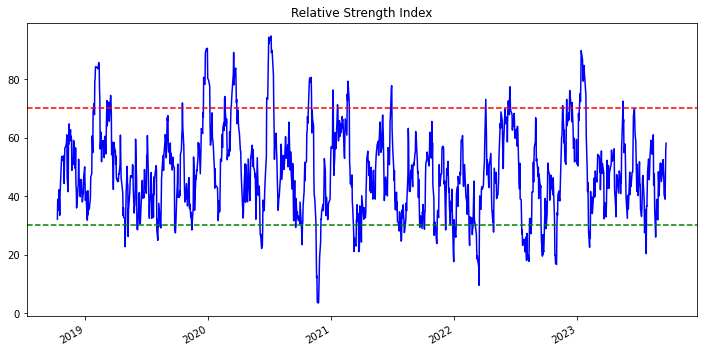

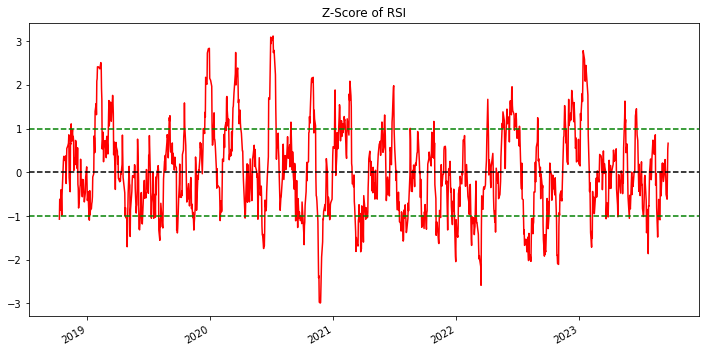

In [87]:
#rsi plotting
# Ensuring both DataFrames are aligned by date
aligned_data = pd.concat([HSI_data1_new['Adj Close USD'], STI_data1_new['Adj Close USD']], axis=1, join='inner')
aligned_data.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']

# Calculating the ratio of 'Adj Close' of HSI to 'Adj Close' of STI
aligned_data['ratio'] = aligned_data['HSI_Adj_Close_USD'] / aligned_data['STI_Adj_Close_USD']

# Calculating the 5-days SMA of the ratio
aligned_data['5_days_SMA'] = aligned_data['ratio'].rolling(window=10).mean()

# Calculating RSI
window = 14  # RSI window length
delta = aligned_data['ratio'].diff(1)  # difference between two consecutive prices
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

rs = avg_gain / avg_loss
aligned_data['RSI'] = 100 - (100 / (1 + rs))

mean_rsi = aligned_data['RSI'].mean()
std_rsi = aligned_data['RSI'].std()
aligned_data['RSI_Z-Score'] = (aligned_data['RSI'] - mean_rsi) / std_rsi

plt.figure(figsize=(12,6))
aligned_data['RSI'].plot(title='Relative Strength Index', color='blue')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.show()

plt.figure(figsize=(12,6))
aligned_data['RSI_Z-Score'].plot(title='Z-Score of RSI', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1.0, color='green', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.show()

#### 6.6.1 Using 0.3 & 0.7 Thresholds

In [88]:
lower_rsi_threshold = 30  # Define lower threshold for Buy Signal, typically 30 in RSI strategy
upper_rsi_threshold = 70  # Define upper threshold for Sell Signal, typically 70 in RSI strategy
neutral_rsi_threshold = 50 # Define neutral threshold for Exit Signal, typically 50 in RSI strategy
trade_size = 5000  # Amount to be utilized per trade

trade_logs = []
hsi_position, sti_position = 0, 0  # Initial positions
total_pnl = 0  # Initial profit and loss
fund = 100000  # Initial fund

for index in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[index]
    prev_row = aligned_data.iloc[index - 1]  # Get previous row for RSI signal check
    
    rsi = current_row['RSI']
    prev_rsi = prev_row['RSI']
    
    hsi_price = current_row['HSI_Adj_Close_USD']
    sti_price = current_row['STI_Adj_Close_USD']
    
    available_fund = fund + total_pnl - (abs(hsi_position) * hsi_price + abs(sti_position) * sti_price)
    
    if available_fund < trade_size:  # Skip if not enough available funds
        continue
    
    # Buy Signal: When previous RSI is below 30 and current RSI is above 30
    if prev_rsi < lower_rsi_threshold and rsi >= lower_rsi_threshold:
        hsi_trade_qty = trade_size // (2 * hsi_price)  # Allocate half of trade_size to HSI
        sti_trade_qty = trade_size // (2 * sti_price)  # Allocate the other half of trade_size to STI
        hsi_position += hsi_trade_qty
        sti_position += sti_trade_qty
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_trade_qty, 'STI Quantity': sti_trade_qty, 'PnL': total_pnl, 'Fund': available_fund})

    # Sell Signal: When previous RSI is above 70 and current RSI is below 70
    elif prev_rsi > upper_rsi_threshold and rsi <= upper_rsi_threshold:
        total_pnl += hsi_position * (hsi_price - prev_row['HSI_Adj_Close_USD']) + sti_position * (sti_price - prev_row['STI_Adj_Close_USD'])
        hsi_position, sti_position = 0, 0
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Fund': available_fund})
        
    # Exit Signal: When RSI comes back to neutral level
    elif ((prev_rsi < neutral_rsi_threshold and rsi >= neutral_rsi_threshold) or (prev_rsi > neutral_rsi_threshold and rsi <= neutral_rsi_threshold)) and (hsi_position != 0 or sti_position != 0):
        total_pnl += hsi_position * (hsi_price - prev_row['HSI_Adj_Close_USD']) + sti_position * (sti_price - prev_row['STI_Adj_Close_USD'])
        hsi_position, sti_position = 0, 0  # Close positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Fund': available_fund})        

# Finalizing any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    hsi_price = current_row['HSI_Adj_Close_USD']
    sti_price = current_row['STI_Adj_Close_USD']
    total_pnl += hsi_position * (hsi_price - prev_row['HSI_Adj_Close_USD']) + sti_position * (sti_price - prev_row['STI_Adj_Close_USD'])

# Convert trade logs to DataFrame for better readability
trade_logs_df = pd.DataFrame(trade_logs)
# Print total PnL
print("Total PnL: ", total_pnl)
        

Total PnL:  404.4458865300355


#### 6.6.2 Z-score

In [89]:
#5.8.2 backtesting
# Initialize variables
fund = 100000  # Initial fund
trade_size = 5000  # Trade size per trade
lower_threshold = -1.96  # Lower threshold for Buy Signal
upper_threshold = 1.96  # Upper threshold for Sell Signal

hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

# Iterate over the data to find buy/sell signals
for i in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    previous_row = aligned_data.iloc[i - 1]

    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    # Buy Signal: RSI Z-Score crosses below the lower threshold
    if previous_row['RSI_Z-Score'] >= lower_threshold and current_row['RSI_Z-Score'] < lower_threshold:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position += hsi_quantity
        sti_position += sti_quantity  # assuming you are buying STI as well
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_quantity, 'STI Quantity': sti_quantity})
        
    # Sell Signal: RSI Z-Score crosses above the upper threshold
    elif previous_row['RSI_Z-Score'] <= upper_threshold and current_row['RSI_Z-Score'] > upper_threshold:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})
        
    # Exit Buy Position: RSI Z-Score crosses back above the lower threshold after a Buy trade
    elif hsi_position > 0 and previous_row['RSI_Z-Score'] < lower_threshold and current_row['RSI_Z-Score'] >= lower_threshold:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})
        
    # Exit Sell Position: RSI Z-Score crosses back below the upper threshold after a Sell trade
    elif hsi_position == 0 and previous_row['RSI_Z-Score'] > upper_threshold and current_row['RSI_Z-Score'] <= upper_threshold:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + sti_position * current_row['STI_Adj_Close_USD']

# Convert trade logs to a DataFrame
trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", total_pnl)

Total PnL:  40438.19728441335


### 6.7 Pairs Trading using 2 Absolute Price Oscillator (APO) Methods

6.7.1 Using 0 line as Signal

6.7.2 Z-score

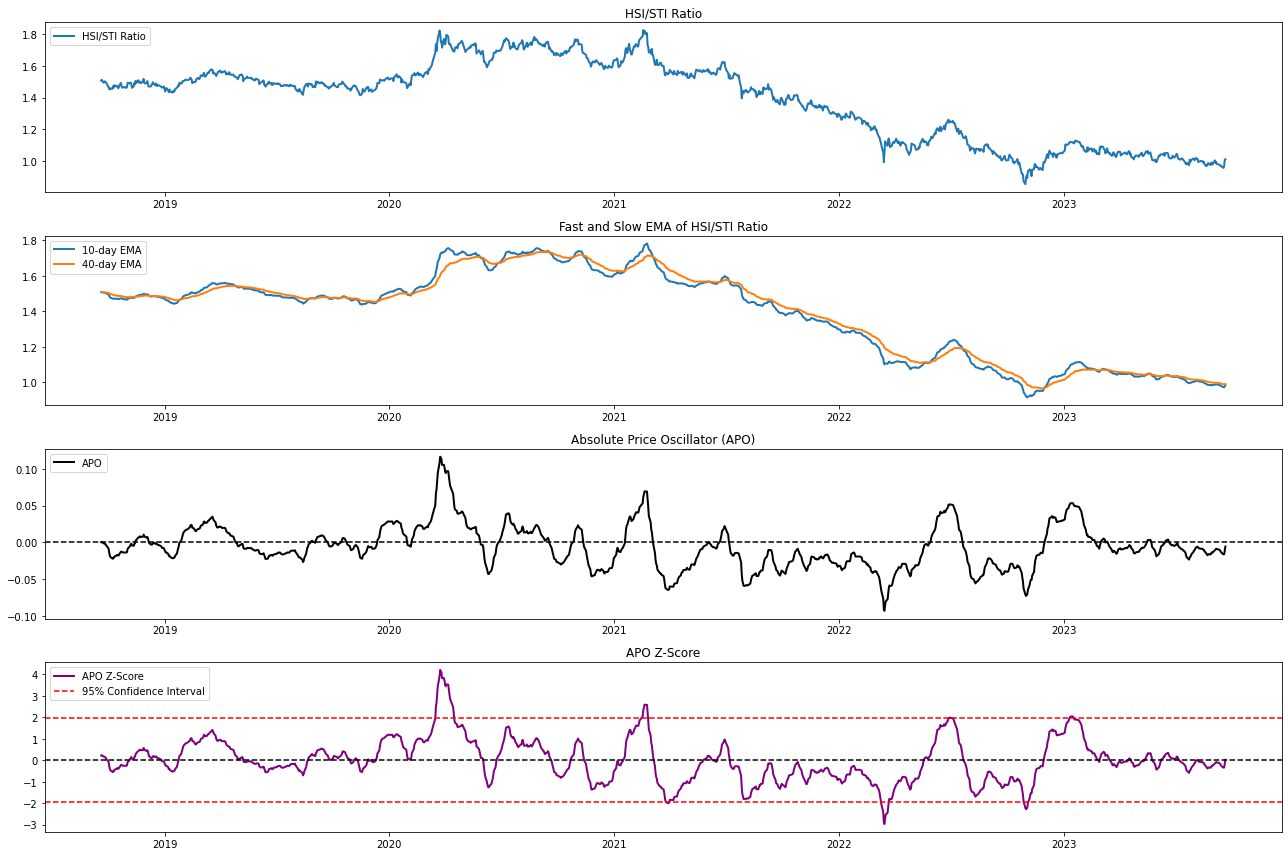

In [90]:
#apo plotting
# Creating aligned_data DataFrame
aligned_data = pd.concat([HSI_data1_new['Adj Close USD'], STI_data1_new['Adj Close USD']], axis=1, join='inner')
aligned_data.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']
aligned_data['ratio'] = aligned_data['HSI_Adj_Close_USD'] / aligned_data['STI_Adj_Close_USD']

# Initialize Variables for Fast and Slow EMA
NUM_PERIODS_FAST = 10
K_FAST = 2 / (NUM_PERIODS_FAST + 1)
ema_fast = 0
ema_fast_values = []

NUM_PERIODS_SLOW = 40
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1)
ema_slow = 0
ema_slow_values = []

apo_values = []

# Calculate APO
for idx, row in aligned_data.iterrows():
    ratio = row['ratio']
    if ema_fast == 0:  # if first value
        ema_fast = ema_slow = ratio
    else:
        ema_fast += (ratio - ema_fast) * K_FAST
        ema_slow += (ratio - ema_slow) * K_SLOW

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    
    apo = ema_fast - ema_slow
    apo_values.append(apo)

aligned_data = aligned_data.assign(FastExponential10DayMovingAverage=pd.Series(ema_fast_values, index=aligned_data.index))
aligned_data = aligned_data.assign(SlowExponential40DayMovingAverage=pd.Series(ema_slow_values, index=aligned_data.index))
aligned_data = aligned_data.assign(AbsolutePriceOscillator=pd.Series(apo_values, index=aligned_data.index))

# Calculate Mean and Standard Deviation of APO
mean_apo = aligned_data['AbsolutePriceOscillator'].mean()
std_apo = aligned_data['AbsolutePriceOscillator'].std()

# Calculate Z-Score of APO
aligned_data['APO_Z_Score'] = (aligned_data['AbsolutePriceOscillator'] - mean_apo) / std_apo

### Plotting
plt.figure(figsize=(18, 12))

plt.subplot(4,1,1)
plt.plot(aligned_data['ratio'], lw=2, label='HSI/STI Ratio')
plt.title('HSI/STI Ratio')
plt.legend(loc='upper left')

plt.subplot(4,1,2)
plt.plot(aligned_data['FastExponential10DayMovingAverage'], lw=2, label='10-day EMA')
plt.plot(aligned_data['SlowExponential40DayMovingAverage'], lw=2, label='40-day EMA')
plt.title('Fast and Slow EMA of HSI/STI Ratio')
plt.legend(loc='upper left')

plt.subplot(4,1,3)
plt.plot(aligned_data['AbsolutePriceOscillator'], lw=2, label='APO', color='k')
plt.axhline(0, color='black', linestyle='--')
plt.title('Absolute Price Oscillator (APO)')
plt.legend(loc='upper left')

plt.subplot(4,1,4)
plt.plot(aligned_data['APO_Z_Score'], lw=2, label='APO Z-Score', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1.96, color='red', linestyle='--', label='95% Confidence Interval')
plt.axhline(-1.96, color='red', linestyle='--')
plt.title('APO Z-Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### 6.7.1 Using 0 line as signal

In [91]:
# Initialize variables
fund = 100000  # Initial fund
trade_size = 5000  # Trade size per trade
hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

# Iterate over the data to find buy/sell signals
for i in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    previous_row = aligned_data.iloc[i - 1]

    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    # Buy Signal: APO crosses above the zero line
    if previous_row['AbsolutePriceOscillator'] <= 0 and current_row['AbsolutePriceOscillator'] > 0:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position += hsi_quantity
        sti_position -= sti_quantity
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_quantity, 'STI Quantity': sti_quantity})
        
    # Sell Signal: APO crosses below the zero line
    elif previous_row['AbsolutePriceOscillator'] >= 0 and current_row['AbsolutePriceOscillator'] < 0:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position -= hsi_quantity
        sti_position += sti_quantity
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': -hsi_quantity, 'STI Quantity': sti_quantity})
    
    # Exit Buy Position: APO crosses back below the zero line after a Buy trade
    elif hsi_position > 0 and previous_row['AbsolutePriceOscillator'] >= 0 and current_row['AbsolutePriceOscillator'] < 0:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})

    # Exit Sell Position: APO crosses back above the zero line after a Sell trade
    elif sti_position > 0 and previous_row['AbsolutePriceOscillator'] <= 0 and current_row['AbsolutePriceOscillator'] > 0:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']

# Convert trade logs to a DataFrame
trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", total_pnl)

Total PnL:  -94.3567924773053


#### 6.7.2 Z-score

In [92]:
fund = 100000  # Initial fund
trade_size = 5000  # Trade size per trade
lower_threshold = -1.96  # Lower threshold for Buy Signal
upper_threshold = 1.96  # Upper threshold for Sell Signal

hsi_position = 0  # Position in HSI
sti_position = 0  # Position in STI
total_pnl = 0  # Total Profit/Loss
trade_logs = []  # To store trade details

# Iterate over the data to find buy/sell signals
for i in range(1, len(aligned_data)):
    current_row = aligned_data.iloc[i]
    previous_row = aligned_data.iloc[i - 1]

    available_fund = fund + total_pnl
    if available_fund < trade_size:
        continue  # Skip if not enough available funds
    
    # Buy Signal: APO Z-Score crosses below the lower threshold
    if previous_row['APO_Z_Score'] >= lower_threshold and current_row['APO_Z_Score'] < lower_threshold:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position += hsi_quantity
        sti_position -= sti_quantity
        trade_logs.append({'Date': current_row.name, 'Action': 'Buy', 'HSI Quantity': hsi_quantity, 'STI Quantity': sti_quantity})
        
    # Sell Signal: APO Z-Score crosses above the upper threshold
    elif previous_row['APO_Z_Score'] <= upper_threshold and current_row['APO_Z_Score'] > upper_threshold:
        hsi_quantity = trade_size / 2 / current_row['HSI_Adj_Close_USD']
        sti_quantity = trade_size / 2 / current_row['STI_Adj_Close_USD']
        hsi_position -= hsi_quantity
        sti_position += sti_quantity
        trade_logs.append({'Date': current_row.name, 'Action': 'Sell', 'HSI Quantity': -hsi_quantity, 'STI Quantity': sti_quantity})
        
    # Exit Buy Position: APO Z-Score crosses back above the lower threshold after a Buy trade
    elif hsi_position > 0 and previous_row['APO_Z_Score'] <= lower_threshold and current_row['APO_Z_Score'] > lower_threshold:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Buy', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})
    
    # Exit Sell Position: APO Z-Score crosses back below the upper threshold after a Sell trade
    elif sti_position > 0 and previous_row['APO_Z_Score'] >= upper_threshold and current_row['APO_Z_Score'] < upper_threshold:
        total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']
        hsi_position, sti_position = 0, 0  # Reset positions
        trade_logs.append({'Date': current_row.name, 'Action': 'Exit Sell', 'HSI Quantity': 0, 'STI Quantity': 0, 'PnL': total_pnl, 'Total Fund': available_fund + total_pnl})

# Finalize any open positions at the end of the data series
if hsi_position != 0 or sti_position != 0:
    current_row = aligned_data.iloc[-1]
    total_pnl += hsi_position * current_row['HSI_Adj_Close_USD'] + abs(sti_position) * current_row['STI_Adj_Close_USD']

# Convert trade logs to a DataFrame
trade_logs_df = pd.DataFrame(trade_logs)
print("Total PnL: ", total_pnl)

Total PnL:  15918.203936669477


### 7. Further Detailed Backtesting of the most Profitable Method 6.5.2

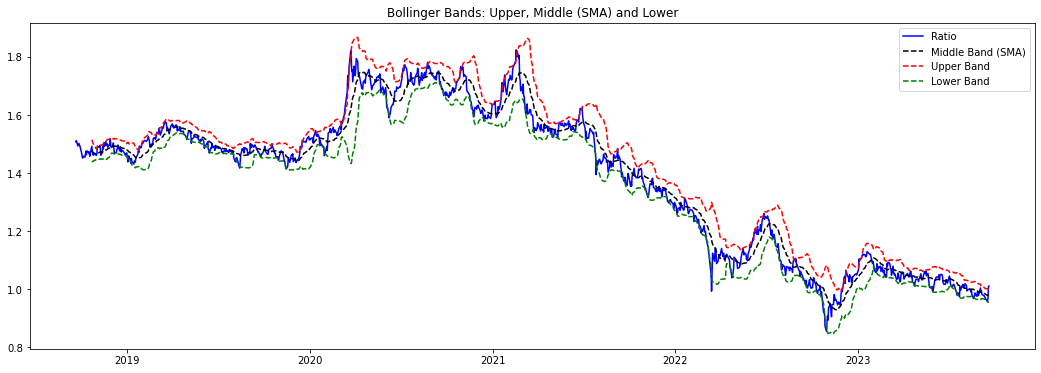

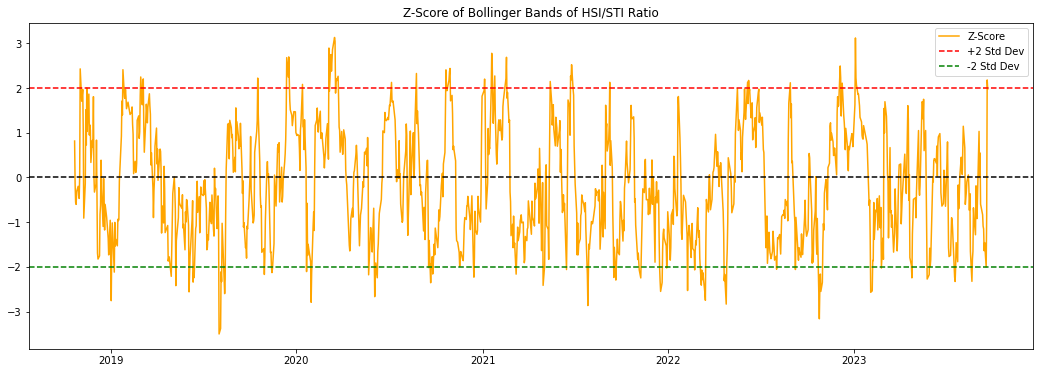

In [93]:
#bbands plotting
# Ensuring both DataFrames are aligned by date
aligned_data = pd.concat([HSI_data1_new['Adj Close USD'], STI_data1_new['Adj Close USD']], axis=1, join='inner')
aligned_data.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']

# Calculating the ratio of 'Adj Close' of HSI to 'Adj Close' of STI
aligned_data['ratio'] = aligned_data['HSI_Adj_Close_USD'] / aligned_data['STI_Adj_Close_USD']

# Calculating the 5-days SMA of the ratio
window = 20  # Bollinger Bands window length
num_std_dev = 2  # Number of standard deviations for the upper and lower bands

aligned_data['SMA'] = aligned_data['ratio'].rolling(window=window).mean()
aligned_data['rolling_std'] = aligned_data['ratio'].rolling(window=window).std()
aligned_data['upper_band'] = aligned_data['SMA'] + (aligned_data['rolling_std'] * num_std_dev)
aligned_data['lower_band'] = aligned_data['SMA'] - (aligned_data['rolling_std'] * num_std_dev)

aligned_data['BBands_Z_Score'] = (aligned_data['ratio'] - aligned_data['SMA']) / aligned_data['rolling_std']

# Plotting Bollinger Bands
plt.figure(figsize=(18,6))
plt.plot(aligned_data.index.to_numpy(), aligned_data['ratio'].to_numpy(), color='blue', label='Ratio')  # corrected line
plt.plot(aligned_data.index.to_numpy(), aligned_data['SMA'].to_numpy(), color='black', linestyle='--', label='Middle Band (SMA)')  # corrected line
plt.plot(aligned_data.index.to_numpy(), aligned_data['upper_band'].to_numpy(), color='red', linestyle='--', label='Upper Band')  # corrected line
plt.plot(aligned_data.index.to_numpy(), aligned_data['lower_band'].to_numpy(), color='green', linestyle='--', label='Lower Band')  # corrected line
plt.title('Bollinger Bands: Upper, Middle (SMA) and Lower')
plt.legend()
plt.show()

# Plotting Bollinger Bands Z-Score
plt.figure(figsize=(18,6))
plt.plot(aligned_data.index.to_numpy(), aligned_data['BBands_Z_Score'].to_numpy(), color='orange', label='Z-Score')  # already corrected
plt.axhline(0, color='black', linestyle='--')
plt.axhline(num_std_dev, color='red', linestyle='--', label=f'+{num_std_dev} Std Dev')
plt.axhline(-num_std_dev, color='green', linestyle='--', label=f'-{num_std_dev} Std Dev')
plt.title('Z-Score of Bollinger Bands of HSI/STI Ratio')
plt.legend()
plt.show()

#### 7.1 Without Transaction Cost and Short Selling Fee Profit

In [94]:
# Initialize the parameters
initial_fund = 1000000
trade_limit = 50000
cash = initial_fund
hsi_position = 0
sti_position = 0
buy_threshold = -1
sell_threshold = 1
position_flag = 0  # 0: No position, 1: Buy position, -1: Sell position

# Lists to store transaction details
timestamps = []
trade_types = []
hsi_quantities = []
sti_quantities = []
hsi_prices = []
sti_prices = []
cash_positions = []
hsi_positions = []
sti_positions = []
hsi_position_values = []
sti_position_values = []
pnl = []

for index, row in aligned_data.iterrows():
    hsi_price = round(row['HSI_Adj_Close_USD'], 2)
    sti_price = round(row['STI_Adj_Close_USD'], 2)
    z_score = row['BBands_Z_Score']
    
    ratio = hsi_price / sti_price
    hsi_qty = int(trade_limit / (hsi_price * (1 + ratio)))
    sti_qty = int(ratio * hsi_qty)
    
    if z_score < buy_threshold and cash >= trade_limit and position_flag == 0:
        # Execute Buy Trade
        cash -= round(hsi_qty * hsi_price + sti_qty * sti_price, 2)  # Update cash position
        hsi_position += hsi_qty  # Long HSI
        sti_position -= sti_qty  # Short STI
        position_flag = 1  # Set position flag to Buy position
        
    elif z_score > sell_threshold and cash >= trade_limit and position_flag == 0:
        # Execute Sell Trade
        cash += round(hsi_qty * hsi_price - sti_qty * sti_price, 2)  # Update cash position
        hsi_position -= hsi_qty  # Short HSI
        sti_position += sti_qty  # Long STI
        position_flag = -1  # Set position flag to Sell position
        
    elif position_flag == 1 and z_score >= buy_threshold:
        # Exit Buy Trade
        cash += round(hsi_position * hsi_price - sti_position * sti_price, 2)  # Reverse the Buy trade to exit
        hsi_position = 0  # Reset HSI position
        sti_position = 0  # Reset STI position
        position_flag = 0  # Reset position flag
        
    elif position_flag == -1 and z_score <= sell_threshold:
        # Exit Sell Trade
        cash -= round(hsi_position * hsi_price + sti_position * sti_price, 2)  # Reverse the Sell trade to exit
        hsi_position = 0  # Reset HSI position
        sti_position = 0  # Reset STI position
        position_flag = 0  # Reset position flag
    
    # Store transaction details for each time step
    timestamps.append(index)
    trade_types.append('No Action' if position_flag == 0 else 'Buy' if position_flag == 1 else 'Sell')
    hsi_quantities.append(hsi_position)
    sti_quantities.append(sti_position)
    hsi_prices.append(hsi_price)
    sti_prices.append(sti_price)
    cash_positions.append(round(cash, 2))
    hsi_positions.append(hsi_position)
    sti_positions.append(sti_position)
    hsi_position_values.append(round(hsi_position * hsi_price, 2))
    sti_position_values.append(round(sti_position * sti_price, 2))
    pnl.append(round(cash - initial_fund, 2))

# Creating a DataFrame to store and visualize the transaction details
transaction_data = pd.DataFrame({
    'Timestamp': timestamps,
    'Trade Type': trade_types,
    'HSI Quantity': hsi_quantities,
    'STI Quantity': sti_quantities,
    'HSI Price': hsi_prices,
    'STI Price': sti_prices,
    'Cash Position': cash_positions,
    'HSI Position': hsi_positions,
    'STI Position': sti_positions,
    'HSI Position Value': hsi_position_values,
    'STI Position Value': sti_position_values,
    'PnL': pnl
})

# Displaying the transaction details
print(transaction_data)

      Timestamp Trade Type  HSI Quantity  STI Quantity  HSI Price  STI Price  Cash Position  \
0    2018-09-20  No Action             0             0    3502.30    2323.13     1000000.00   
1    2018-09-21  No Action             0             0    3564.53    2357.62     1000000.00   
2    2018-09-24  No Action             0             0    3521.27    2358.36     1000000.00   
3    2018-09-26  No Action             0             0    3561.74    2371.30     1000000.00   
4    2018-09-27  No Action             0             0    3548.16    2369.67     1000000.00   
...         ...        ...           ...           ...        ...        ...            ...   
1200 2023-09-15        Buy            11           -10    2322.45    2404.65     1121332.57   
1201 2023-09-18        Buy            11           -10    2291.31    2394.71     1121332.57   
1202 2023-09-19  No Action             0             0    2301.96    2376.93     1170423.43   
1203 2023-09-20       Sell           -10          

In [95]:
# Get the last PnL value
last_pnl_value = transaction_data['PnL'].iloc[-1]

# Print out the last PnL value
print(f"The Profit of this strategy is: {last_pnl_value}")

The Profit of this strategy is: 170612.53


#### 7.2 With Transaction Cost and Short Selling Fee Profit

In [96]:
# Initialize the parameters
initial_fund = 1000000
trade_limit = 50000
cash = initial_fund
hsi_position = 0
sti_position = 0
buy_threshold = -1
sell_threshold = 1
transaction_cost_rate = 0.001  # 0.1%
short_selling_fee_rate = 0.005  # 0.5%
position_flag = 0  # 0: No position, 1: Buy position, -1: Sell position

# Lists to store transaction details
timestamps = []
trade_types = []
hsi_quantities = []
sti_quantities = []
hsi_prices = []
sti_prices = []
cash_positions = []
hsi_positions = []
sti_positions = []
hsi_position_values = []
sti_position_values = []
transaction_costs = []
short_selling_costs = []
pnl = []

cumulative_transaction_cost = 0
cumulative_short_selling_cost = 0

for index, row in aligned_data.iterrows():
    hsi_price = round(row['HSI_Adj_Close_USD'], 2)
    sti_price = round(row['STI_Adj_Close_USD'], 2)
    z_score = row['BBands_Z_Score']
    
    ratio = hsi_price / sti_price
    hsi_qty = int(trade_limit / (hsi_price * (1 + ratio)))
    sti_qty = int(ratio * hsi_qty)
    transaction_cost = 0
    short_selling_fee = 0
    
    if z_score < buy_threshold and cash >= trade_limit and position_flag == 0:
        # Execute Buy Trade
        transaction_cost = round((hsi_qty * hsi_price + sti_qty * sti_price) * transaction_cost_rate, 2)
        short_selling_fee = round(sti_qty * sti_price * short_selling_fee_rate, 2)
        cash -= round(hsi_qty * hsi_price + sti_qty * sti_price + transaction_cost + short_selling_fee, 2)
        hsi_position += hsi_qty
        sti_position -= sti_qty
        position_flag = 1
        
    elif z_score > sell_threshold and cash >= trade_limit and position_flag == 0:
        # Execute Sell Trade
        transaction_cost = round((hsi_qty * hsi_price + sti_qty * sti_price) * transaction_cost_rate, 2)
        short_selling_fee = round(hsi_qty * hsi_price * short_selling_fee_rate, 2)
        cash += round(hsi_qty * hsi_price - sti_qty * sti_price - transaction_cost - short_selling_fee, 2)
        hsi_position -= hsi_qty
        sti_position += sti_qty
        position_flag = -1
        
    elif position_flag == 1 and z_score >= buy_threshold:
        # Exit Buy Trade
        transaction_cost = round((hsi_position * hsi_price + abs(sti_position) * sti_price) * transaction_cost_rate, 2)
        cash += round(hsi_position * hsi_price - sti_position * sti_price - transaction_cost, 2)
        hsi_position = 0
        sti_position = 0
        position_flag = 0
        
    elif position_flag == -1 and z_score <= sell_threshold:
        # Exit Sell Trade
        transaction_cost = round((abs(hsi_position) * hsi_price + sti_position * sti_price) * transaction_cost_rate, 2)
        cash -= round(hsi_position * hsi_price + sti_position * sti_price + transaction_cost, 2)
        hsi_position = 0
        sti_position = 0
        position_flag = 0
        
    # Cumulative costs
    cumulative_transaction_cost += transaction_cost
    cumulative_short_selling_cost += short_selling_fee
    
    # Store transaction details for each time step
    timestamps.append(index)
    trade_types.append('No Action' if position_flag == 0 else 'Buy' if position_flag == 1 else 'Sell')
    hsi_quantities.append(hsi_position)
    sti_quantities.append(sti_position)
    hsi_prices.append(hsi_price)
    sti_prices.append(sti_price)
    cash_positions.append(round(cash, 2))
    hsi_positions.append(hsi_position)
    sti_positions.append(sti_position)
    hsi_position_values.append(round(hsi_position * hsi_price, 2))
    sti_position_values.append(round(sti_position * sti_price, 2))
    transaction_costs.append(round(cumulative_transaction_cost, 2))
    short_selling_costs.append(round(cumulative_short_selling_cost, 2))
    pnl.append(round(cash - cumulative_transaction_cost - cumulative_short_selling_cost - initial_fund, 2))

# Creating a DataFrame to store and visualize the transaction details
transaction_data = pd.DataFrame({
    'Timestamp': timestamps,
    'Trade Type': trade_types,
    'HSI Quantity': hsi_quantities,
    'STI Quantity': sti_quantities,
    'HSI Price': hsi_prices,
    'STI Price': sti_prices,
    'Cash Position': cash_positions,
    'HSI Position': hsi_positions,
    'STI Position': sti_positions,
    'HSI Position Value': hsi_position_values,
    'STI Position Value': sti_position_values,
    'Transaction Cost': transaction_costs,
    'Short Selling Cost': short_selling_costs,
    'PnL': pnl
})

# Displaying the transaction details
print(transaction_data)

      Timestamp Trade Type  HSI Quantity  STI Quantity  HSI Price  STI Price  Cash Position  \
0    2018-09-20  No Action             0             0    3502.30    2323.13     1000000.00   
1    2018-09-21  No Action             0             0    3564.53    2357.62     1000000.00   
2    2018-09-24  No Action             0             0    3521.27    2358.36     1000000.00   
3    2018-09-26  No Action             0             0    3561.74    2371.30     1000000.00   
4    2018-09-27  No Action             0             0    3548.16    2369.67     1000000.00   
...         ...        ...           ...           ...        ...        ...            ...   
1200 2023-09-15        Buy            11           -10    2322.45    2404.65     1095310.66   
1201 2023-09-18        Buy            11           -10    2291.31    2394.71     1095310.66   
1202 2023-09-19  No Action             0             0    2301.96    2376.93     1144352.43   
1203 2023-09-20       Sell           -10          

In [97]:
# Get the last PnL value
last_pnl_value = transaction_data['PnL'].iloc[-1]

# Print out the last PnL value
print(f"The Profit of this strategy is: {last_pnl_value}")

The Profit of this strategy is: 118148.51


### 8. Comparing the Predicted and Actual Z Score

In [98]:
#Fetch HSI data using yfinance and get the actual price value in USD
start_date = '2023-08-01'
end_date = '2023-09-22'
symbols = ['^HSI']
HSI_data_real = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Convert HSI_data_real to DataFrame
HSI_data_real_df = HSI_data_real.to_frame(name='HSI_Adj_Close')

# Fetch USD/HKD Data
currency_symbol = "USDHKD=X"
usdhkd_data = yf.download(currency_symbol, start=start_date, end=end_date)['Adj Close']

# Convert the USD/HKD series to a DataFrame
usdhkd_df = usdhkd_data.to_frame(name='USDHKD_Adj_Close')

# Join with HSI_data_real_df using the index
HSI_data_real_merged = HSI_data_real_df.join(usdhkd_df, how='left')

# Forward Fill any Missing Values in USDHKD_Adj_Close
HSI_data_real_merged['USDHKD_Adj_Close'].fillna(method='ffill', inplace=True)

# Add a new column 'Adj Close USD' to the DataFrame
HSI_data_real_merged['Adj Close USD'] = HSI_data_real_merged['HSI_Adj_Close'] / HSI_data_real_merged['USDHKD_Adj_Close']

# Display the DataFrame
print(HSI_data_real_merged[-2:])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            HSI_Adj_Close  USDHKD_Adj_Close  Adj Close USD
Date                                                      
2023-09-20   17885.599609            7.8209    2286.897888
2023-09-21   17655.410156            7.8238    2256.628487


In [99]:
#Fetch STI data using yfinance and get the actual price value in USD
start_date = '2023-08-01'
end_date = '2023-09-22'
symbols = ['^STI']
STI_data_real = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Convert STI_data_real to DataFrame
STI_data_real_df = STI_data_real.to_frame(name='STI_Adj_Close')

# Fetch USD/SGD Data
currency_symbol = "USDSGD=X"
usdsgd_data = yf.download(currency_symbol, start=start_date, end=end_date)['Adj Close']

# Convert the USD/SGD series to a DataFrame
usdsgd_df = usdsgd_data.to_frame(name='USDSGD_Adj_Close')

# Join with STI_data_real_df using the index
STI_data_real_merged = STI_data_real_df.join(usdsgd_df, how='left')

# Forward Fill any Missing Values in USDSGD_Adj_Close
STI_data_real_merged['USDSGD_Adj_Close'].fillna(method='ffill', inplace=True)

# Add a new column 'Adj Close USD' to the DataFrame
STI_data_real_merged['Adj Close USD'] = STI_data_real_merged['STI_Adj_Close'] / STI_data_real_merged['USDSGD_Adj_Close']

# Display the DataFrame
print(STI_data_real_merged[-2:])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            STI_Adj_Close  USDSGD_Adj_Close  Adj Close USD
Date                                                      
2023-09-20    3242.000000           1.36434    2376.240618
2023-09-21    3202.810059           1.36624    2344.251377


#### 8.1 Actual Z score 

In [100]:
# Ensure both DataFrames are aligned by date
aligned_data_real = pd.concat([HSI_data_real_merged['Adj Close USD'], STI_data_real_merged['Adj Close USD']], axis=1, join='inner')
aligned_data_real.columns = ['HSI_Adj_Close_USD', 'STI_Adj_Close_USD']

# Calculate the ratio of 'Adj Close USD' of HSI to 'Adj Close USD' of STI
aligned_data_real['ratio'] = aligned_data_real['HSI_Adj_Close_USD'] / aligned_data_real['STI_Adj_Close_USD']

# Calculate the 20-days SMA and Rolling Standard Deviation of the ratio
window = 20  # Bollinger Bands window length
num_std_dev = 2  # Number of standard deviations for the upper and lower bands

aligned_data_real['SMA'] = aligned_data_real['ratio'].rolling(window=window).mean()
aligned_data_real['rolling_std'] = aligned_data_real['ratio'].rolling(window=window).std()

# Calculate Bollinger Bands Z-Score for the ratio
aligned_data_real['BBands_Z_Score'] = (aligned_data_real['ratio'] - aligned_data_real['SMA']) / aligned_data_real['rolling_std']

# Display the Bollinger Bands Z-Score of the ratio for the last two rows
print(aligned_data_real['BBands_Z_Score'][-2:])

Date
2023-09-20   -1.349584
2023-09-21   -1.226075
Name: BBands_Z_Score, dtype: float64


#### 8.2 Predicted Z Score 

In [101]:
# Get the last two z-scores
last_two_z_scores = aligned_data['BBands_Z_Score'].iloc[-2:]

# Print out the last two z-scores
print("The Bollinger Bands Z-Scores of the last two rows are:")
print(last_two_z_scores)

The Bollinger Bands Z-Scores of the last two rows are:
2023-09-20    2.179747
2023-09-21    1.977558
Name: BBands_Z_Score, dtype: float64
